In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train_est_A = pd.read_csv('train_est_C.csv')
df_train_obs_A = pd.read_csv('train_obs_C.csv')
df_test_A = pd.read_csv('X_test_C.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [3]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [4]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [8]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Sample DataFrame (replace this with your own dataset)
data = df

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [13]:
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-0),
        'n_estimators': trial.suggest_int('n_estimators',10,1000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_int('random_state', 1,1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
            # Create an XGBoost DMatrix for training and testing data
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train the XGBoost model
        model = xgb.train(param, dtrain)

        # Make predictions on the test data
        y_pred = model.predict(dtest)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [14]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize')

[I 2023-10-25 15:21:44,003] A new study created in memory with name: no-name-1c53f22a-4732-4d51-a6f0-5e489e81ed83


In [15]:
study.optimize(objective, n_trials=200)

Mean Absolute Error: 108.9227680610954
Mean Absolute Error: 114.18547674613987


[I 2023-10-25 15:21:44,800] Trial 0 finished with value: 101.30227216695333 and parameters: {'lambda': 0.07992526829652047, 'alpha': 0.26646142220324587, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0026891722130448197, 'n_estimators': 359, 'max_depth': 9, 'random_state': 232, 'min_child_weight': 252}. Best is trial 0 with value: 101.30227216695333.


Mean Absolute Error: 80.79857169362468
Mean Absolute Error: 103.00771808468167
Mean Absolute Error: 77.96835305720111


[I 2023-10-25 15:21:45,091] Trial 1 finished with value: 77.07212588234773 and parameters: {'lambda': 0.7447890362497824, 'alpha': 1.16636671022957, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.06639401041736026, 'n_estimators': 816, 'max_depth': 7, 'random_state': 943, 'min_child_weight': 51}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 50.24030650516041
Mean Absolute Error: 104.53031058596439
Mean Absolute Error: 80.61313398090388


[I 2023-10-25 15:21:45,376] Trial 2 finished with value: 80.56213010384276 and parameters: {'lambda': 0.15011047755405008, 'alpha': 0.020828011836944653, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.046598930979506445, 'n_estimators': 22, 'max_depth': 9, 'random_state': 340, 'min_child_weight': 123}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 56.542945744660045
Mean Absolute Error: 109.17608542646224
Mean Absolute Error: 115.96456507031894


[I 2023-10-25 15:21:45,620] Trial 3 finished with value: 102.42684747032068 and parameters: {'lambda': 0.010014711461226336, 'alpha': 0.07554203026669654, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.0006729813710266864, 'n_estimators': 195, 'max_depth': 17, 'random_state': 571, 'min_child_weight': 220}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 82.13989191418084
Mean Absolute Error: 107.52109832717687
Mean Absolute Error: 102.5113020525292


[I 2023-10-25 15:21:45,839] Trial 4 finished with value: 94.31248866613477 and parameters: {'lambda': 5.754364136828587, 'alpha': 0.020620479207432634, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014784373480716805, 'n_estimators': 68, 'max_depth': 13, 'random_state': 68, 'min_child_weight': 184}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 72.90506561869823
Mean Absolute Error: 105.46701287164437
Mean Absolute Error: 86.542717130032


[I 2023-10-25 15:21:46,078] Trial 5 finished with value: 84.55204958438571 and parameters: {'lambda': 2.3166781512693797, 'alpha': 6.410607463875179, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.0349349980265709, 'n_estimators': 919, 'max_depth': 15, 'random_state': 776, 'min_child_weight': 254}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 61.646418751480766
Mean Absolute Error: 108.71600182180765
Mean Absolute Error: 112.20334221934655


[I 2023-10-25 15:21:46,312] Trial 6 finished with value: 100.20144917863429 and parameters: {'lambda': 0.0027114538382478673, 'alpha': 0.00963474254072037, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.004153402891514467, 'n_estimators': 563, 'max_depth': 9, 'random_state': 217, 'min_child_weight': 283}. Best is trial 1 with value: 77.07212588234773.


Mean Absolute Error: 79.68500349474868
Mean Absolute Error: 101.62956590550479
Mean Absolute Error: 33.033971885534555


[I 2023-10-25 15:21:46,529] Trial 7 finished with value: 51.27239586052577 and parameters: {'lambda': 0.0018694058613626368, 'alpha': 0.01769425781057712, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.35221390821202697, 'n_estimators': 927, 'max_depth': 5, 'random_state': 130, 'min_child_weight': 289}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 19.153649790537962
Mean Absolute Error: 109.15253902813336
Mean Absolute Error: 115.80455443855774


[I 2023-10-25 15:21:46,742] Trial 8 finished with value: 102.33528340903445 and parameters: {'lambda': 0.0015045235346843042, 'alpha': 1.7129648865372595, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.0008115182595513933, 'n_estimators': 335, 'max_depth': 5, 'random_state': 43, 'min_child_weight': 176}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 82.04875676041222
Mean Absolute Error: 109.24286013514754
Mean Absolute Error: 116.48539143545257


[I 2023-10-25 15:21:47,005] Trial 9 finished with value: 102.75212138655122 and parameters: {'lambda': 0.12758165190874043, 'alpha': 3.0485173908006353, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.00011032634485931693, 'n_estimators': 501, 'max_depth': 11, 'random_state': 139, 'min_child_weight': 106}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 82.52811258905356
Mean Absolute Error: 103.66332623307954
Mean Absolute Error: 34.21110325457178


[I 2023-10-25 15:21:47,266] Trial 10 finished with value: 52.81260097291655 and parameters: {'lambda': 0.011574293396731782, 'alpha': 0.0016194239270019635, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.7286965679020286, 'n_estimators': 712, 'max_depth': 5, 'random_state': 496, 'min_child_weight': 3}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 20.563373431098327
Mean Absolute Error: 103.18367487788313
Mean Absolute Error: 34.061752146558106


[I 2023-10-25 15:21:47,522] Trial 11 finished with value: 53.73580888195335 and parameters: {'lambda': 0.011964261418218313, 'alpha': 0.0011385827377522206, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.8313739620773049, 'n_estimators': 734, 'max_depth': 5, 'random_state': 502, 'min_child_weight': 2}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 23.9619996214188
Mean Absolute Error: 104.50988606576341
Mean Absolute Error: 36.46169249921708


[I 2023-10-25 15:21:47,770] Trial 12 finished with value: 54.46390001003678 and parameters: {'lambda': 0.0010876503180756018, 'alpha': 0.0015005509772816046, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.9954840532699002, 'n_estimators': 959, 'max_depth': 5, 'random_state': 352, 'min_child_weight': 76}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 22.420121465129853
Mean Absolute Error: 100.76045423092772
Mean Absolute Error: 37.261999914209305


[I 2023-10-25 15:21:48,022] Trial 13 finished with value: 52.79714340391715 and parameters: {'lambda': 0.005749871640897641, 'alpha': 0.004462726212220475, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.2916378191493487, 'n_estimators': 702, 'max_depth': 5, 'random_state': 661, 'min_child_weight': 296}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 20.368976066614408
Mean Absolute Error: 101.18390593270999
Mean Absolute Error: 44.947609992790255


[I 2023-10-25 15:21:48,268] Trial 14 finished with value: 59.07401539952523 and parameters: {'lambda': 0.00413658844433235, 'alpha': 0.006262321951990632, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.140048881716042, 'n_estimators': 628, 'max_depth': 5, 'random_state': 686, 'min_child_weight': 298}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 31.09053027307544
Mean Absolute Error: 100.50342521352441
Mean Absolute Error: 38.38675647788114


[I 2023-10-25 15:21:48,551] Trial 15 finished with value: 54.255677017999034 and parameters: {'lambda': 0.00105691177047217, 'alpha': 0.06546594012666855, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.201232754444871, 'n_estimators': 1000, 'max_depth': 17, 'random_state': 844, 'min_child_weight': 223}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 23.876849362591535
Mean Absolute Error: 99.40963536047713
Mean Absolute Error: 37.595128028880765


[I 2023-10-25 15:21:48,826] Trial 16 finished with value: 53.78862173017033 and parameters: {'lambda': 0.00415587924371103, 'alpha': 0.004824138458089799, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.19694740593244578, 'n_estimators': 829, 'max_depth': 13, 'random_state': 630, 'min_child_weight': 266}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 24.361101801153097
Mean Absolute Error: 101.41549032442617
Mean Absolute Error: 35.096825400078046


[I 2023-10-25 15:21:49,100] Trial 17 finished with value: 51.96567137229841 and parameters: {'lambda': 0.02873676998079319, 'alpha': 0.00387808908958841, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.36678036518557494, 'n_estimators': 753, 'max_depth': 7, 'random_state': 407, 'min_child_weight': 212}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 19.384698392391023
Mean Absolute Error: 101.4757902366554
Mean Absolute Error: 34.38031784305262


[I 2023-10-25 15:21:49,364] Trial 18 finished with value: 51.79999084022989 and parameters: {'lambda': 0.03610375232023872, 'alpha': 0.028188862244794725, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.4175765820114642, 'n_estimators': 858, 'max_depth': 7, 'random_state': 370, 'min_child_weight': 214}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 19.54386444098165
Mean Absolute Error: 102.70247942460188
Mean Absolute Error: 60.46196422308264


[I 2023-10-25 15:21:49,642] Trial 19 finished with value: 68.81464954044897 and parameters: {'lambda': 0.02488316092839437, 'alpha': 0.27501741000837415, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.08232266955181607, 'n_estimators': 869, 'max_depth': 7, 'random_state': 237, 'min_child_weight': 156}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 43.27950497366241
Mean Absolute Error: 100.99280733206348
Mean Absolute Error: 35.97873597352196


[I 2023-10-25 15:21:49,905] Trial 20 finished with value: 52.594212921389406 and parameters: {'lambda': 0.0501857510609618, 'alpha': 0.02062650036251705, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.4395335914412821, 'n_estimators': 443, 'max_depth': 15, 'random_state': 145, 'min_child_weight': 235}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 20.81109545858276
Mean Absolute Error: 100.92349305886815
Mean Absolute Error: 34.28294987610006


[I 2023-10-25 15:21:50,167] Trial 21 finished with value: 51.728353604637306 and parameters: {'lambda': 0.02750876984373695, 'alpha': 0.03903601171704107, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.3344950654404342, 'n_estimators': 801, 'max_depth': 7, 'random_state': 353, 'min_child_weight': 202}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 19.97861787894371
Mean Absolute Error: 101.71522303682917
Mean Absolute Error: 47.78481571246882


[I 2023-10-25 15:21:50,435] Trial 22 finished with value: 60.0899733162722 and parameters: {'lambda': 0.23811704383984644, 'alpha': 0.04563047874084282, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1414757396143939, 'n_estimators': 903, 'max_depth': 7, 'random_state': 330, 'min_child_weight': 194}. Best is trial 7 with value: 51.27239586052577.


Mean Absolute Error: 30.769881199518593
Mean Absolute Error: 101.8576755462311
Mean Absolute Error: 31.452686366875803


[I 2023-10-25 15:21:50,709] Trial 23 finished with value: 50.90335956541611 and parameters: {'lambda': 0.03293688399327544, 'alpha': 0.16159836250934467, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.4016826957459288, 'n_estimators': 619, 'max_depth': 7, 'random_state': 462, 'min_child_weight': 146}. Best is trial 23 with value: 50.90335956541611.


Mean Absolute Error: 19.39971678314143
Mean Absolute Error: 101.62765069727274
Mean Absolute Error: 48.560226438203124


[I 2023-10-25 15:21:50,984] Trial 24 finished with value: 61.759369449033024 and parameters: {'lambda': 0.018834937277596546, 'alpha': 0.14575139237218343, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.11574727998879379, 'n_estimators': 614, 'max_depth': 11, 'random_state': 452, 'min_child_weight': 138}. Best is trial 23 with value: 50.90335956541611.


Mean Absolute Error: 35.090231211623205
Mean Absolute Error: 106.34541814487275
Mean Absolute Error: 98.45292051789906


[I 2023-10-25 15:21:51,256] Trial 25 finished with value: 90.530195038998 and parameters: {'lambda': 0.059590556909099764, 'alpha': 0.11677410333879966, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.027165301877794527, 'n_estimators': 651, 'max_depth': 7, 'random_state': 279, 'min_child_weight': 161}. Best is trial 23 with value: 50.90335956541611.


Mean Absolute Error: 66.7922464542222
Mean Absolute Error: 102.3106236996195
Mean Absolute Error: 69.22782469513362


[I 2023-10-25 15:21:51,529] Trial 26 finished with value: 72.4763260162838 and parameters: {'lambda': 0.009243529222528555, 'alpha': 0.04612300233892574, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.0757655859687714, 'n_estimators': 786, 'max_depth': 7, 'random_state': 136, 'min_child_weight': 95}. Best is trial 23 with value: 50.90335956541611.


Mean Absolute Error: 45.89052965409833
Mean Absolute Error: 101.39467247405008
Mean Absolute Error: 30.68787347155013


[I 2023-10-25 15:21:51,803] Trial 27 finished with value: 50.58181111464639 and parameters: {'lambda': 0.0028362908445515073, 'alpha': 0.011890861776329234, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.3192642773223881, 'n_estimators': 486, 'max_depth': 7, 'random_state': 8, 'min_child_weight': 135}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 19.66288739833897
Mean Absolute Error: 103.09007617774898
Mean Absolute Error: 32.53048619573319


[I 2023-10-25 15:21:52,100] Trial 28 finished with value: 51.99626981844259 and parameters: {'lambda': 0.0022286914749353286, 'alpha': 0.012157568873147768, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.6164115818176226, 'n_estimators': 399, 'max_depth': 11, 'random_state': 43, 'min_child_weight': 135}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 20.368247081845595
Mean Absolute Error: 100.26720086120022


[I 2023-10-25 15:21:52,554] Trial 29 finished with value: 52.76593020468707 and parameters: {'lambda': 0.002653579984111719, 'alpha': 0.2417276848790369, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2222252966809155, 'n_estimators': 243, 'max_depth': 15, 'random_state': 2, 'min_child_weight': 52}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 36.112547284548484
Mean Absolute Error: 21.91804246831252


[I 2023-10-25 15:21:52,825] Trial 30 finished with value: 63.70702169764714 and parameters: {'lambda': 0.005573838030812826, 'alpha': 0.5601876694241974, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.1137374731893766, 'n_estimators': 484, 'max_depth': 13, 'random_state': 215, 'min_child_weight': 169}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 101.18214753105956
Mean Absolute Error: 54.53623547292031
Mean Absolute Error: 35.40268208896157


[I 2023-10-25 15:21:53,099] Trial 31 finished with value: 50.85716432379022 and parameters: {'lambda': 0.01740330847898823, 'alpha': 0.03068519740598734, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.40722419130919785, 'n_estimators': 562, 'max_depth': 7, 'random_state': 100, 'min_child_weight': 114}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 102.03108177901451
Mean Absolute Error: 31.337130781557413
Mean Absolute Error: 19.203280410798747


[I 2023-10-25 15:21:53,379] Trial 32 finished with value: 50.99493141877687 and parameters: {'lambda': 0.015843581366730544, 'alpha': 0.08108056707278222, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.5467469342830293, 'n_estimators': 562, 'max_depth': 7, 'random_state': 89, 'min_child_weight': 109}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 102.60013791530248
Mean Absolute Error: 30.660360519956175
Mean Absolute Error: 19.72429582107197


[I 2023-10-25 15:21:53,652] Trial 33 finished with value: 50.98825713554217 and parameters: {'lambda': 0.0640119263887687, 'alpha': 0.11306772589699704, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.5733775958643794, 'n_estimators': 551, 'max_depth': 7, 'random_state': 76, 'min_child_weight': 111}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 102.21955341192614
Mean Absolute Error: 31.307022113221326
Mean Absolute Error: 19.438195881479025


[I 2023-10-25 15:21:53,929] Trial 34 finished with value: 53.307996224745615 and parameters: {'lambda': 0.06375168726179913, 'alpha': 0.1486301564723931, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.8755128089944996, 'n_estimators': 560, 'max_depth': 7, 'random_state': 999, 'min_child_weight': 80}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 102.63596063423918
Mean Absolute Error: 36.69910062961266
Mean Absolute Error: 20.58892741038501


[I 2023-10-25 15:21:54,210] Trial 35 finished with value: 78.11142343382684 and parameters: {'lambda': 0.07890598031936169, 'alpha': 0.02986974322233008, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.051937320985828095, 'n_estimators': 377, 'max_depth': 7, 'random_state': 15, 'min_child_weight': 121}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 104.12435766799003
Mean Absolute Error: 76.10682627272901
Mean Absolute Error: 54.1030863607615


[I 2023-10-25 15:21:54,482] Trial 36 finished with value: 54.19433551487341 and parameters: {'lambda': 0.19086757599938112, 'alpha': 0.06175175702504824, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.2268465372771972, 'n_estimators': 294, 'max_depth': 7, 'random_state': 89, 'min_child_weight': 143}. Best is trial 27 with value: 50.58181111464639.


Mean Absolute Error: 100.05876700787086
Mean Absolute Error: 40.22756693195895
Mean Absolute Error: 22.29667260479041
Mean Absolute Error: 101.65412498797505
Mean Absolute Error: 31.013548741956953


[I 2023-10-25 15:21:54,791] Trial 37 finished with value: 50.54447182416087 and parameters: {'lambda': 0.09394126945291023, 'alpha': 0.46453886279865314, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.4780350842785515, 'n_estimators': 533, 'max_depth': 9, 'random_state': 189, 'min_child_weight': 67}. Best is trial 37 with value: 50.54447182416087.


Mean Absolute Error: 18.96574174255061
Mean Absolute Error: 105.66216877735353


[I 2023-10-25 15:21:55,143] Trial 38 finished with value: 85.68523158589046 and parameters: {'lambda': 0.10964582269009805, 'alpha': 0.4622090307639983, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.030264582076504863, 'n_estimators': 457, 'max_depth': 9, 'random_state': 186, 'min_child_weight': 51}. Best is trial 37 with value: 50.54447182416087.


Mean Absolute Error: 87.71213672145674
Mean Absolute Error: 63.681389258861124
Mean Absolute Error: 103.77390174243735
Mean Absolute Error: 72.33051778548655


[I 2023-10-25 15:21:55,485] Trial 39 finished with value: 76.30863703207987 and parameters: {'lambda': 0.3157552725732313, 'alpha': 0.7996875907800459, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.05362200526788196, 'n_estimators': 672, 'max_depth': 9, 'random_state': 286, 'min_child_weight': 27}. Best is trial 37 with value: 50.54447182416087.


Mean Absolute Error: 52.82149156831573
Mean Absolute Error: 104.03216006905825


[I 2023-10-25 15:21:55,813] Trial 40 finished with value: 54.02382307464101 and parameters: {'lambda': 0.519025736137565, 'alpha': 0.2191108194169578, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.9838542461145451, 'n_estimators': 607, 'max_depth': 9, 'random_state': 179, 'min_child_weight': 72}. Best is trial 37 with value: 50.54447182416087.


Mean Absolute Error: 35.647964528974825
Mean Absolute Error: 22.391344625889964
Mean Absolute Error: 102.38818328718871
Mean Absolute Error: 31.3300442049342
Mean Absolute Error: 20.131025741668942


[I 2023-10-25 15:21:56,132] Trial 41 finished with value: 51.28308441126395 and parameters: {'lambda': 0.09468898683973116, 'alpha': 0.11336801808952812, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.5414366293690535, 'n_estimators': 554, 'max_depth': 17, 'random_state': 69, 'min_child_weight': 116}. Best is trial 37 with value: 50.54447182416087.
[I 2023-10-25 15:21:56,441] Trial 42 finished with value: 50.80284373661981 and parameters: {'lambda': 0.04291504242677494, 'alpha': 0.08255856639838867, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.5339389868879951, 'n_estimators': 522, 'max_depth': 9, 'random_state': 109, 'min_child_weight': 95}. Best is trial 37 with value: 50.54447182416087.


Mean Absolute Error: 101.554928466152
Mean Absolute Error: 32.5429891364808
Mean Absolute Error: 18.310613607226625
Mean Absolute Error: 101.14100697812523
Mean Absolute Error: 30.429337820085898
Mean Absolute Error: 20.04663611194897


[I 2023-10-25 15:21:56,749] Trial 43 finished with value: 50.53899363672003 and parameters: {'lambda': 0.01801937225081916, 'alpha': 0.01363577349990323, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2807294043176119, 'n_estimators': 433, 'max_depth': 9, 'random_state': 279, 'min_child_weight': 88}. Best is trial 43 with value: 50.53899363672003.
[I 2023-10-25 15:21:57,050] Trial 44 finished with value: 50.72839684679001 and parameters: {'lambda': 0.043714423297522315, 'alpha': 0.014517628246735689, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.26886542332072716, 'n_estimators': 440, 'max_depth': 9, 'random_state': 261, 'min_child_weight': 93}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 101.15415485592047
Mean Absolute Error: 30.70438686988481
Mean Absolute Error: 20.32664881456475
Mean Absolute Error: 100.87531896887688
Mean Absolute Error: 31.153078857464713
Mean Absolute Error: 20.79271655557785


[I 2023-10-25 15:21:57,363] Trial 45 finished with value: 50.94037146063982 and parameters: {'lambda': 0.043153592237874405, 'alpha': 0.011188941800102098, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2543288417003138, 'n_estimators': 424, 'max_depth': 9, 'random_state': 271, 'min_child_weight': 92}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 101.20207802018393
Mean Absolute Error: 43.47465067731444
Mean Absolute Error: 32.09060402574794


[I 2023-10-25 15:21:57,668] Trial 46 finished with value: 58.92244424108211 and parameters: {'lambda': 0.11199559631821242, 'alpha': 0.0152580464175154, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.1278366652771862, 'n_estimators': 327, 'max_depth': 9, 'random_state': 180, 'min_child_weight': 63}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 100.7105366080141
Mean Absolute Error: 35.59571436700626


[I 2023-10-25 15:21:58,028] Trial 47 finished with value: 53.8969397137721 and parameters: {'lambda': 0.16422376036598996, 'alpha': 0.009427837218381231, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.1741458796433605, 'n_estimators': 168, 'max_depth': 9, 'random_state': 313, 'min_child_weight': 28}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 25.38456816629595
Mean Absolute Error: 101.0742289678622


[I 2023-10-25 15:21:58,366] Trial 48 finished with value: 50.60443822387028 and parameters: {'lambda': 0.009581726825051458, 'alpha': 0.019094916456357976, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.275327786436261, 'n_estimators': 514, 'max_depth': 9, 'random_state': 235, 'min_child_weight': 36}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 30.43428566004174
Mean Absolute Error: 20.30480004370689
Mean Absolute Error: 100.90987719349481
Mean Absolute Error: 30.51944830442894


[I 2023-10-25 15:21:58,720] Trial 49 finished with value: 50.75535497174281 and parameters: {'lambda': 0.006560246746503521, 'alpha': 0.007042377529625965, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2696606661540323, 'n_estimators': 504, 'max_depth': 9, 'random_state': 239, 'min_child_weight': 30}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 20.836739417304695
Mean Absolute Error: 102.57509738347085


[I 2023-10-25 15:21:59,069] Trial 50 finished with value: 68.84932917455306 and parameters: {'lambda': 0.009291745437151906, 'alpha': 0.01729093478924898, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.07573674466232737, 'n_estimators': 350, 'max_depth': 9, 'random_state': 412, 'min_child_weight': 37}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 59.411686560363734
Mean Absolute Error: 44.56120357982459
Mean Absolute Error: 101.34020897095398
Mean Absolute Error: 30.319761710190527


[I 2023-10-25 15:21:59,453] Trial 51 finished with value: 50.71127625890099 and parameters: {'lambda': 0.007069159119118496, 'alpha': 0.007501307606745937, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2794819833510789, 'n_estimators': 490, 'max_depth': 9, 'random_state': 232, 'min_child_weight': 19}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 20.47385809555844
Mean Absolute Error: 101.2116281245342


[I 2023-10-25 15:21:59,856] Trial 52 finished with value: 50.780860079187725 and parameters: {'lambda': 0.0038432713940814347, 'alpha': 0.014712468686923368, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2798643937197852, 'n_estimators': 413, 'max_depth': 9, 'random_state': 212, 'min_child_weight': 14}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 30.668886745918403
Mean Absolute Error: 20.462065367110565
Mean Absolute Error: 100.5477147552435
Mean Absolute Error: 35.651411644829494


[I 2023-10-25 15:22:00,198] Trial 53 finished with value: 54.01250607668293 and parameters: {'lambda': 0.012967575376519894, 'alpha': 0.002977390990532693, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.17276170190283271, 'n_estimators': 470, 'max_depth': 9, 'random_state': 542, 'min_child_weight': 42}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 25.838391829975787
Mean Absolute Error: 101.72330064963546


[I 2023-10-25 15:22:00,622] Trial 54 finished with value: 63.703827286649165 and parameters: {'lambda': 0.007649806206536706, 'alpha': 0.008238216107923527, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.09673613510586511, 'n_estimators': 515, 'max_depth': 9, 'random_state': 263, 'min_child_weight': 11}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 51.00252836024364
Mean Absolute Error: 38.38565285006841
Mean Absolute Error: 103.41779389539137
Mean Absolute Error: 32.7695463834247


[I 2023-10-25 15:22:00,949] Trial 55 finished with value: 52.24169755160926 and parameters: {'lambda': 0.018892755168261256, 'alpha': 0.021842012059200836, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.7332758115604172, 'n_estimators': 295, 'max_depth': 9, 'random_state': 393, 'min_child_weight': 83}. Best is trial 43 with value: 50.53899363672003.


Mean Absolute Error: 20.537752376011735
Mean Absolute Error: 101.71067188495222
Mean Absolute Error: 29.28152833576358


[I 2023-10-25 15:22:01,959] Trial 56 finished with value: 50.141087920187466 and parameters: {'lambda': 0.011766889023778851, 'alpha': 0.0060612286055949805, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.33430249333002254, 'n_estimators': 386, 'max_depth': 9, 'random_state': 156, 'min_child_weight': 66}. Best is trial 56 with value: 50.141087920187466.


Mean Absolute Error: 19.431063539846615
Mean Absolute Error: 100.69367787269788
Mean Absolute Error: 38.10671373598922


[I 2023-10-25 15:22:04,447] Trial 57 finished with value: 55.454409909450256 and parameters: {'lambda': 0.0017271639978143963, 'alpha': 0.0063807231622573625, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15773211109071472, 'n_estimators': 391, 'max_depth': 17, 'random_state': 171, 'min_child_weight': 65}. Best is trial 56 with value: 50.141087920187466.


Mean Absolute Error: 27.562838119663663
Mean Absolute Error: 100.94977432148333


[I 2023-10-25 15:22:04,879] Trial 58 finished with value: 49.88160296090519 and parameters: {'lambda': 0.0033109825277398376, 'alpha': 0.002513320270389585, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.31788350155612005, 'n_estimators': 483, 'max_depth': 13, 'random_state': 323, 'min_child_weight': 62}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 29.72160998179577
Mean Absolute Error: 18.97342457943649
Mean Absolute Error: 101.4796841160106
Mean Absolute Error: 31.05356500373094


[I 2023-10-25 15:22:05,288] Trial 59 finished with value: 50.071763517101346 and parameters: {'lambda': 0.003469249731418322, 'alpha': 0.0032414534113677372, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.40153769439353576, 'n_estimators': 216, 'max_depth': 13, 'random_state': 319, 'min_child_weight': 56}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 17.68204143156249
Mean Absolute Error: 104.20805895583749


[I 2023-10-25 15:22:05,681] Trial 60 finished with value: 53.54730098754509 and parameters: {'lambda': 0.0037099999119240192, 'alpha': 0.0021769806092322933, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.741828200052159, 'n_estimators': 109, 'max_depth': 13, 'random_state': 319, 'min_child_weight': 56}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 36.70227423896362
Mean Absolute Error: 19.731569767834166
Mean Absolute Error: 101.17955502900305
Mean Absolute Error: 31.09999307889296


[I 2023-10-25 15:22:06,105] Trial 61 finished with value: 50.085943528809985 and parameters: {'lambda': 0.0027073847149060963, 'alpha': 0.004802304339978959, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.39409108538134474, 'n_estimators': 244, 'max_depth': 13, 'random_state': 306, 'min_child_weight': 65}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 17.97828247853394
Mean Absolute Error: 101.2660814597359


[I 2023-10-25 15:22:06,535] Trial 62 finished with value: 50.04142049050367 and parameters: {'lambda': 0.001438570469229063, 'alpha': 0.0032674419885587386, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3625453163843385, 'n_estimators': 12, 'max_depth': 13, 'random_state': 304, 'min_child_weight': 67}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 30.564829236708412
Mean Absolute Error: 18.293350775066692
Mean Absolute Error: 101.22941209355609
Mean Absolute Error: 29.7304717370194


[I 2023-10-25 15:22:06,931] Trial 63 finished with value: 49.90804265031567 and parameters: {'lambda': 0.0013446908821835532, 'alpha': 0.0034317398088917054, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4331847091147399, 'n_estimators': 16, 'max_depth': 13, 'random_state': 301, 'min_child_weight': 72}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 18.764244120371494
Mean Absolute Error: 101.87733041208703


[I 2023-10-25 15:22:07,390] Trial 64 finished with value: 50.192783441318944 and parameters: {'lambda': 0.0015769897259657463, 'alpha': 0.003167717525644155, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4166974603507409, 'n_estimators': 63, 'max_depth': 13, 'random_state': 379, 'min_child_weight': 49}. Best is trial 58 with value: 49.88160296090519.


Mean Absolute Error: 30.326853972091065
Mean Absolute Error: 18.37416593977876
Mean Absolute Error: 101.20446439780778
Mean Absolute Error: 29.147532873535777


[I 2023-10-25 15:22:07,842] Trial 65 finished with value: 49.57264618516327 and parameters: {'lambda': 0.00135609331210814, 'alpha': 0.0033863159079001704, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3604634369102356, 'n_estimators': 24, 'max_depth': 13, 'random_state': 364, 'min_child_weight': 54}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.365941284146274
Mean Absolute Error: 102.94388746813426


[I 2023-10-25 15:22:08,255] Trial 66 finished with value: 53.17092572321587 and parameters: {'lambda': 0.0012144824599385406, 'alpha': 0.001074886661389597, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.7454683917452932, 'n_estimators': 20, 'max_depth': 13, 'random_state': 432, 'min_child_weight': 59}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 36.923140145712146
Mean Absolute Error: 19.64574955580121
Mean Absolute Error: 100.61092037984281
Mean Absolute Error: 34.74241988590233


[I 2023-10-25 15:22:08,637] Trial 67 finished with value: 52.91349175981937 and parameters: {'lambda': 0.0013273421093091874, 'alpha': 0.0050542025004958555, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.19598899085488647, 'n_estimators': 143, 'max_depth': 13, 'random_state': 358, 'min_child_weight': 75}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 23.38713501371295
Mean Absolute Error: 101.36834211838904
Mean Absolute Error: 31.231446136784367


[I 2023-10-25 15:22:09,130] Trial 68 finished with value: 50.474393663945996 and parameters: {'lambda': 0.0010181260533554007, 'alpha': 0.001826092065815366, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.377952253842124, 'n_estimators': 44, 'max_depth': 13, 'random_state': 319, 'min_child_weight': 40}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.823392736664612
Mean Absolute Error: 102.03098224363721


[I 2023-10-25 15:22:09,483] Trial 69 finished with value: 51.51912671847882 and parameters: {'lambda': 0.0022003388576998443, 'alpha': 0.002441350200395679, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6781202357634725, 'n_estimators': 223, 'max_depth': 13, 'random_state': 494, 'min_child_weight': 100}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.635907303626986
Mean Absolute Error: 19.8904906081723
Mean Absolute Error: 100.72821372908403
Mean Absolute Error: 40.703814669312486


[I 2023-10-25 15:22:09,947] Trial 70 finished with value: 56.88093199659051 and parameters: {'lambda': 0.0018354158660715614, 'alpha': 0.004024232238640073, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.14476605441011317, 'n_estimators': 93, 'max_depth': 13, 'random_state': 302, 'min_child_weight': 47}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.21076759137504
Mean Absolute Error: 102.91881673666549


[I 2023-10-25 15:22:10,339] Trial 71 finished with value: 50.504109687015735 and parameters: {'lambda': 0.001477431130613457, 'alpha': 0.003034054157778298, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4123692147680598, 'n_estimators': 61, 'max_depth': 13, 'random_state': 384, 'min_child_weight': 73}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.263429267325392
Mean Absolute Error: 18.330083057056328
Mean Absolute Error: 101.47049732186157
Mean Absolute Error: 30.974575775727875


[I 2023-10-25 15:22:10,781] Trial 72 finished with value: 50.09026810373077 and parameters: {'lambda': 0.002871733421649677, 'alpha': 0.0015042852632809031, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3680542479061306, 'n_estimators': 104, 'max_depth': 13, 'random_state': 346, 'min_child_weight': 57}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 17.825731213602857
Mean Absolute Error: 102.5562967726244


[I 2023-10-25 15:22:11,155] Trial 73 finished with value: 50.60764998913903 and parameters: {'lambda': 0.003111451780269135, 'alpha': 0.0014550990570156713, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5139468701156672, 'n_estimators': 12, 'max_depth': 13, 'random_state': 335, 'min_child_weight': 83}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.076985132770442
Mean Absolute Error: 19.189668062022232
Mean Absolute Error: 100.67462252714076
Mean Absolute Error: 33.71166418398899


[I 2023-10-25 15:22:11,580] Trial 74 finished with value: 52.51394704415168 and parameters: {'lambda': 0.002297641427138772, 'alpha': 0.005140831624166152, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.20206772979144985, 'n_estimators': 128, 'max_depth': 13, 'random_state': 446, 'min_child_weight': 58}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 23.155554421325277
Mean Absolute Error: 105.51144128697067


[I 2023-10-25 15:22:12,035] Trial 75 finished with value: 55.60420653901929 and parameters: {'lambda': 0.005322487182676654, 'alpha': 0.0014173729290542256, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.9721221422369132, 'n_estimators': 178, 'max_depth': 13, 'random_state': 346, 'min_child_weight': 70}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 40.43122127070889
Mean Absolute Error: 20.869957059378283
Mean Absolute Error: 101.666676988455
Mean Absolute Error: 29.120482421030992


[I 2023-10-25 15:22:12,494] Trial 76 finished with value: 49.92863367666077 and parameters: {'lambda': 0.003290821019388126, 'alpha': 0.0020886434150206206, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3520131119286041, 'n_estimators': 216, 'max_depth': 13, 'random_state': 421, 'min_child_weight': 44}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.99874162049633
Mean Absolute Error: 101.53540237371638
Mean Absolute Error: 49.38676042570074


[I 2023-10-25 15:22:13,194] Trial 77 finished with value: 62.2732995755361 and parameters: {'lambda': 0.0030724427670431654, 'alpha': 0.0019332116776253588, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.10768819318396651, 'n_estimators': 230, 'max_depth': 13, 'random_state': 481, 'min_child_weight': 21}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 35.897735927191164
Mean Absolute Error: 101.60742847572337


[I 2023-10-25 15:22:13,636] Trial 78 finished with value: 51.54741070763132 and parameters: {'lambda': 0.0020520658579002804, 'alpha': 0.002473366008400333, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6182094619193604, 'n_estimators': 91, 'max_depth': 13, 'random_state': 402, 'min_child_weight': 48}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 33.8637958443788
Mean Absolute Error: 19.17100780279178
Mean Absolute Error: 100.50856016478463
Mean Absolute Error: 32.378284186478375


[I 2023-10-25 15:22:14,003] Trial 79 finished with value: 50.31934308029599 and parameters: {'lambda': 0.0046209777470513965, 'alpha': 0.0037735901994986275, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.36392184145905804, 'n_estimators': 44, 'max_depth': 13, 'random_state': 523, 'min_child_weight': 56}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.071184889624952
Mean Absolute Error: 100.6667114279423
Mean Absolute Error: 32.70096743901571


[I 2023-10-25 15:22:14,532] Trial 80 finished with value: 51.84673576144721 and parameters: {'lambda': 0.0012748919448331859, 'alpha': 0.001204172076062029, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.21796800341268824, 'n_estimators': 265, 'max_depth': 13, 'random_state': 360, 'min_child_weight': 34}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 22.172528417383624
Mean Absolute Error: 101.58675288401432
Mean Absolute Error: 29.92105579266027


[I 2023-10-25 15:22:15,049] Trial 81 finished with value: 50.10469990103602 and parameters: {'lambda': 0.0026512776010101115, 'alpha': 0.0018643695568608147, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.36641334838524436, 'n_estimators': 203, 'max_depth': 15, 'random_state': 422, 'min_child_weight': 43}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.80629102643349
Mean Absolute Error: 102.82854920886854


[I 2023-10-25 15:22:15,542] Trial 82 finished with value: 50.9171375391681 and parameters: {'lambda': 0.002656801919511664, 'alpha': 0.0016660021535008214, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4845352736351073, 'n_estimators': 133, 'max_depth': 15, 'random_state': 411, 'min_child_weight': 44}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.447066587983123
Mean Absolute Error: 19.47579682065265
Mean Absolute Error: 101.22387670177136
Mean Absolute Error: 35.40266560361219


[I 2023-10-25 15:22:16,773] Trial 83 finished with value: 52.28589283266219 and parameters: {'lambda': 0.0018251730075246298, 'alpha': 0.0023959627709824486, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.6190368608488612, 'n_estimators': 203, 'max_depth': 15, 'random_state': 597, 'min_child_weight': 6}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 20.231136192603007
Mean Absolute Error: 100.63908977083368


[I 2023-10-25 15:22:17,153] Trial 84 finished with value: 49.69629963571327 and parameters: {'lambda': 0.0035008315230033588, 'alpha': 0.0036494944869469572, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3366899849220362, 'n_estimators': 160, 'max_depth': 15, 'random_state': 434, 'min_child_weight': 80}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.025362332624887
Mean Absolute Error: 18.424446803681246
Mean Absolute Error: 100.22162159620778
Mean Absolute Error: 36.58438443300529
Mean Absolute Error: 21.366083577842282


[I 2023-10-25 15:22:17,491] Trial 85 finished with value: 52.72402986901846 and parameters: {'lambda': 0.0010082113628025833, 'alpha': 0.0035895744063906263, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.45879558658052144, 'n_estimators': 87, 'max_depth': 11, 'random_state': 296, 'min_child_weight': 77}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 100.62860174125824
Mean Absolute Error: 32.68500088382654


[I 2023-10-25 15:22:17,845] Trial 86 finished with value: 51.5766784894514 and parameters: {'lambda': 0.003488847518428456, 'alpha': 0.004175349772779648, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.22739342100543924, 'n_estimators': 153, 'max_depth': 13, 'random_state': 458, 'min_child_weight': 84}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 21.416432843269426
Mean Absolute Error: 101.00561486171335


[I 2023-10-25 15:22:18,208] Trial 87 finished with value: 50.81455272592748 and parameters: {'lambda': 0.004414532799023531, 'alpha': 0.003003768778023344, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.34593390311247624, 'n_estimators': 41, 'max_depth': 13, 'random_state': 738, 'min_child_weight': 102}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.51079804066958
Mean Absolute Error: 18.927245275399482
Mean Absolute Error: 102.132090932961
Mean Absolute Error: 34.693112260997374


[I 2023-10-25 15:22:18,588] Trial 88 finished with value: 52.5141051703392 and parameters: {'lambda': 0.0016340392102841635, 'alpha': 0.001351356391129161, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.786709404479876, 'n_estimators': 257, 'max_depth': 13, 'random_state': 333, 'min_child_weight': 66}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 20.71711231705921
Mean Absolute Error: 100.44524093062158
Mean Absolute Error: 37.53780437983046


[I 2023-10-25 15:22:18,858] Trial 89 finished with value: 54.75152155072963 and parameters: {'lambda': 0.0021733437708974664, 'alpha': 0.005452938650653785, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.17264695868751395, 'n_estimators': 116, 'max_depth': 5, 'random_state': 366, 'min_child_weight': 54}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 26.271519341736845
Mean Absolute Error: 100.94292924437575


[I 2023-10-25 15:22:19,224] Trial 90 finished with value: 50.414902892167646 and parameters: {'lambda': 0.00523929037929331, 'alpha': 0.0025424765308499587, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.32543836819464944, 'n_estimators': 180, 'max_depth': 13, 'random_state': 298, 'min_child_weight': 62}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 31.113221233403255
Mean Absolute Error: 19.188558198723936
Mean Absolute Error: 101.79804087820708
Mean Absolute Error: 35.722438150871575


[I 2023-10-25 15:22:19,850] Trial 91 finished with value: 52.40488548387092 and parameters: {'lambda': 0.00282590111295034, 'alpha': 0.001974071682089273, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5059469966921624, 'n_estimators': 198, 'max_depth': 15, 'random_state': 429, 'min_child_weight': 25}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.694177422534125
Mean Absolute Error: 100.84648198881017
Mean Absolute Error: 29.811684731687787


[I 2023-10-25 15:22:20,362] Trial 92 finished with value: 49.826295216881135 and parameters: {'lambda': 0.0025157826504736743, 'alpha': 0.001609467068020093, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.317409296110936, 'n_estimators': 78, 'max_depth': 15, 'random_state': 258, 'min_child_weight': 41}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.82071893014546
Mean Absolute Error: 100.89938390711275
Mean Absolute Error: 43.36430905163856


[I 2023-10-25 15:22:20,936] Trial 93 finished with value: 58.37536954214948 and parameters: {'lambda': 0.0013632231801910771, 'alpha': 0.0015952003860919943, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.13377969125359704, 'n_estimators': 71, 'max_depth': 15, 'random_state': 255, 'min_child_weight': 35}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.862415667697118
Mean Absolute Error: 100.4127799604116


[I 2023-10-25 15:22:21,345] Trial 94 finished with value: 51.51693429474523 and parameters: {'lambda': 0.003422476426856147, 'alpha': 0.00444803695733312, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.23862036211793142, 'n_estimators': 34, 'max_depth': 15, 'random_state': 341, 'min_child_weight': 73}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 33.424728727534315
Mean Absolute Error: 20.713294196289787
Mean Absolute Error: 102.83663423432881
Mean Absolute Error: 37.494367836495044


[I 2023-10-25 15:22:21,687] Trial 95 finished with value: 53.397584508593944 and parameters: {'lambda': 0.004604006034320763, 'alpha': 0.001014709418800738, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5908858945586789, 'n_estimators': 10, 'max_depth': 13, 'random_state': 390, 'min_child_weight': 89}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.861751454957975
Mean Absolute Error: 101.50879831928522


[I 2023-10-25 15:22:22,052] Trial 96 finished with value: 50.11205548772571 and parameters: {'lambda': 0.0024485155080758176, 'alpha': 0.003558859823417304, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.30367363579823703, 'n_estimators': 159, 'max_depth': 13, 'random_state': 312, 'min_child_weight': 127}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.580861004099088
Mean Absolute Error: 19.24650713979283
Mean Absolute Error: 102.00389314953021
Mean Absolute Error: 29.394183386670175


[I 2023-10-25 15:22:22,513] Trial 97 finished with value: 50.170021129532415 and parameters: {'lambda': 0.0018889915496267636, 'alpha': 0.0027543376034719212, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4427170154949471, 'n_estimators': 76, 'max_depth': 15, 'random_state': 211, 'min_child_weight': 52}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.111986852396853
Mean Absolute Error: 106.75306460954276
Mean Absolute Error: 57.681420473869174


[I 2023-10-25 15:22:23,039] Trial 98 finished with value: 66.07842242218975 and parameters: {'lambda': 0.0034214984907656796, 'alpha': 0.0021197166255420546, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.8556095403235271, 'n_estimators': 112, 'max_depth': 17, 'random_state': 279, 'min_child_weight': 60}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 33.80078218315729
Mean Absolute Error: 100.35923842669762


[I 2023-10-25 15:22:23,406] Trial 99 finished with value: 53.02492789853992 and parameters: {'lambda': 0.0015747586001607064, 'alpha': 0.0012943363164596117, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.19795359120459416, 'n_estimators': 100, 'max_depth': 11, 'random_state': 251, 'min_child_weight': 80}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 35.41290872451875
Mean Absolute Error: 23.302636544403427
Mean Absolute Error: 99.51418818303651
Mean Absolute Error: 35.81522290742181


[I 2023-10-25 15:22:23,903] Trial 100 finished with value: 52.41625266294511 and parameters: {'lambda': 0.0011327280693911213, 'alpha': 0.0033117099300206, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2507062237146135, 'n_estimators': 297, 'max_depth': 13, 'random_state': 368, 'min_child_weight': 31}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 21.919346898376993
Mean Absolute Error: 101.7189630004649
Mean Absolute Error: 31.429383449710773


[I 2023-10-25 15:22:24,408] Trial 101 finished with value: 50.59216491496704 and parameters: {'lambda': 0.0026538925413280455, 'alpha': 0.0017060666195829884, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.36168876384752097, 'n_estimators': 218, 'max_depth': 15, 'random_state': 429, 'min_child_weight': 43}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.628148294725463
Mean Absolute Error: 101.68820496870848
Mean Absolute Error: 32.29938894560715


[I 2023-10-25 15:22:24,913] Trial 102 finished with value: 50.671402014166354 and parameters: {'lambda': 0.003986808282448204, 'alpha': 0.0019835693250473694, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4211522286909028, 'n_estimators': 54, 'max_depth': 15, 'random_state': 415, 'min_child_weight': 41}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.026612128183455
Mean Absolute Error: 101.13699426696627
Mean Absolute Error: 33.6456308355921


[I 2023-10-25 15:22:25,680] Trial 103 finished with value: 51.45635161108594 and parameters: {'lambda': 0.0023804185838808955, 'alpha': 0.002770160382166341, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3200800360066167, 'n_estimators': 254, 'max_depth': 15, 'random_state': 476, 'min_child_weight': 19}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.586429730699443
Mean Absolute Error: 103.07461230332086


[I 2023-10-25 15:22:26,101] Trial 104 finished with value: 50.906168032194024 and parameters: {'lambda': 0.001997434166323254, 'alpha': 0.004448027815894884, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5901922771368883, 'n_estimators': 181, 'max_depth': 13, 'random_state': 288, 'min_child_weight': 50}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.603985953783138
Mean Absolute Error: 19.03990583947807
Mean Absolute Error: 100.64008707171554
Mean Absolute Error: 39.97375949358157


[I 2023-10-25 15:22:26,540] Trial 105 finished with value: 55.70516657863908 and parameters: {'lambda': 0.0014196604046875243, 'alpha': 0.0023808534144681803, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.16406770372219773, 'n_estimators': 134, 'max_depth': 15, 'random_state': 518, 'min_child_weight': 67}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 26.50165317062012
Mean Absolute Error: 102.18570567879581


[I 2023-10-25 15:22:26,956] Trial 106 finished with value: 50.39765397773012 and parameters: {'lambda': 0.003025349451231138, 'alpha': 0.0015729469670698747, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4981142175760039, 'n_estimators': 280, 'max_depth': 13, 'random_state': 324, 'min_child_weight': 60}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.324444954050854
Mean Absolute Error: 18.68281130034371


[I 2023-10-25 15:22:27,232] Trial 107 finished with value: 52.312441316815615 and parameters: {'lambda': 0.006227999495600531, 'alpha': 0.006045672757513426, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.6900486476339308, 'n_estimators': 206, 'max_depth': 5, 'random_state': 381, 'min_child_weight': 38}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 103.38395921112077
Mean Absolute Error: 33.451677373982285
Mean Absolute Error: 20.101687365343782
Mean Absolute Error: 100.91216007417539
Mean Absolute Error: 30.910721631424334


[I 2023-10-25 15:22:27,650] Trial 108 finished with value: 50.23183461819633 and parameters: {'lambda': 0.001218505911646168, 'alpha': 0.001200397397486354, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3045393830916916, 'n_estimators': 239, 'max_depth': 13, 'random_state': 880, 'min_child_weight': 70}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.87262214898927
Mean Absolute Error: 100.68692711704828


[I 2023-10-25 15:22:28,127] Trial 109 finished with value: 50.77671119805242 and parameters: {'lambda': 0.0017222282601972512, 'alpha': 0.0034184792224959807, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2533179116401749, 'n_estimators': 27, 'max_depth': 13, 'random_state': 350, 'min_child_weight': 46}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.72771235274083
Mean Absolute Error: 20.915494124368127
Mean Absolute Error: 101.63167941554117
Mean Absolute Error: 29.369528690651734


[I 2023-10-25 15:22:28,551] Trial 110 finished with value: 49.89013560609245 and parameters: {'lambda': 0.007613980810120305, 'alpha': 0.002051456520205119, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3956524184773736, 'n_estimators': 152, 'max_depth': 15, 'random_state': 208, 'min_child_weight': 54}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.66919871208443
Mean Absolute Error: 100.62431375903869


[I 2023-10-25 15:22:28,999] Trial 111 finished with value: 49.722035178270566 and parameters: {'lambda': 0.002460491870069142, 'alpha': 0.0021687923856555, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.31298754207895435, 'n_estimators': 164, 'max_depth': 15, 'random_state': 267, 'min_child_weight': 57}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.894414254464472
Mean Absolute Error: 18.64737752130852
Mean Absolute Error: 101.77402830799858
Mean Absolute Error: 29.98307287764022


[I 2023-10-25 15:22:29,464] Trial 112 finished with value: 49.97477079827774 and parameters: {'lambda': 0.0039227716008990105, 'alpha': 0.0022257869266195975, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4366543728040988, 'n_estimators': 75, 'max_depth': 15, 'random_state': 248, 'min_child_weight': 53}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.16721120919443
Mean Absolute Error: 101.40699841341441


[I 2023-10-25 15:22:29,845] Trial 113 finished with value: 49.77727960267496 and parameters: {'lambda': 0.004121579105083462, 'alpha': 0.0027372639877002993, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.44209544429098, 'n_estimators': 75, 'max_depth': 15, 'random_state': 209, 'min_child_weight': 76}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.739943045124743
Mean Absolute Error: 18.18489734948574
Mean Absolute Error: 101.58507849449778
Mean Absolute Error: 32.156421887839436


[I 2023-10-25 15:22:30,194] Trial 114 finished with value: 51.09388612952103 and parameters: {'lambda': 0.0042112846360529785, 'alpha': 0.0021693585189234412, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4717111858215687, 'n_estimators': 76, 'max_depth': 15, 'random_state': 220, 'min_child_weight': 78}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.54015800622589
Mean Absolute Error: 103.13531613603656


[I 2023-10-25 15:22:30,549] Trial 115 finished with value: 51.99868145133607 and parameters: {'lambda': 0.00538770511784156, 'alpha': 0.002880369653971316, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.6513752802841144, 'n_estimators': 56, 'max_depth': 15, 'random_state': 191, 'min_child_weight': 251}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.342760520106324
Mean Absolute Error: 20.517967697865327
Mean Absolute Error: 101.3058135981208
Mean Absolute Error: 29.917417969626232


[I 2023-10-25 15:22:30,895] Trial 116 finished with value: 50.1342839540177 and parameters: {'lambda': 0.007737053685480916, 'alpha': 0.00401495529084104, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.296970594983485, 'n_estimators': 156, 'max_depth': 15, 'random_state': 120, 'min_child_weight': 84}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.179620294306066
Mean Absolute Error: 100.5895145513695
Mean Absolute Error: 32.36513114317679


[I 2023-10-25 15:22:31,386] Trial 117 finished with value: 51.78093896349916 and parameters: {'lambda': 0.003679548987241114, 'alpha': 0.001001650376266535, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.21294064427547313, 'n_estimators': 125, 'max_depth': 15, 'random_state': 153, 'min_child_weight': 51}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 22.388171195951212
Mean Absolute Error: 101.92400834481106


[I 2023-10-25 15:22:31,759] Trial 118 finished with value: 50.12086710391723 and parameters: {'lambda': 0.002168452832946966, 'alpha': 0.0022558084935752165, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.41873359753823886, 'n_estimators': 29, 'max_depth': 15, 'random_state': 240, 'min_child_weight': 96}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.930690103166526
Mean Absolute Error: 18.507902863774106
Mean Absolute Error: 104.18970126830898
Mean Absolute Error: 42.86902207022898


[I 2023-10-25 15:22:32,121] Trial 119 finished with value: 56.406217552425765 and parameters: {'lambda': 0.0064758424865582285, 'alpha': 0.0033306969544968376, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.8310141325437186, 'n_estimators': 75, 'max_depth': 15, 'random_state': 270, 'min_child_weight': 71}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 22.159929318739337
Mean Absolute Error: 100.73626812710602
Mean Absolute Error: 34.52250888214819


[I 2023-10-25 15:22:32,742] Trial 120 finished with value: 53.43291297216941 and parameters: {'lambda': 0.0048438809677797895, 'alpha': 0.001773318107412702, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1824012550861731, 'n_estimators': 320, 'max_depth': 15, 'random_state': 199, 'min_child_weight': 25}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 25.039961907254032
Mean Absolute Error: 102.2425636851353


[I 2023-10-25 15:22:33,149] Trial 121 finished with value: 50.850540420175456 and parameters: {'lambda': 0.0033256890811296505, 'alpha': 0.004975455860426127, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5646091084205571, 'n_estimators': 178, 'max_depth': 15, 'random_state': 251, 'min_child_weight': 64}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 31.009820560574184
Mean Absolute Error: 19.299237014816857
Mean Absolute Error: 101.30233319732807
Mean Absolute Error: 29.510877189312836


[I 2023-10-25 15:22:33,611] Trial 122 finished with value: 49.82364864367193 and parameters: {'lambda': 0.0024044019340361197, 'alpha': 0.002563496703423889, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3703607053980537, 'n_estimators': 97, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 53}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.657735544374912
Mean Absolute Error: 100.88610953634497


[I 2023-10-25 15:22:34,069] Trial 123 finished with value: 50.69205388407156 and parameters: {'lambda': 0.004058760333994818, 'alpha': 0.002748398160738788, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2517161275037971, 'n_estimators': 138, 'max_depth': 15, 'random_state': 228, 'min_child_weight': 54}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.49396910176727
Mean Absolute Error: 20.69608301410244
Mean Absolute Error: 100.80582034502324
Mean Absolute Error: 29.852991236827805


[I 2023-10-25 15:22:34,507] Trial 124 finished with value: 49.854616435816844 and parameters: {'lambda': 0.0020338469167819834, 'alpha': 0.002324903917825838, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.33547288324101265, 'n_estimators': 99, 'max_depth': 15, 'random_state': 280, 'min_child_weight': 57}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.90503772559951
Mean Absolute Error: 101.21424627353313


[I 2023-10-25 15:22:34,910] Trial 125 finished with value: 50.462853135816026 and parameters: {'lambda': 0.0015616301375114003, 'alpha': 0.0013582136328326546, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3142638042726852, 'n_estimators': 87, 'max_depth': 15, 'random_state': 277, 'min_child_weight': 76}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 31.622893254022703
Mean Absolute Error: 18.551419879892215
Mean Absolute Error: 100.83921036469181
Mean Absolute Error: 42.57210731835494


[I 2023-10-25 15:22:35,455] Trial 126 finished with value: 57.51359823535261 and parameters: {'lambda': 0.0020149452208421377, 'alpha': 0.0020604055041945485, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1435191272867415, 'n_estimators': 588, 'max_depth': 15, 'random_state': 261, 'min_child_weight': 32}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.129477023011066
Mean Absolute Error: 102.34560960367845


[I 2023-10-25 15:22:35,808] Trial 127 finished with value: 51.49644316211491 and parameters: {'lambda': 0.002395758777073342, 'alpha': 0.0025119090783163028, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5159874720536656, 'n_estimators': 49, 'max_depth': 15, 'random_state': 203, 'min_child_weight': 187}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.77212521120038
Mean Absolute Error: 19.3715946714659
Mean Absolute Error: 101.33617915936395
Mean Absolute Error: 32.78005969468871


[I 2023-10-25 15:22:36,310] Trial 128 finished with value: 51.330309844223116 and parameters: {'lambda': 0.0013873622248420014, 'alpha': 0.0018149011033941574, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3583108855771975, 'n_estimators': 109, 'max_depth': 15, 'random_state': 174, 'min_child_weight': 46}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.87469067861671
Mean Absolute Error: 100.4676525359222


[I 2023-10-25 15:22:36,743] Trial 129 finished with value: 50.30914437718232 and parameters: {'lambda': 0.0018060693877013769, 'alpha': 0.004059127817845801, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.26232113729147855, 'n_estimators': 58, 'max_depth': 15, 'random_state': 301, 'min_child_weight': 62}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.289788179424207
Mean Absolute Error: 20.169992416200564
Mean Absolute Error: 102.13205281696318
Mean Absolute Error: 31.397122193855914


[I 2023-10-25 15:22:37,171] Trial 130 finished with value: 50.866909766317725 and parameters: {'lambda': 0.0011245452541111705, 'alpha': 0.008534381849376108, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4617566198329237, 'n_estimators': 12, 'max_depth': 17, 'random_state': 233, 'min_child_weight': 39}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.071554288134074
Mean Absolute Error: 101.37366200306056


[I 2023-10-25 15:22:37,647] Trial 131 finished with value: 50.86771198728349 and parameters: {'lambda': 0.0032357597269679164, 'alpha': 0.0033066645124934977, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3999703630774486, 'n_estimators': 143, 'max_depth': 15, 'random_state': 314, 'min_child_weight': 56}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.08808421603263
Mean Absolute Error: 19.141389742757287
Mean Absolute Error: 100.7324670318735
Mean Absolute Error: 32.59057129369958


[I 2023-10-25 15:22:38,057] Trial 132 finished with value: 51.938174467937124 and parameters: {'lambda': 0.002431894015126299, 'alpha': 0.0028029944904223447, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.21476115434487114, 'n_estimators': 92, 'max_depth': 11, 'random_state': 282, 'min_child_weight': 70}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 22.491485078238306
Mean Absolute Error: 102.73565229844041


[I 2023-10-25 15:22:38,519] Trial 133 finished with value: 53.458195846102534 and parameters: {'lambda': 0.005006011747175997, 'alpha': 0.006700952258667147, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.7030760612185977, 'n_estimators': 33, 'max_depth': 15, 'random_state': 332, 'min_child_weight': 49}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 37.85834924183496
Mean Absolute Error: 19.78058599803222
Mean Absolute Error: 100.86936024097521
Mean Absolute Error: 30.88693281990474


[I 2023-10-25 15:22:38,935] Trial 134 finished with value: 50.37604324485314 and parameters: {'lambda': 0.0030011975964583672, 'alpha': 0.002328784907040298, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3070041805531584, 'n_estimators': 119, 'max_depth': 15, 'random_state': 249, 'min_child_weight': 60}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.371836673679457
Mean Absolute Error: 102.01722119083382
Mean Absolute Error: 31.297921965456055


[I 2023-10-25 15:22:39,210] Trial 135 finished with value: 50.759826238619034 and parameters: {'lambda': 0.003971919035519863, 'alpha': 0.001601286304182405, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5236577918797749, 'n_estimators': 165, 'max_depth': 5, 'random_state': 303, 'min_child_weight': 88}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.96433555956723
Mean Absolute Error: 100.65531398196005


[I 2023-10-25 15:22:39,631] Trial 136 finished with value: 50.34804818048054 and parameters: {'lambda': 0.002008381849957072, 'alpha': 0.005561093540665394, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.38772259217914, 'n_estimators': 78, 'max_depth': 15, 'random_state': 274, 'min_child_weight': 55}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 31.971282496781026
Mean Absolute Error: 18.417548062700547
Mean Absolute Error: 100.64024970440131
Mean Absolute Error: 32.64386242817629


[I 2023-10-25 15:22:39,975] Trial 137 finished with value: 51.60715187657865 and parameters: {'lambda': 0.005874963508136054, 'alpha': 0.003586783449552409, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.2411881151181304, 'n_estimators': 103, 'max_depth': 15, 'random_state': 218, 'min_child_weight': 66}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 21.53734349715832
Mean Absolute Error: 104.8399232213729


[I 2023-10-25 15:22:40,358] Trial 138 finished with value: 53.12689092172127 and parameters: {'lambda': 0.0015570160184905, 'alpha': 0.0013037639160233651, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.9189150027245211, 'n_estimators': 41, 'max_depth': 13, 'random_state': 335, 'min_child_weight': 77}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 34.19501424305478
Mean Absolute Error: 20.34573530073612
Mean Absolute Error: 102.1249721240058
Mean Absolute Error: 30.979078857190487


[I 2023-10-25 15:22:40,822] Trial 139 finished with value: 50.99195371360715 and parameters: {'lambda': 0.002667554678355412, 'alpha': 0.004564630822859191, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6115137540716427, 'n_estimators': 63, 'max_depth': 15, 'random_state': 368, 'min_child_weight': 45}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.87181015962516
Mean Absolute Error: 101.12956205892321


[I 2023-10-25 15:22:41,286] Trial 140 finished with value: 50.01830249140215 and parameters: {'lambda': 0.00854391824713903, 'alpha': 0.0020191463825207446, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3541308072433535, 'n_estimators': 687, 'max_depth': 13, 'random_state': 290, 'min_child_weight': 53}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.291583068605124
Mean Absolute Error: 18.633762346678104
Mean Absolute Error: 100.47792239107827
Mean Absolute Error: 31.130933962700524


[I 2023-10-25 15:22:41,758] Trial 141 finished with value: 50.32284476937957 and parameters: {'lambda': 0.003645533789918993, 'alpha': 0.0020636427526621822, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.31625090935213673, 'n_estimators': 846, 'max_depth': 13, 'random_state': 298, 'min_child_weight': 51}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.35967795435993
Mean Absolute Error: 101.87770149423677
Mean Absolute Error: 33.3505631429778


[I 2023-10-25 15:22:42,291] Trial 142 finished with value: 51.39802582623391 and parameters: {'lambda': 0.004858375163126402, 'alpha': 0.0028566152041951676, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4279273001307629, 'n_estimators': 687, 'max_depth': 13, 'random_state': 263, 'min_child_weight': 37}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.965812841487136
Mean Absolute Error: 101.23101705131447
Mean Absolute Error: 29.852126893078204


[I 2023-10-25 15:22:43,356] Trial 143 finished with value: 49.83123151477543 and parameters: {'lambda': 0.0022497879917221953, 'alpha': 0.0017650421233930081, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.35848372815320345, 'n_estimators': 951, 'max_depth': 13, 'random_state': 317, 'min_child_weight': 59}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.41055059993362
Mean Absolute Error: 100.7061242920398
Mean Absolute Error: 31.464570880482277


[I 2023-10-25 15:22:44,400] Trial 144 finished with value: 50.52153200803872 and parameters: {'lambda': 0.008575346920591111, 'alpha': 0.0015788972718593331, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2842102596651232, 'n_estimators': 783, 'max_depth': 13, 'random_state': 290, 'min_child_weight': 63}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 19.393900851594086
Mean Absolute Error: 100.32557533226966


[I 2023-10-25 15:22:44,762] Trial 145 finished with value: 55.05071986301996 and parameters: {'lambda': 0.010309140177416269, 'alpha': 0.0011855410954110248, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1692868620619866, 'n_estimators': 968, 'max_depth': 13, 'random_state': 396, 'min_child_weight': 71}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 38.53329150346675
Mean Absolute Error: 26.29329275332343
Mean Absolute Error: 106.59537158620464
Mean Absolute Error: 98.49301861454549


[I 2023-10-25 15:22:45,191] Trial 146 finished with value: 91.36343621029738 and parameters: {'lambda': 0.007596771124509756, 'alpha': 0.0023636078583001317, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.021796870811582766, 'n_estimators': 885, 'max_depth': 17, 'random_state': 349, 'min_child_weight': 57}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 69.00191843014201
Mean Absolute Error: 101.32120304586127
Mean Absolute Error: 29.384251484316085
Mean Absolute Error: 19.586692839383083


[I 2023-10-25 15:22:45,673] Trial 147 finished with value: 50.097382456520144 and parameters: {'lambda': 0.0013246364825437442, 'alpha': 0.001847377930900111, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.355470055289329, 'n_estimators': 639, 'max_depth': 13, 'random_state': 235, 'min_child_weight': 42}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 100.44998822788905
Mean Absolute Error: 35.101589280169506


[I 2023-10-25 15:22:46,119] Trial 148 finished with value: 53.01039006896412 and parameters: {'lambda': 0.0017775389777189403, 'alpha': 0.0015483169917789468, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.196192080822919, 'n_estimators': 752, 'max_depth': 15, 'random_state': 317, 'min_child_weight': 50}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 23.479592698833812
Mean Absolute Error: 102.9397514793092
Mean Absolute Error: 39.727582296780426


[I 2023-10-25 15:22:46,692] Trial 149 finished with value: 55.6429178627857 and parameters: {'lambda': 0.0022831226933510583, 'alpha': 0.0020970401204617357, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.48764403090180214, 'n_estimators': 145, 'max_depth': 13, 'random_state': 257, 'min_child_weight': 29}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 24.26141981226749
Mean Absolute Error: 108.22167455293007


[I 2023-10-25 15:22:47,065] Trial 150 finished with value: 98.11578424345392 and parameters: {'lambda': 0.006063268898857355, 'alpha': 0.002637119125493986, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.007870124617112116, 'n_estimators': 12, 'max_depth': 15, 'random_state': 162, 'min_child_weight': 83}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 108.93247525723751
Mean Absolute Error: 77.19320292019417
Mean Absolute Error: 101.89516990317573
Mean Absolute Error: 30.72911856653061


[I 2023-10-25 15:22:47,529] Trial 151 finished with value: 50.25835191789262 and parameters: {'lambda': 0.004238891557950486, 'alpha': 0.003709064750864173, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.366236778066375, 'n_estimators': 722, 'max_depth': 13, 'random_state': 330, 'min_child_weight': 59}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.150767283971547
Mean Absolute Error: 101.8362922592511


[I 2023-10-25 15:22:47,958] Trial 152 finished with value: 50.51870287099862 and parameters: {'lambda': 0.002869925761381524, 'alpha': 0.003154760612203313, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4255531444799398, 'n_estimators': 956, 'max_depth': 13, 'random_state': 290, 'min_child_weight': 69}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 31.143381742605737
Mean Absolute Error: 18.576434611138993
Mean Absolute Error: 103.22712769242067
Mean Absolute Error: 30.538764076694786


[I 2023-10-25 15:22:48,390] Trial 153 finished with value: 50.90337970308763 and parameters: {'lambda': 0.0021443367841877917, 'alpha': 0.0024797976393424095, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5637917391283318, 'n_estimators': 194, 'max_depth': 13, 'random_state': 318, 'min_child_weight': 52}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.94424734014743
Mean Absolute Error: 100.0638021723939


[I 2023-10-25 15:22:48,877] Trial 154 finished with value: 50.62520475734269 and parameters: {'lambda': 0.0010258853889670674, 'alpha': 0.004079343283804793, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2543500039594054, 'n_estimators': 127, 'max_depth': 13, 'random_state': 375, 'min_child_weight': 45}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.738309441933612
Mean Absolute Error: 21.073502657700576
Mean Absolute Error: 100.96127840140461
Mean Absolute Error: 30.654249938581668


[I 2023-10-25 15:22:49,310] Trial 155 finished with value: 50.161020894866084 and parameters: {'lambda': 0.00329470063688193, 'alpha': 0.0020659869848471085, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.31124414620736784, 'n_estimators': 809, 'max_depth': 11, 'random_state': 451, 'min_child_weight': 60}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.867534344611986
Mean Absolute Error: 102.67050074216893


[I 2023-10-25 15:22:49,778] Trial 156 finished with value: 51.79517245685104 and parameters: {'lambda': 0.0025687736171549017, 'alpha': 0.0030545562295860233, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.70883273860673, 'n_estimators': 94, 'max_depth': 13, 'random_state': 350, 'min_child_weight': 36}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.54051861024333
Mean Absolute Error: 20.17449801814087
Mean Absolute Error: 103.40167537680013
Mean Absolute Error: 69.49973969282256


[I 2023-10-25 15:22:50,202] Trial 157 finished with value: 74.46945144211234 and parameters: {'lambda': 0.001746143233798812, 'alpha': 0.0013268217595307477, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05919166888674006, 'n_estimators': 360, 'max_depth': 15, 'random_state': 207, 'min_child_weight': 65}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 50.50693925671432
Mean Absolute Error: 100.51228578537373


[I 2023-10-25 15:22:50,573] Trial 158 finished with value: 50.280739486249765 and parameters: {'lambda': 0.0036446784063351835, 'alpha': 0.0017727215860442484, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.44059423536536524, 'n_estimators': 31, 'max_depth': 13, 'random_state': 275, 'min_child_weight': 74}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 32.33963791959843
Mean Absolute Error: 17.990294753777135
Mean Absolute Error: 100.20562287956844
Mean Absolute Error: 33.83656465555566


[I 2023-10-25 15:22:50,917] Trial 159 finished with value: 52.149927072616975 and parameters: {'lambda': 0.001409159218878493, 'alpha': 0.004839818294954124, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.21718976418579605, 'n_estimators': 72, 'max_depth': 15, 'random_state': 298, 'min_child_weight': 156}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 22.407593682726816
Mean Absolute Error: 101.30528289299222


[I 2023-10-25 15:22:51,221] Trial 160 finished with value: 50.56697810579228 and parameters: {'lambda': 0.014175418953951732, 'alpha': 0.0025130054275793565, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.27897870848722334, 'n_estimators': 51, 'max_depth': 5, 'random_state': 240, 'min_child_weight': 54}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 30.748955861170757
Mean Absolute Error: 19.64669556321385
Mean Absolute Error: 101.19369001716127
Mean Absolute Error: 29.378563955316928


[I 2023-10-25 15:22:51,616] Trial 161 finished with value: 49.837854997512295 and parameters: {'lambda': 0.0028676254390596683, 'alpha': 0.003318650957146015, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3595808841955817, 'n_estimators': 239, 'max_depth': 13, 'random_state': 313, 'min_child_weight': 68}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 18.941311020058677
Mean Absolute Error: 101.57264739371097


[I 2023-10-25 15:22:51,996] Trial 162 finished with value: 49.96507146279393 and parameters: {'lambda': 0.003078764101067202, 'alpha': 0.003401728736297329, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3736656527626636, 'n_estimators': 220, 'max_depth': 13, 'random_state': 313, 'min_child_weight': 80}. Best is trial 65 with value: 49.57264618516327.


Mean Absolute Error: 29.33564902783318
Mean Absolute Error: 18.986917966837627
Mean Absolute Error: 100.50638106028175
Mean Absolute Error: 29.25406230371051


[I 2023-10-25 15:22:52,401] Trial 163 finished with value: 49.40201358799098 and parameters: {'lambda': 0.002956740734587766, 'alpha': 0.0036534046197517567, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3538353209576727, 'n_estimators': 188, 'max_depth': 13, 'random_state': 264, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.445597399980677
Mean Absolute Error: 101.12748939011178


[I 2023-10-25 15:22:52,797] Trial 164 finished with value: 49.831905286105204 and parameters: {'lambda': 0.002977809334348941, 'alpha': 0.004093337906801536, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3477266443752014, 'n_estimators': 195, 'max_depth': 13, 'random_state': 267, 'min_child_weight': 88}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.01983971198476
Mean Absolute Error: 18.348386756219078
Mean Absolute Error: 104.56198825620787
Mean Absolute Error: 81.33252586468332


[I 2023-10-25 15:22:53,166] Trial 165 finished with value: 81.27160741364509 and parameters: {'lambda': 0.0029212132878988026, 'alpha': 0.003934886778333732, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.042784294287549346, 'n_estimators': 187, 'max_depth': 13, 'random_state': 250, 'min_child_weight': 103}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 57.92030812004408
Mean Absolute Error: 101.80149048959039


[I 2023-10-25 15:22:53,520] Trial 166 finished with value: 64.90804932199204 and parameters: {'lambda': 0.0023163310495331376, 'alpha': 0.007399695292953957, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.09329810617169372, 'n_estimators': 229, 'max_depth': 13, 'random_state': 224, 'min_child_weight': 93}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 53.19568780986901
Mean Absolute Error: 39.726969666516716
Mean Absolute Error: 102.76981743189296
Mean Absolute Error: 30.22344533288472


[I 2023-10-25 15:22:53,935] Trial 167 finished with value: 50.586052290021854 and parameters: {'lambda': 0.004432382145784457, 'alpha': 0.0056047427021356224, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5157683980819704, 'n_estimators': 159, 'max_depth': 15, 'random_state': 269, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.764894105287873
Mean Absolute Error: 101.11009333400929


[I 2023-10-25 15:22:54,328] Trial 168 finished with value: 51.06419270889587 and parameters: {'lambda': 0.0020313653578507636, 'alpha': 0.0028555335071299404, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3083043030126424, 'n_estimators': 170, 'max_depth': 13, 'random_state': 196, 'min_child_weight': 81}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.46942822778457
Mean Absolute Error: 19.61305656489375


[I 2023-10-25 15:22:54,641] Trial 169 finished with value: 51.82540753202583 and parameters: {'lambda': 0.0029320679813306023, 'alpha': 0.004410061465000726, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.24363882349156218, 'n_estimators': 270, 'max_depth': 7, 'random_state': 332, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.78310885333333
Mean Absolute Error: 33.709599742446514
Mean Absolute Error: 20.98351400029764
Mean Absolute Error: 103.13322209620999
Mean Absolute Error: 32.015785411200675


[I 2023-10-25 15:22:55,007] Trial 170 finished with value: 51.60174907394521 and parameters: {'lambda': 0.003736566907746045, 'alpha': 0.0035616018918978067, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.592837173335989, 'n_estimators': 210, 'max_depth': 15, 'random_state': 264, 'min_child_weight': 108}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.65623971442497
Mean Absolute Error: 101.16806113000838


[I 2023-10-25 15:22:55,441] Trial 171 finished with value: 50.17665800840742 and parameters: {'lambda': 0.005366024676616193, 'alpha': 0.002167486183882342, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3584725444293906, 'n_estimators': 196, 'max_depth': 13, 'random_state': 280, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.775729533486558
Mean Absolute Error: 18.586183361727308
Mean Absolute Error: 101.96240513916744
Mean Absolute Error: 30.53110181708794


[I 2023-10-25 15:22:55,853] Trial 172 finished with value: 50.24125480703187 and parameters: {'lambda': 0.0026161524202688883, 'alpha': 0.001953968698309218, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.44097740860480567, 'n_estimators': 241, 'max_depth': 13, 'random_state': 311, 'min_child_weight': 97}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.23025746484023
Mean Absolute Error: 100.90573103643057


[I 2023-10-25 15:22:56,260] Trial 173 finished with value: 50.30073348203058 and parameters: {'lambda': 0.0031047098522803784, 'alpha': 0.0025975093392738113, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.336044017881977, 'n_estimators': 146, 'max_depth': 13, 'random_state': 285, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.33482935263442
Mean Absolute Error: 18.66164005702673
Mean Absolute Error: 101.54812896382634
Mean Absolute Error: 29.49949139820684


[I 2023-10-25 15:22:56,686] Trial 174 finished with value: 50.144618837992454 and parameters: {'lambda': 0.00702286910401554, 'alpha': 0.0014386453958065409, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3918927957238791, 'n_estimators': 180, 'max_depth': 13, 'random_state': 244, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.386236151944196
Mean Absolute Error: 102.73787322919732


[I 2023-10-25 15:22:57,093] Trial 175 finished with value: 50.475657194875055 and parameters: {'lambda': 0.004534701546381618, 'alpha': 0.0017096501166575077, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5090829568278629, 'n_estimators': 222, 'max_depth': 13, 'random_state': 220, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.22219765732043
Mean Absolute Error: 18.466900698107416
Mean Absolute Error: 100.01881263001046
Mean Absolute Error: 30.97521450388494


[I 2023-10-25 15:22:57,512] Trial 176 finished with value: 50.14394499575898 and parameters: {'lambda': 0.0019499184094868506, 'alpha': 0.0031869564179174033, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.27089378285234345, 'n_estimators': 120, 'max_depth': 15, 'random_state': 351, 'min_child_weight': 90}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.437807853381553
Mean Absolute Error: 100.35846284573063


[I 2023-10-25 15:22:57,905] Trial 177 finished with value: 52.22011801410789 and parameters: {'lambda': 0.00355508899665301, 'alpha': 0.010787321072745625, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.21989091284090787, 'n_estimators': 148, 'max_depth': 13, 'random_state': 322, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 34.533319510271255
Mean Absolute Error: 21.76857168632176
Mean Absolute Error: 101.0249126528923
Mean Absolute Error: 29.77167958039996


[I 2023-10-25 15:22:58,427] Trial 178 finished with value: 49.871525520386314 and parameters: {'lambda': 0.010887730484014096, 'alpha': 0.0023757386701596444, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3209138365683996, 'n_estimators': 585, 'max_depth': 15, 'random_state': 300, 'min_child_weight': 47}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.817984327866697
Mean Absolute Error: 101.17339329922413
Mean Absolute Error: 29.755715520898335


[I 2023-10-25 15:22:58,959] Trial 179 finished with value: 50.28789641399731 and parameters: {'lambda': 0.0023822995771627157, 'alpha': 0.003647357366812989, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.28926390531571405, 'n_estimators': 109, 'max_depth': 15, 'random_state': 365, 'min_child_weight': 46}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.934580421869473
Mean Absolute Error: 102.29401637188676
Mean Absolute Error: 30.328188508185136


[I 2023-10-25 15:22:59,488] Trial 180 finished with value: 50.59903922565389 and parameters: {'lambda': 0.003154599609333355, 'alpha': 0.00595007109122528, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4473344137961432, 'n_estimators': 170, 'max_depth': 15, 'random_state': 261, 'min_child_weight': 40}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.17491279688981
Mean Absolute Error: 101.25585325644552


[I 2023-10-25 15:22:59,970] Trial 181 finished with value: 49.905050687884206 and parameters: {'lambda': 0.010145281690782423, 'alpha': 0.0022695906149408046, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3765585279513321, 'n_estimators': 598, 'max_depth': 15, 'random_state': 298, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.782024019754655
Mean Absolute Error: 18.67727478745247
Mean Absolute Error: 101.49556353040765
Mean Absolute Error: 29.36108953778158


[I 2023-10-25 15:23:00,394] Trial 182 finished with value: 49.95934588419224 and parameters: {'lambda': 0.01384360715636077, 'alpha': 0.0027575716694359627, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.34036112521429335, 'n_estimators': 536, 'max_depth': 15, 'random_state': 307, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.021384584387462
Mean Absolute Error: 101.6557097105581


[I 2023-10-25 15:23:00,855] Trial 183 finished with value: 49.84043342530214 and parameters: {'lambda': 0.012035410249075153, 'alpha': 0.0028377694640042824, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.34439907942644327, 'n_estimators': 589, 'max_depth': 15, 'random_state': 312, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.12446835198661
Mean Absolute Error: 18.74112221336171
Mean Absolute Error: 101.24972117589135
Mean Absolute Error: 29.524080112240306


[I 2023-10-25 15:23:01,970] Trial 184 finished with value: 49.89421400738996 and parameters: {'lambda': 0.012146187205463467, 'alpha': 0.002686932262481028, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3196708437900094, 'n_estimators': 542, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.90884073403822
Mean Absolute Error: 100.76504119638109
Mean Absolute Error: 33.81040509903647


[I 2023-10-25 15:23:04,473] Trial 185 finished with value: 52.6835563177085 and parameters: {'lambda': 0.010132715451161579, 'alpha': 0.0023652972270960834, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1981615353293029, 'n_estimators': 593, 'max_depth': 15, 'random_state': 338, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 23.47522265770792
Mean Absolute Error: 100.5657720591561


[I 2023-10-25 15:23:04,911] Trial 186 finished with value: 50.8085436465167 and parameters: {'lambda': 0.02109037153459136, 'alpha': 0.004623900802753313, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2538233655123706, 'n_estimators': 576, 'max_depth': 15, 'random_state': 290, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.029307950382503
Mean Absolute Error: 20.830550930011494
Mean Absolute Error: 101.33780847490212
Mean Absolute Error: 29.582206315274863


[I 2023-10-25 15:23:05,321] Trial 187 finished with value: 50.24975798275361 and parameters: {'lambda': 0.011562552201398143, 'alpha': 0.002950441584189117, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2995429098756948, 'n_estimators': 598, 'max_depth': 15, 'random_state': 328, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.829259158083822
Mean Absolute Error: 101.2067219852887


[I 2023-10-25 15:23:05,774] Trial 188 finished with value: 58.25469231848346 and parameters: {'lambda': 0.01596571686208909, 'alpha': 0.001686804651409073, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.13149690554304097, 'n_estimators': 617, 'max_depth': 15, 'random_state': 275, 'min_child_weight': 49}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 41.902556427165564
Mean Absolute Error: 31.654798542996105
Mean Absolute Error: 100.74994725957316
Mean Absolute Error: 37.12096677721341


[I 2023-10-25 15:23:06,209] Trial 189 finished with value: 54.97559941878877 and parameters: {'lambda': 0.010328506233283184, 'alpha': 0.0026144420303857233, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1638584423360929, 'n_estimators': 538, 'max_depth': 15, 'random_state': 393, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 27.055884219579717
Mean Absolute Error: 103.03593887150039


[I 2023-10-25 15:23:06,674] Trial 190 finished with value: 51.29609224543018 and parameters: {'lambda': 0.012133776527428787, 'alpha': 0.04654028917681783, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5695890365189752, 'n_estimators': 633, 'max_depth': 15, 'random_state': 300, 'min_child_weight': 57}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.18401737879471
Mean Absolute Error: 18.66832048599546
Mean Absolute Error: 101.70144014537597
Mean Absolute Error: 30.422447675815196


[I 2023-10-25 15:23:07,133] Trial 191 finished with value: 50.109895854636164 and parameters: {'lambda': 0.01501560173842072, 'alpha': 0.002936014092632144, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3472876990879563, 'n_estimators': 576, 'max_depth': 15, 'random_state': 310, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.205799742717307
Mean Absolute Error: 101.62712221479863


[I 2023-10-25 15:23:07,518] Trial 192 finished with value: 50.247539525449604 and parameters: {'lambda': 0.023764304268109236, 'alpha': 0.0023384156735514676, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.31595427242880286, 'n_estimators': 568, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 171}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.915435643719324
Mean Absolute Error: 19.200060717830834
Mean Absolute Error: 101.62157216557081
Mean Absolute Error: 29.51630916275995


[I 2023-10-25 15:23:07,997] Trial 193 finished with value: 49.905805417190095 and parameters: {'lambda': 0.018468920650457583, 'alpha': 0.0018226538429290326, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.39404339461959365, 'n_estimators': 545, 'max_depth': 15, 'random_state': 348, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.579534923239507
Mean Absolute Error: 101.70923278778739


[I 2023-10-25 15:23:08,451] Trial 194 finished with value: 50.551099556099985 and parameters: {'lambda': 0.011548839554146264, 'alpha': 0.0011224355936466201, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.49177803831174444, 'n_estimators': 496, 'max_depth': 15, 'random_state': 357, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.706814725722186
Mean Absolute Error: 19.23725115479037
Mean Absolute Error: 101.5841516326293
Mean Absolute Error: 29.337284899444665


[I 2023-10-25 15:23:08,909] Trial 195 finished with value: 49.92464588707704 and parameters: {'lambda': 0.009269844451140047, 'alpha': 0.0017992260769255218, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3855981482320668, 'n_estimators': 551, 'max_depth': 15, 'random_state': 376, 'min_child_weight': 54}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.852501129157165
Mean Absolute Error: 101.38938108292233


[I 2023-10-25 15:23:09,381] Trial 196 finished with value: 49.885204818131854 and parameters: {'lambda': 0.008114599107938244, 'alpha': 0.0014054429100242177, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.42308547385830664, 'n_estimators': 523, 'max_depth': 15, 'random_state': 372, 'min_child_weight': 56}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.57954921423538
Mean Absolute Error: 18.686684157237867
Mean Absolute Error: 102.32027422891977
Mean Absolute Error: 29.49523010776411


[I 2023-10-25 15:23:09,895] Trial 197 finished with value: 50.291400868717325 and parameters: {'lambda': 0.00691836435812102, 'alpha': 0.001462697084093662, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4393576676360246, 'n_estimators': 515, 'max_depth': 15, 'random_state': 351, 'min_child_weight': 49}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.05869826946808
Mean Absolute Error: 103.16576640899243


[I 2023-10-25 15:23:10,328] Trial 198 finished with value: 51.86570678392118 and parameters: {'lambda': 0.017359073499544932, 'alpha': 0.0013128027855685723, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.6586356360848032, 'n_estimators': 475, 'max_depth': 15, 'random_state': 338, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.63434828441203
Mean Absolute Error: 18.797005658359105
Mean Absolute Error: 101.12540628109822
Mean Absolute Error: 30.876800503120887


[I 2023-10-25 15:23:10,734] Trial 199 finished with value: 50.78236966213728 and parameters: {'lambda': 0.007580809141953674, 'alpha': 0.004050752341906126, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.25461499068015464, 'n_estimators': 511, 'max_depth': 15, 'random_state': 273, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.34490220219271
Mean Absolute Error: 103.02710311419165


[I 2023-10-25 15:23:11,157] Trial 200 finished with value: 71.82511472003965 and parameters: {'lambda': 0.013161445115306543, 'alpha': 0.0018299806996040005, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.06653037239043358, 'n_estimators': 656, 'max_depth': 15, 'random_state': 334, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 64.65557588021355
Mean Absolute Error: 47.79266516571374
Mean Absolute Error: 101.86751729692362
Mean Absolute Error: 29.978137425173205


[I 2023-10-25 15:23:11,636] Trial 201 finished with value: 50.24924018163036 and parameters: {'lambda': 0.009691674754473339, 'alpha': 0.0017278872267161452, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.39292208195250805, 'n_estimators': 556, 'max_depth': 15, 'random_state': 370, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.90206582279424
Mean Absolute Error: 101.75886132036172


[I 2023-10-25 15:23:12,160] Trial 202 finished with value: 50.29604733767368 and parameters: {'lambda': 0.008457931645471943, 'alpha': 0.002152444180283862, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.38679906288499194, 'n_estimators': 541, 'max_depth': 15, 'random_state': 378, 'min_child_weight': 51}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.077667306928735
Mean Absolute Error: 19.051613385730583
Mean Absolute Error: 109.01688005800493
Mean Absolute Error: 114.74610709674529


[I 2023-10-25 15:23:12,599] Trial 203 finished with value: 101.70489036427756 and parameters: {'lambda': 0.009682970442052873, 'alpha': 0.001002992970365879, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.001755272573359075, 'n_estimators': 561, 'max_depth': 15, 'random_state': 319, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 81.35168393808247
Mean Absolute Error: 102.18155942704846
Mean Absolute Error: 32.66099784566831
Mean Absolute Error: 18.895097032662026


[I 2023-10-25 15:23:13,169] Trial 204 finished with value: 51.2458847684596 and parameters: {'lambda': 0.01151828768051145, 'alpha': 0.0015397867035090275, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4869599410356253, 'n_estimators': 532, 'max_depth': 15, 'random_state': 291, 'min_child_weight': 42}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.93013487605758
Mean Absolute Error: 29.803676587961117


[I 2023-10-25 15:23:13,639] Trial 205 finished with value: 50.25039883789031 and parameters: {'lambda': 0.03043272281436393, 'alpha': 0.001956106299905216, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.29341182591848003, 'n_estimators': 590, 'max_depth': 17, 'random_state': 395, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.01738504965223
Mean Absolute Error: 100.42276508425918


[I 2023-10-25 15:23:13,995] Trial 206 finished with value: 51.65854942608586 and parameters: {'lambda': 0.006299531329690707, 'alpha': 0.002473685563307714, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.23994288207354716, 'n_estimators': 617, 'max_depth': 15, 'random_state': 358, 'min_child_weight': 280}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.929086906367516
Mean Absolute Error: 21.62379628763089
Mean Absolute Error: 102.2433261076886
Mean Absolute Error: 30.368860189828254


[I 2023-10-25 15:23:14,605] Trial 207 finished with value: 50.55089917026455 and parameters: {'lambda': 0.00824211920738153, 'alpha': 0.003203201494423772, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.41364757300148236, 'n_estimators': 523, 'max_depth': 15, 'random_state': 254, 'min_child_weight': 34}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.040511213276776
Mean Absolute Error: 100.56484306021076


[I 2023-10-25 15:23:15,003] Trial 208 finished with value: 52.65859425401961 and parameters: {'lambda': 0.014607831873084976, 'alpha': 0.001179723475055632, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3193694769451746, 'n_estimators': 493, 'max_depth': 15, 'random_state': 407, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 37.234621879119985
Mean Absolute Error: 20.176317822728087
Mean Absolute Error: 101.90663013697478
Mean Absolute Error: 30.94015207276658


[I 2023-10-25 15:23:15,417] Trial 209 finished with value: 50.65267741647488 and parameters: {'lambda': 0.017769348584509532, 'alpha': 0.0022569354995342124, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5363120531500221, 'n_estimators': 574, 'max_depth': 11, 'random_state': 320, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.11125003968326
Mean Absolute Error: 102.09204448756815


[I 2023-10-25 15:23:15,856] Trial 210 finished with value: 50.109562649109385 and parameters: {'lambda': 0.009860598173067243, 'alpha': 0.003847400951563282, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.400305304635404, 'n_estimators': 543, 'max_depth': 15, 'random_state': 290, 'min_child_weight': 76}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.429951059337256
Mean Absolute Error: 17.806692400422744
Mean Absolute Error: 101.92077285388079
Mean Absolute Error: 38.366206053371684


[I 2023-10-25 15:23:16,401] Trial 211 finished with value: 53.59807233194195 and parameters: {'lambda': 0.0060995350273544205, 'alpha': 0.0018493026363098255, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.33978814458865475, 'n_estimators': 551, 'max_depth': 15, 'random_state': 423, 'min_child_weight': 44}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.507238088573366
Mean Absolute Error: 100.31187142827663


[I 2023-10-25 15:23:16,699] Trial 212 finished with value: 50.137228774898944 and parameters: {'lambda': 0.008427118533181977, 'alpha': 0.002873323338017668, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.291729137076356, 'n_estimators': 609, 'max_depth': 5, 'random_state': 437, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.23228201255053
Mean Absolute Error: 19.867532883869668
Mean Absolute Error: 101.7630873758258
Mean Absolute Error: 30.35047982325751


[I 2023-10-25 15:23:17,202] Trial 213 finished with value: 50.26844135444633 and parameters: {'lambda': 0.0016433154646214264, 'alpha': 0.001583761705652133, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4638681444917378, 'n_estimators': 456, 'max_depth': 15, 'random_state': 389, 'min_child_weight': 41}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.691756864255673
Mean Absolute Error: 100.82432555784231


[I 2023-10-25 15:23:17,580] Trial 214 finished with value: 50.150181253538314 and parameters: {'lambda': 0.00246294630781266, 'alpha': 0.002176123306560413, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.357223038811602, 'n_estimators': 193, 'max_depth': 15, 'random_state': 468, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.769367305296296
Mean Absolute Error: 18.856850897476328
Mean Absolute Error: 100.78796828781768
Mean Absolute Error: 31.131029937316015


[I 2023-10-25 15:23:18,040] Trial 215 finished with value: 51.32290599064654 and parameters: {'lambda': 0.005121651829131448, 'alpha': 0.002648751247308789, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.22744832953813282, 'n_estimators': 560, 'max_depth': 15, 'random_state': 340, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 22.049719746805906
Mean Absolute Error: 103.153157146746


[I 2023-10-25 15:23:18,378] Trial 216 finished with value: 51.90664753915515 and parameters: {'lambda': 0.01218098445124545, 'alpha': 0.003511048732516037, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.7869052183956181, 'n_estimators': 128, 'max_depth': 7, 'random_state': 377, 'min_child_weight': 37}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.19804770862132
Mean Absolute Error: 19.368737762098142
Mean Absolute Error: 100.93750343944261
Mean Absolute Error: 41.623035076487554


[I 2023-10-25 15:23:18,908] Trial 217 finished with value: 54.84543861356176 and parameters: {'lambda': 0.05620994898707186, 'alpha': 0.0013977858604211195, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2782433865124025, 'n_estimators': 586, 'max_depth': 15, 'random_state': 279, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 21.97577732475514
Mean Absolute Error: 103.03875956264515


[I 2023-10-25 15:23:19,299] Trial 218 finished with value: 51.599587753324954 and parameters: {'lambda': 0.0020119986991328507, 'alpha': 0.0017950969100241296, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.5947757824390176, 'n_estimators': 505, 'max_depth': 15, 'random_state': 315, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.39505218597419
Mean Absolute Error: 19.36495151135552
Mean Absolute Error: 102.10618183481303
Mean Absolute Error: 30.914566193127694


[I 2023-10-25 15:23:19,800] Trial 219 finished with value: 50.541108786414554 and parameters: {'lambda': 0.007177357419662002, 'alpha': 0.0157904294198196, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3995529567163053, 'n_estimators': 159, 'max_depth': 15, 'random_state': 236, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.602578331302936
Mean Absolute Error: 100.52415526985116


[I 2023-10-25 15:23:20,184] Trial 220 finished with value: 52.72551360052433 and parameters: {'lambda': 0.02076358348759898, 'alpha': 0.002272107148259799, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.19318155440378434, 'n_estimators': 103, 'max_depth': 13, 'random_state': 411, 'min_child_weight': 84}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.63735728926382
Mean Absolute Error: 24.01502824245802
Mean Absolute Error: 100.85545258093757
Mean Absolute Error: 30.44956582233153


[I 2023-10-25 15:23:20,672] Trial 221 finished with value: 49.96317987998015 and parameters: {'lambda': 0.0027023807747685934, 'alpha': 0.02447716948243898, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3352225012118246, 'n_estimators': 526, 'max_depth': 15, 'random_state': 304, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.584521236671378
Mean Absolute Error: 101.36643270956029


[I 2023-10-25 15:23:21,102] Trial 222 finished with value: 49.912462973969525 and parameters: {'lambda': 0.013397894707928225, 'alpha': 0.0027574531454881354, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3423677654495227, 'n_estimators': 538, 'max_depth': 15, 'random_state': 332, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.709326625768792
Mean Absolute Error: 18.661629586579487
Mean Absolute Error: 102.28090857249126
Mean Absolute Error: 30.035308331161144


[I 2023-10-25 15:23:21,538] Trial 223 finished with value: 50.15607503295954 and parameters: {'lambda': 0.013447363970135642, 'alpha': 0.0031286437694444794, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.42343926105149066, 'n_estimators': 539, 'max_depth': 15, 'random_state': 336, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.15200819522623
Mean Absolute Error: 101.06392128107028


[I 2023-10-25 15:23:21,943] Trial 224 finished with value: 50.36971505620564 and parameters: {'lambda': 0.026419017539889667, 'alpha': 0.004738948447319504, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.27415083527394696, 'n_estimators': 480, 'max_depth': 15, 'random_state': 265, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.86575417878316
Mean Absolute Error: 20.179469708763484
Mean Absolute Error: 102.33779657021057
Mean Absolute Error: 30.18200078503578


[I 2023-10-25 15:23:22,369] Trial 225 finished with value: 50.48914975905314 and parameters: {'lambda': 0.009083072691953204, 'alpha': 0.094742821257823, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.48949711482702596, 'n_estimators': 560, 'max_depth': 15, 'random_state': 357, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.94765192191309
Mean Absolute Error: 100.17124324779584


[I 2023-10-25 15:23:22,785] Trial 226 finished with value: 50.20278084495454 and parameters: {'lambda': 0.015325739915407898, 'alpha': 0.002637893155355171, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.32486374408606156, 'n_estimators': 207, 'max_depth': 15, 'random_state': 327, 'min_child_weight': 79}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.372995041449382
Mean Absolute Error: 19.0641042456184
Mean Absolute Error: 101.38424571327958
Mean Absolute Error: 45.45045554068258


[I 2023-10-25 15:23:23,237] Trial 227 finished with value: 60.260100602428416 and parameters: {'lambda': 0.003925476640725941, 'alpha': 0.00201454741188748, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.11735487796812401, 'n_estimators': 61, 'max_depth': 13, 'random_state': 294, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.945600553323075
Mean Absolute Error: 107.08604834759511


[I 2023-10-25 15:23:23,608] Trial 228 finished with value: 92.74938101442535 and parameters: {'lambda': 0.011376649328100265, 'alpha': 0.003572835215198361, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017139033835077373, 'n_estimators': 576, 'max_depth': 17, 'random_state': 275, 'min_child_weight': 70}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 99.86542555449988
Mean Absolute Error: 71.29666914118106
Mean Absolute Error: 101.93814617221037
Mean Absolute Error: 31.570130549961352


[I 2023-10-25 15:23:24,106] Trial 229 finished with value: 50.59925670255114 and parameters: {'lambda': 0.002325691413479687, 'alpha': 1.6277270858833972, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.36980800647306206, 'n_estimators': 421, 'max_depth': 15, 'random_state': 365, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.289493385481666
Mean Absolute Error: 100.65626557735334


[I 2023-10-25 15:23:24,453] Trial 230 finished with value: 50.63514359417576 and parameters: {'lambda': 1.6038386437991008, 'alpha': 0.002544351616491909, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.27147520726724755, 'n_estimators': 180, 'max_depth': 13, 'random_state': 566, 'min_child_weight': 206}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.158450613583334
Mean Absolute Error: 20.090714591590604
Mean Absolute Error: 105.80842145884225
Mean Absolute Error: 88.92642428336781


[I 2023-10-25 15:23:24,834] Trial 231 finished with value: 86.35490798849838 and parameters: {'lambda': 0.013566583463010533, 'alpha': 0.002925298833558466, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.029069386102179705, 'n_estimators': 530, 'max_depth': 15, 'random_state': 307, 'min_child_weight': 65}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 64.3298782232851
Mean Absolute Error: 105.05804115557274


[I 2023-10-25 15:23:25,281] Trial 232 finished with value: 83.02561363868988 and parameters: {'lambda': 0.018678760254147872, 'alpha': 0.16752485073797055, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.036981026835320716, 'n_estimators': 546, 'max_depth': 15, 'random_state': 319, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 83.74856198014017
Mean Absolute Error: 60.27023778035669
Mean Absolute Error: 101.37999155272294
Mean Absolute Error: 29.887903006100107


[I 2023-10-25 15:23:25,773] Trial 233 finished with value: 50.120534382055276 and parameters: {'lambda': 0.013295511853161128, 'alpha': 0.0028777267219772117, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.34868233896529216, 'n_estimators': 514, 'max_depth': 15, 'random_state': 302, 'min_child_weight': 57}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.093708587342782
Mean Absolute Error: 100.86035995940215
Mean Absolute Error: 29.82237691482967
Mean Absolute Error: 19.1629348611992


[I 2023-10-25 15:23:26,282] Trial 234 finished with value: 49.94855724514367 and parameters: {'lambda': 0.010713912508053156, 'alpha': 0.002045508518852333, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3296894101691278, 'n_estimators': 38, 'max_depth': 15, 'random_state': 344, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.49434518073997
Mean Absolute Error: 30.6616376642056


[I 2023-10-25 15:23:26,725] Trial 235 finished with value: 50.56573030298747 and parameters: {'lambda': 0.009594818073318086, 'alpha': 0.0019513642244864482, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4586549548330846, 'n_estimators': 39, 'max_depth': 15, 'random_state': 347, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.5412080640168
Mean Absolute Error: 100.88676296047393
Mean Absolute Error: 31.138300546809


[I 2023-10-25 15:23:27,244] Trial 236 finished with value: 51.26774882674659 and parameters: {'lambda': 0.07636228785697705, 'alpha': 0.0015968372545829125, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2355921989537306, 'n_estimators': 85, 'max_depth': 15, 'random_state': 344, 'min_child_weight': 42}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 21.77818297295685
Mean Absolute Error: 100.52820922178793


[I 2023-10-25 15:23:27,731] Trial 237 finished with value: 49.62994252417426 and parameters: {'lambda': 0.010634060416416244, 'alpha': 0.0021507004935486184, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.38861601688766434, 'n_estimators': 45, 'max_depth': 15, 'random_state': 380, 'min_child_weight': 46}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.618774399330373
Mean Absolute Error: 17.7428439514045
Mean Absolute Error: 101.48281504735176
Mean Absolute Error: 34.405130270332606


[I 2023-10-25 15:23:28,187] Trial 238 finished with value: 51.438349566987455 and parameters: {'lambda': 0.0033235381089165112, 'alpha': 0.011760390848515122, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.408627697114257, 'n_estimators': 61, 'max_depth': 13, 'random_state': 398, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.42710338327799
Mean Absolute Error: 101.86699994564353


[I 2023-10-25 15:23:28,618] Trial 239 finished with value: 50.26824704947543 and parameters: {'lambda': 0.00838979273309923, 'alpha': 0.03316913314728914, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.48745714837388476, 'n_estimators': 12, 'max_depth': 11, 'random_state': 380, 'min_child_weight': 33}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.250931145821713
Mean Absolute Error: 18.68681005696104
Mean Absolute Error: 101.2429908011282
Mean Absolute Error: 29.97576200988235


[I 2023-10-25 15:23:29,032] Trial 240 finished with value: 50.343539006378656 and parameters: {'lambda': 0.001766987593432535, 'alpha': 0.07012269509622676, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2884277274540742, 'n_estimators': 31, 'max_depth': 15, 'random_state': 260, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.81186420812543
Mean Absolute Error: 100.84472945936174


[I 2023-10-25 15:23:29,456] Trial 241 finished with value: 52.2158201201781 and parameters: {'lambda': 0.010990768478750954, 'alpha': 0.0022348577771123513, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.3458401242824742, 'n_estimators': 43, 'max_depth': 15, 'random_state': 358, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 36.70936149952338
Mean Absolute Error: 19.093369401649177
Mean Absolute Error: 109.22856533003102
Mean Absolute Error: 116.4147902348459


[I 2023-10-25 15:23:29,856] Trial 242 finished with value: 102.70026350681992 and parameters: {'lambda': 0.01107539556932954, 'alpha': 0.0023014031639786536, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00021781907152765992, 'n_estimators': 24, 'max_depth': 15, 'random_state': 328, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 82.4574349555829
Mean Absolute Error: 102.38736262194503


[I 2023-10-25 15:23:30,311] Trial 243 finished with value: 52.89738705801858 and parameters: {'lambda': 0.016115941431047647, 'alpha': 0.0017520966135218619, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.3847890522265345, 'n_estimators': 52, 'max_depth': 15, 'random_state': 372, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 35.3773447822311
Mean Absolute Error: 20.92745376987959
Mean Absolute Error: 100.82576979824417
Mean Absolute Error: 31.902185250473664


[I 2023-10-25 15:23:30,844] Trial 244 finished with value: 50.45424996432945 and parameters: {'lambda': 0.0028150872144086865, 'alpha': 0.0014148289978704238, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3131024161147541, 'n_estimators': 78, 'max_depth': 15, 'random_state': 285, 'min_child_weight': 40}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.634794844270527
Mean Absolute Error: 102.78317593365072


[I 2023-10-25 15:23:31,281] Trial 245 finished with value: 51.12867203590887 and parameters: {'lambda': 0.007714533724770145, 'alpha': 0.019953624020390616, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.5427591202148848, 'n_estimators': 596, 'max_depth': 15, 'random_state': 336, 'min_child_weight': 51}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.39987170427656
Mean Absolute Error: 19.202968469799348
Mean Absolute Error: 102.33628100825734
Mean Absolute Error: 29.684371522967094


[I 2023-10-25 15:23:31,701] Trial 246 finished with value: 50.1045270893943 and parameters: {'lambda': 0.0056480243187488404, 'alpha': 0.30235728290022973, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.40980761403227384, 'n_estimators': 904, 'max_depth': 13, 'random_state': 182, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.292928736958462
Mean Absolute Error: 100.83707865003619


[I 2023-10-25 15:23:32,143] Trial 247 finished with value: 49.83308429251186 and parameters: {'lambda': 0.010244525006158, 'alpha': 0.0032221238921618487, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3196479254299182, 'n_estimators': 33, 'max_depth': 15, 'random_state': 419, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.496555665491982
Mean Absolute Error: 19.165618562007406
Mean Absolute Error: 100.94205855980007
Mean Absolute Error: 31.831514396420626


[I 2023-10-25 15:23:32,577] Trial 248 finished with value: 51.106388076866075 and parameters: {'lambda': 0.0012537790142141654, 'alpha': 0.0034118654550289694, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.24928031954059568, 'n_estimators': 81, 'max_depth': 15, 'random_state': 422, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.545591274377525
Mean Absolute Error: 101.9606936835471


[I 2023-10-25 15:23:32,978] Trial 249 finished with value: 50.8895758044485 and parameters: {'lambda': 0.04623232386963746, 'alpha': 0.008461909221924276, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.45205184636900136, 'n_estimators': 143, 'max_depth': 13, 'random_state': 442, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.653023313179514
Mean Absolute Error: 19.05501041661888
Mean Absolute Error: 103.44060148860291
Mean Absolute Error: 34.530845086137845


[I 2023-10-25 15:23:33,393] Trial 250 finished with value: 52.357504382727676 and parameters: {'lambda': 0.15300995438624057, 'alpha': 0.004323117395624811, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6678683035794506, 'n_estimators': 167, 'max_depth': 15, 'random_state': 407, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.101066573442274
Mean Absolute Error: 100.81674101847875


[I 2023-10-25 15:23:33,764] Trial 251 finished with value: 50.656460488679734 and parameters: {'lambda': 0.0022086287371994827, 'alpha': 4.325341409667533, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.2886696263143297, 'n_estimators': 60, 'max_depth': 15, 'random_state': 387, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.303965505231172
Mean Absolute Error: 19.848674942329293


[I 2023-10-25 15:23:34,041] Trial 252 finished with value: 79.49474498768464 and parameters: {'lambda': 0.009279663827145205, 'alpha': 0.002548768688989928, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.04875426759822159, 'n_estimators': 197, 'max_depth': 5, 'random_state': 223, 'min_child_weight': 128}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 104.18463007887372
Mean Absolute Error: 78.5873317862265
Mean Absolute Error: 55.712273097953705
Mean Absolute Error: 101.73746791736679
Mean Absolute Error: 31.828365259989766


[I 2023-10-25 15:23:34,440] Trial 253 finished with value: 50.55852422081697 and parameters: {'lambda': 0.004015134187515961, 'alpha': 0.003178844519084845, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3747117824645121, 'n_estimators': 103, 'max_depth': 13, 'random_state': 463, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.10973948509435
Mean Absolute Error: 102.21211229158494


[I 2023-10-25 15:23:34,763] Trial 254 finished with value: 54.75207160012645 and parameters: {'lambda': 0.002702352973499666, 'alpha': 0.0039155393350101516, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.5363387863455067, 'n_estimators': 239, 'max_depth': 7, 'random_state': 245, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 39.706345346964426
Mean Absolute Error: 22.337757161829984
Mean Absolute Error: 101.22178502405295
Mean Absolute Error: 39.40356692270101


[I 2023-10-25 15:23:35,239] Trial 255 finished with value: 54.863479628742766 and parameters: {'lambda': 0.0016010590114512837, 'alpha': 0.0025223829811255416, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.21291215500830787, 'n_estimators': 10, 'max_depth': 15, 'random_state': 288, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 23.96508693947433
Mean Absolute Error: 101.25098960039088


[I 2023-10-25 15:23:35,761] Trial 256 finished with value: 51.05551340331184 and parameters: {'lambda': 0.003179462114769892, 'alpha': 0.006809950476670151, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.31925802064762643, 'n_estimators': 566, 'max_depth': 13, 'random_state': 308, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.09581606254528
Mean Absolute Error: 18.819734546999356
Mean Absolute Error: 102.1044580077579
Mean Absolute Error: 31.236568254237703


[I 2023-10-25 15:23:36,191] Trial 257 finished with value: 50.3907163010042 and parameters: {'lambda': 0.007186446819574642, 'alpha': 0.005466596847074688, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4149853869600367, 'n_estimators': 125, 'max_depth': 15, 'random_state': 424, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 17.831122641016982
Mean Absolute Error: 103.25258789502975


[I 2023-10-25 15:23:36,598] Trial 258 finished with value: 73.74090901249008 and parameters: {'lambda': 0.03461019692333099, 'alpha': 0.0012638695676774948, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.060621905019460146, 'n_estimators': 654, 'max_depth': 15, 'random_state': 264, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 68.09820576631361
Mean Absolute Error: 49.871933376126876
Mean Absolute Error: 102.21248108533838
Mean Absolute Error: 60.41163823737997


[I 2023-10-25 15:23:37,014] Trial 259 finished with value: 68.47281704510378 and parameters: {'lambda': 0.00235238646312353, 'alpha': 0.0029154260528443253, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.08195384339995777, 'n_estimators': 44, 'max_depth': 13, 'random_state': 382, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 42.79433181259297
Mean Absolute Error: 100.60052814409875


[I 2023-10-25 15:23:37,400] Trial 260 finished with value: 50.85672075570616 and parameters: {'lambda': 0.012503071444926732, 'alpha': 0.0019188545635147613, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.247349063834828, 'n_estimators': 339, 'max_depth': 15, 'random_state': 294, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.40985772145337
Mean Absolute Error: 20.559776401566367
Mean Absolute Error: 108.6247399963623
Mean Absolute Error: 111.64168051293835


[I 2023-10-25 15:23:37,839] Trial 261 finished with value: 99.85408649565751 and parameters: {'lambda': 0.20633558846610472, 'alpha': 0.003655897445784575, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.004715054879741478, 'n_estimators': 29, 'max_depth': 15, 'random_state': 320, 'min_child_weight': 47}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 79.29583897767189
Mean Absolute Error: 101.78701364200832
Mean Absolute Error: 54.03610813671859


[I 2023-10-25 15:23:38,341] Trial 262 finished with value: 64.99810328736994 and parameters: {'lambda': 0.004441926212604333, 'alpha': 0.002299231404775013, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.09480560507275614, 'n_estimators': 781, 'max_depth': 13, 'random_state': 357, 'min_child_weight': 39}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 39.171188083382944
Mean Absolute Error: 101.49809121025446


[I 2023-10-25 15:23:38,796] Trial 263 finished with value: 49.89493977798938 and parameters: {'lambda': 0.001968334685913235, 'alpha': 0.0016670673750581843, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3451648819334352, 'n_estimators': 91, 'max_depth': 15, 'random_state': 405, 'min_child_weight': 56}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.800404337216058
Mean Absolute Error: 18.38632378649763
Mean Absolute Error: 101.42665113186025
Mean Absolute Error: 29.917437457949088


[I 2023-10-25 15:23:39,254] Trial 264 finished with value: 50.220141006011396 and parameters: {'lambda': 0.0019372601104068528, 'alpha': 0.0016554993610434642, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2949042110396122, 'n_estimators': 84, 'max_depth': 15, 'random_state': 800, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.316334428224845
Mean Absolute Error: 107.49947417822757


[I 2023-10-25 15:23:39,694] Trial 265 finished with value: 94.75187733505682 and parameters: {'lambda': 0.001444806268122869, 'alpha': 0.00117640438503517, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.013488364825986468, 'n_estimators': 97, 'max_depth': 15, 'random_state': 274, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 103.22942781335827
Mean Absolute Error: 73.52673001358464
Mean Absolute Error: 101.28454737059633
Mean Absolute Error: 29.81683398043424


[I 2023-10-25 15:23:40,129] Trial 266 finished with value: 49.97650956965057 and parameters: {'lambda': 0.014746472536092115, 'alpha': 0.0047034225204644195, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3668635396448589, 'n_estimators': 67, 'max_depth': 15, 'random_state': 402, 'min_child_weight': 70}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.828147357921132
Mean Absolute Error: 102.4383647739824


[I 2023-10-25 15:23:40,554] Trial 267 finished with value: 50.53605396181953 and parameters: {'lambda': 0.1278551194031338, 'alpha': 0.001536562538437328, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4721105816522045, 'n_estimators': 375, 'max_depth': 15, 'random_state': 491, 'min_child_weight': 57}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.25267509601551
Mean Absolute Error: 18.91712201546071
Mean Absolute Error: 100.52590262107461
Mean Absolute Error: 34.38829771225079


[I 2023-10-25 15:23:40,968] Trial 268 finished with value: 53.123217862944806 and parameters: {'lambda': 0.00908672151205983, 'alpha': 0.06131230551302315, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.18686531513296903, 'n_estimators': 119, 'max_depth': 15, 'random_state': 204, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 24.455453255509017
Mean Absolute Error: 102.80937317003044


[I 2023-10-25 15:23:41,403] Trial 269 finished with value: 50.93669994719627 and parameters: {'lambda': 0.006342112840652393, 'alpha': 0.003196232167789333, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5733937527405446, 'n_estimators': 997, 'max_depth': 15, 'random_state': 323, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.979529877269258
Mean Absolute Error: 19.021196794289082
Mean Absolute Error: 106.24324537564499
Mean Absolute Error: 95.2417592504003


[I 2023-10-25 15:23:41,865] Trial 270 finished with value: 89.59733162304947 and parameters: {'lambda': 0.0018899479670753919, 'alpha': 0.0019341685304845205, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02517195030264801, 'n_estimators': 503, 'max_depth': 15, 'random_state': 372, 'min_child_weight': 54}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 67.30699024310314
Mean Absolute Error: 104.38235726220655


[I 2023-10-25 15:23:42,288] Trial 271 finished with value: 53.41759084275537 and parameters: {'lambda': 0.021939728603237608, 'alpha': 0.0027913342585318404, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.9577134095336297, 'n_estimators': 555, 'max_depth': 17, 'random_state': 251, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 35.40318639591668
Mean Absolute Error: 20.467228870142865
Mean Absolute Error: 100.77286011678805
Mean Absolute Error: 29.865003017238852


[I 2023-10-25 15:23:42,711] Trial 272 finished with value: 49.87765620101908 and parameters: {'lambda': 0.010381605685901725, 'alpha': 0.0024111269145203076, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3399738085895492, 'n_estimators': 142, 'max_depth': 15, 'random_state': 293, 'min_child_weight': 49}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.99510546903035
Mean Absolute Error: 100.86497010653518


[I 2023-10-25 15:23:43,122] Trial 273 finished with value: 50.42027337749309 and parameters: {'lambda': 0.01784125704480757, 'alpha': 0.004115085275441757, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.27412510223370395, 'n_estimators': 147, 'max_depth': 15, 'random_state': 288, 'min_child_weight': 47}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.2583933200544
Mean Absolute Error: 20.137456705889687
Mean Absolute Error: 99.7565450736668
Mean Absolute Error: 29.972037553474124


[I 2023-10-25 15:23:43,491] Trial 274 finished with value: 49.595116138199366 and parameters: {'lambda': 0.012051583405203296, 'alpha': 0.0023254074575523643, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.30808499769172587, 'n_estimators': 836, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 88}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.05676578745717
Mean Absolute Error: 100.60995884174602


[I 2023-10-25 15:23:43,859] Trial 275 finished with value: 51.297953759701564 and parameters: {'lambda': 0.010707788804398832, 'alpha': 0.0022521711652439477, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.23440668715924984, 'n_estimators': 935, 'max_depth': 11, 'random_state': 272, 'min_child_weight': 89}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.77899659952073
Mean Absolute Error: 21.50490583783796
Mean Absolute Error: 99.66126749983027
Mean Absolute Error: 30.325974300762773


[I 2023-10-25 15:23:44,235] Trial 276 finished with value: 49.72986068158361 and parameters: {'lambda': 0.0011724870791953266, 'alpha': 0.0033978216801529596, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3060112490685292, 'n_estimators': 135, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 99}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.202340244157803
Mean Absolute Error: 100.75150272115232


[I 2023-10-25 15:23:44,578] Trial 277 finished with value: 50.298045149763 and parameters: {'lambda': 0.0026789692124425998, 'alpha': 0.9565987302999097, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.293112084049369, 'n_estimators': 841, 'max_depth': 15, 'random_state': 300, 'min_child_weight': 99}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.620080169332375
Mean Absolute Error: 19.522552558804296
Mean Absolute Error: 100.00395926062806


[I 2023-10-25 15:23:46,275] Trial 278 finished with value: 51.06572058003989 and parameters: {'lambda': 0.002175282151429911, 'alpha': 0.0023734435784386995, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.2345572057141651, 'n_estimators': 142, 'max_depth': 15, 'random_state': 233, 'min_child_weight': 90}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.824198918432742
Mean Absolute Error: 21.36900356105886


[I 2023-10-25 15:23:46,606] Trial 279 finished with value: 59.094630483107515 and parameters: {'lambda': 0.001160198242711866, 'alpha': 0.0033574154493393213, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.14116491858483374, 'n_estimators': 116, 'max_depth': 15, 'random_state': 259, 'min_child_weight': 93}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.92050162903053
Mean Absolute Error: 45.59293193035419
Mean Absolute Error: 30.770457889937827


[I 2023-10-25 15:23:46,940] Trial 280 finished with value: 50.11186898859673 and parameters: {'lambda': 0.012017022169160169, 'alpha': 0.00197629389397447, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.32486313364914393, 'n_estimators': 863, 'max_depth': 9, 'random_state': 307, 'min_child_weight': 82}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.29840303618515
Mean Absolute Error: 30.289879304878514
Mean Absolute Error: 18.747324624726527


[I 2023-10-25 15:23:47,237] Trial 281 finished with value: 55.657077318922184 and parameters: {'lambda': 6.414962801257334, 'alpha': 0.0014163248817301605, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.18469204309628218, 'n_estimators': 165, 'max_depth': 15, 'random_state': 136, 'min_child_weight': 233}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.59344868741316
Mean Absolute Error: 40.5165674759098
Mean Absolute Error: 25.861215793443595
Mean Absolute Error: 102.89184522138045
Mean Absolute Error: 30.727723790679107


[I 2023-10-25 15:23:47,609] Trial 282 finished with value: 50.964957860556034 and parameters: {'lambda': 0.006906375020435855, 'alpha': 0.0026416740474856444, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4565378885144252, 'n_estimators': 134, 'max_depth': 15, 'random_state': 282, 'min_child_weight': 97}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.27530456960852
Mean Absolute Error: 100.95940749649786


[I 2023-10-25 15:23:48,095] Trial 283 finished with value: 50.72727268281349 and parameters: {'lambda': 0.02508493526207678, 'alpha': 0.004105956128653093, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.27150788872757264, 'n_estimators': 752, 'max_depth': 15, 'random_state': 317, 'min_child_weight': 27}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.47157250234824
Mean Absolute Error: 19.750838049594375
Mean Absolute Error: 101.44082422965806
Mean Absolute Error: 30.629674862025883


[I 2023-10-25 15:23:48,478] Trial 284 finished with value: 50.41405043372257 and parameters: {'lambda': 0.32207288371501985, 'alpha': 0.003119017893522157, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.3752860463080181, 'n_estimators': 109, 'max_depth': 15, 'random_state': 280, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.171652209483764
Mean Absolute Error: 101.10758746000657


[I 2023-10-25 15:23:48,884] Trial 285 finished with value: 50.29748274903205 and parameters: {'lambda': 0.0010192246292278443, 'alpha': 0.010369925443471302, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.33166418409550025, 'n_estimators': 883, 'max_depth': 15, 'random_state': 957, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.5754887182993
Mean Absolute Error: 19.209372068790294
Mean Absolute Error: 102.1008232649899
Mean Absolute Error: 31.349155952086296


[I 2023-10-25 15:23:49,248] Trial 286 finished with value: 50.726726572467065 and parameters: {'lambda': 0.004944555989909934, 'alpha': 0.005460311296857526, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4305942942650899, 'n_estimators': 174, 'max_depth': 15, 'random_state': 252, 'min_child_weight': 141}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.730200500324997
Mean Absolute Error: 102.16899860701787


[I 2023-10-25 15:23:49,533] Trial 287 finished with value: 71.02111058604932 and parameters: {'lambda': 0.00370263466532232, 'alpha': 0.0016460873445258242, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.07762208554198347, 'n_estimators': 93, 'max_depth': 5, 'random_state': 305, 'min_child_weight': 39}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 65.90348802200354
Mean Absolute Error: 44.99084512912656
Mean Absolute Error: 101.29041651476761
Mean Absolute Error: 51.72740387022912


[I 2023-10-25 15:23:49,899] Trial 288 finished with value: 63.3469786202053 and parameters: {'lambda': 0.0081843159228491, 'alpha': 0.009201483446428335, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.10526883029774028, 'n_estimators': 706, 'max_depth': 15, 'random_state': 658, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 37.02311547561915
Mean Absolute Error: 102.03458067078691


[I 2023-10-25 15:23:50,265] Trial 289 finished with value: 56.078762377179665 and parameters: {'lambda': 0.0015156131704634113, 'alpha': 0.0023077945085970848, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.6065350478666715, 'n_estimators': 825, 'max_depth': 15, 'random_state': 332, 'min_child_weight': 113}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 42.44884522605133
Mean Absolute Error: 23.75286123470075


[I 2023-10-25 15:23:50,604] Trial 290 finished with value: 52.40950978032384 and parameters: {'lambda': 0.016486004807417947, 'alpha': 0.0011343664287620792, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.210001112489067, 'n_estimators': 155, 'max_depth': 7, 'random_state': 228, 'min_child_weight': 44}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.50418542952478
Mean Absolute Error: 33.40022698114282
Mean Absolute Error: 23.324116930303923
Mean Absolute Error: 100.76132459112225
Mean Absolute Error: 30.201027363188576


[I 2023-10-25 15:23:51,007] Trial 291 finished with value: 50.22189365995232 and parameters: {'lambda': 0.003069633432161903, 'alpha': 7.682678775957783, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.27634460882840983, 'n_estimators': 120, 'max_depth': 15, 'random_state': 275, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.70332902554615
Mean Absolute Error: 101.53745933834777


[I 2023-10-25 15:23:51,423] Trial 292 finished with value: 50.29006237465055 and parameters: {'lambda': 0.002454044163952554, 'alpha': 0.002024026399674258, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.3339486332853012, 'n_estimators': 95, 'max_depth': 15, 'random_state': 294, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.650735318792336
Mean Absolute Error: 18.681992466811536
Mean Absolute Error: 102.45764378324373
Mean Absolute Error: 31.02022045397952


[I 2023-10-25 15:23:51,813] Trial 293 finished with value: 50.87640382136411 and parameters: {'lambda': 0.010205742401393774, 'alpha': 0.0171285928061908, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5141810967685485, 'n_estimators': 69, 'max_depth': 15, 'random_state': 193, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.1513472268691
Mean Absolute Error: 101.30153590511327
Mean Absolute Error: 32.36824287342899


[I 2023-10-25 15:23:52,459] Trial 294 finished with value: 50.765892542668645 and parameters: {'lambda': 0.001849451417590642, 'alpha': 0.0036852761118211434, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3929439579098339, 'n_estimators': 131, 'max_depth': 15, 'random_state': 356, 'min_child_weight': 34}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.62789884946368
Mean Absolute Error: 100.04528887041538


[I 2023-10-25 15:23:52,905] Trial 295 finished with value: 53.05282808318162 and parameters: {'lambda': 0.03671590035858801, 'alpha': 0.0028957719830204516, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2576029090994461, 'n_estimators': 151, 'max_depth': 15, 'random_state': 314, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 38.01996961873946
Mean Absolute Error: 21.093225760390016
Mean Absolute Error: 101.22764460311379
Mean Absolute Error: 31.04893528543032


[I 2023-10-25 15:23:53,290] Trial 296 finished with value: 50.2651772185844 and parameters: {'lambda': 9.226311408956994, 'alpha': 0.0014343995023630592, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4412258422473684, 'n_estimators': 940, 'max_depth': 15, 'random_state': 264, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.518951767209078
Mean Absolute Error: 101.45610792824361


[I 2023-10-25 15:23:53,719] Trial 297 finished with value: 49.87396480494766 and parameters: {'lambda': 0.0055388291160031545, 'alpha': 0.007442294011890635, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.36322090505266963, 'n_estimators': 186, 'max_depth': 17, 'random_state': 344, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.53367080240894
Mean Absolute Error: 18.63211568419045
Mean Absolute Error: 100.65240266397964
Mean Absolute Error: 40.20283847441454


[I 2023-10-25 15:23:54,109] Trial 298 finished with value: 56.438059481363666 and parameters: {'lambda': 0.005446281963422455, 'alpha': 0.006431286125885059, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.1547622869783648, 'n_estimators': 177, 'max_depth': 17, 'random_state': 218, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 28.458937305696818
Mean Absolute Error: 105.19197447502951


[I 2023-10-25 15:23:54,485] Trial 299 finished with value: 84.35385641283813 and parameters: {'lambda': 0.00460235930384194, 'alpha': 0.004842464812265534, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03624697711192002, 'n_estimators': 182, 'max_depth': 9, 'random_state': 443, 'min_child_weight': 105}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 86.74248877695833
Mean Absolute Error: 61.12710598652654
Mean Absolute Error: 104.03126794405811
Mean Absolute Error: 75.15442067439024


[I 2023-10-25 15:23:54,899] Trial 300 finished with value: 77.93007611124547 and parameters: {'lambda': 0.003757710833478582, 'alpha': 0.003821123485587238, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.049384504625809775, 'n_estimators': 191, 'max_depth': 17, 'random_state': 293, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 54.60453971528808
Mean Absolute Error: 101.11844231488855


[I 2023-10-25 15:23:55,332] Trial 301 finished with value: 50.006352189623506 and parameters: {'lambda': 0.007535732155041586, 'alpha': 0.013780837204490127, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3122048720540704, 'n_estimators': 624, 'max_depth': 17, 'random_state': 331, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.070559139674337
Mean Absolute Error: 18.830055114307644
Mean Absolute Error: 102.52111744449675
Mean Absolute Error: 33.423702215503724


[I 2023-10-25 15:23:55,755] Trial 302 finished with value: 51.75635487880542 and parameters: {'lambda': 0.006160026259259413, 'alpha': 0.007176040709629026, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.7006608080600988, 'n_estimators': 208, 'max_depth': 17, 'random_state': 246, 'min_child_weight': 92}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.324244976415788
Mean Absolute Error: 100.56078876810997


[I 2023-10-25 15:23:56,177] Trial 303 finished with value: 52.1361973947787 and parameters: {'lambda': 0.0012493889651958188, 'alpha': 0.0025900161484909896, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.21397164083501755, 'n_estimators': 158, 'max_depth': 11, 'random_state': 309, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.919513337670544
Mean Absolute Error: 21.92829007855558
Mean Absolute Error: 100.72281209169725
Mean Absolute Error: 29.0861973514481


[I 2023-10-25 15:23:56,648] Trial 304 finished with value: 49.5015750156191 and parameters: {'lambda': 0.003178296214484229, 'alpha': 0.0031662629329396595, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.34894320775237436, 'n_estimators': 133, 'max_depth': 17, 'random_state': 269, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.69571560371196
Mean Absolute Error: 101.26607597371378


[I 2023-10-25 15:23:57,105] Trial 305 finished with value: 49.98774010807238 and parameters: {'lambda': 0.0032616348243160453, 'alpha': 0.003282616163437379, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.29935303213005615, 'n_estimators': 131, 'max_depth': 17, 'random_state': 240, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.851596669678216
Mean Absolute Error: 18.84554768082515
Mean Absolute Error: 100.28396912745855
Mean Absolute Error: 30.777041661329434


[I 2023-10-25 15:23:57,542] Trial 306 finished with value: 50.644003272015574 and parameters: {'lambda': 0.0026272393707811154, 'alpha': 0.004507839023321898, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.24684314685967101, 'n_estimators': 109, 'max_depth': 17, 'random_state': 275, 'min_child_weight': 82}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.87099902725873
Mean Absolute Error: 102.27480347763665


[I 2023-10-25 15:23:57,963] Trial 307 finished with value: 50.63853275119745 and parameters: {'lambda': 0.002162503533411565, 'alpha': 0.04366868109241158, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5025132229333287, 'n_estimators': 975, 'max_depth': 17, 'random_state': 404, 'min_child_weight': 70}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.539669307504056
Mean Absolute Error: 19.101125468451645


[I 2023-10-25 15:23:58,312] Trial 308 finished with value: 82.87995453467514 and parameters: {'lambda': 0.00428027690170611, 'alpha': 0.005583623687074456, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.04027088744668412, 'n_estimators': 143, 'max_depth': 17, 'random_state': 210, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 104.88433390301417
Mean Absolute Error: 84.53185635777147
Mean Absolute Error: 59.22367334323976
Mean Absolute Error: 101.72088109597995
Mean Absolute Error: 30.284608760281365


[I 2023-10-25 15:23:58,742] Trial 309 finished with value: 50.18081796039632 and parameters: {'lambda': 0.0699807884645175, 'alpha': 0.00325819657268947, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.340218632485296, 'n_estimators': 79, 'max_depth': 17, 'random_state': 251, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.536964024927638
Mean Absolute Error: 101.05795444601007


[I 2023-10-25 15:23:59,170] Trial 310 finished with value: 49.66173194293034 and parameters: {'lambda': 0.0031521132431458995, 'alpha': 0.00417831589909062, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3845049792209168, 'n_estimators': 302, 'max_depth': 17, 'random_state': 171, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.285799752134018
Mean Absolute Error: 18.6414416306469
Mean Absolute Error: 101.58996536802795
Mean Absolute Error: 30.09829416175343


[I 2023-10-25 15:23:59,604] Trial 311 finished with value: 50.08446658298092 and parameters: {'lambda': 0.003457822177429393, 'alpha': 0.004324707653509399, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.42997130267741357, 'n_estimators': 166, 'max_depth': 17, 'random_state': 151, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.565140219161414
Mean Absolute Error: 102.17075674960951


[I 2023-10-25 15:23:59,997] Trial 312 finished with value: 51.57711294934353 and parameters: {'lambda': 0.0029444971078106128, 'alpha': 0.005153752642771872, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.5521431174930714, 'n_estimators': 190, 'max_depth': 17, 'random_state': 188, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.27918872792414
Mean Absolute Error: 19.28139337049695
Mean Absolute Error: 102.75522102284324
Mean Absolute Error: 34.371777753005546


[I 2023-10-25 15:24:00,416] Trial 313 finished with value: 52.504323158540394 and parameters: {'lambda': 0.003975145820154864, 'alpha': 0.0035559563186280084, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.8365747683656068, 'n_estimators': 272, 'max_depth': 17, 'random_state': 158, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.385970699772393
Mean Absolute Error: 108.32776276116867


[I 2023-10-25 15:24:00,812] Trial 314 finished with value: 98.74047602667984 and parameters: {'lambda': 0.005113667159111195, 'alpha': 0.003963609810898959, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0070948635474864805, 'n_estimators': 224, 'max_depth': 17, 'random_state': 271, 'min_child_weight': 94}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 110.11874157591318
Mean Absolute Error: 77.77492374295768
Mean Absolute Error: 108.8449175238685
Mean Absolute Error: 113.44282547798639


[I 2023-10-25 15:24:01,213] Trial 315 finished with value: 100.91388800935941 and parameters: {'lambda': 0.0030638987415545728, 'alpha': 0.002821543016263919, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0030206947435066187, 'n_estimators': 134, 'max_depth': 17, 'random_state': 172, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 80.45392102622334
Mean Absolute Error: 99.63572870497171
Mean Absolute Error: 42.20591547932969


[I 2023-10-25 15:24:04,173] Trial 316 finished with value: 56.0362561545514 and parameters: {'lambda': 0.0023747648213561833, 'alpha': 0.6274954143878843, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.1715407403115049, 'n_estimators': 443, 'max_depth': 13, 'random_state': 321, 'min_child_weight': 65}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 26.267124279352814
Mean Absolute Error: 106.5412209157335


[I 2023-10-25 15:24:04,553] Trial 317 finished with value: 90.45674445011063 and parameters: {'lambda': 0.09454625893154697, 'alpha': 0.002978982456076831, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02221167816666401, 'n_estimators': 397, 'max_depth': 17, 'random_state': 514, 'min_child_weight': 88}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 96.36229436753622
Mean Absolute Error: 68.4667180670622
Mean Absolute Error: 100.64737060339209
Mean Absolute Error: 30.3769921274691


[I 2023-10-25 15:24:05,004] Trial 318 finished with value: 50.090227361240444 and parameters: {'lambda': 0.003552441201765243, 'alpha': 0.0024478532003931316, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.29101218379015226, 'n_estimators': 328, 'max_depth': 13, 'random_state': 227, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.24631935286017
Mean Absolute Error: 101.50342575475473


[I 2023-10-25 15:24:05,409] Trial 319 finished with value: 50.026023960651095 and parameters: {'lambda': 0.0026637344630790712, 'alpha': 0.0062729696771010824, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.3727996643927753, 'n_estimators': 306, 'max_depth': 13, 'random_state': 289, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.56581350794194
Mean Absolute Error: 19.00883261925662


[I 2023-10-25 15:24:05,720] Trial 320 finished with value: 51.064200271321766 and parameters: {'lambda': 0.004639183743294919, 'alpha': 0.03619096890930457, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.24577872328183217, 'n_estimators': 164, 'max_depth': 5, 'random_state': 176, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.24289700471081
Mean Absolute Error: 32.03820323025329
Mean Absolute Error: 20.9115005790012
Mean Absolute Error: 102.00689119248827
Mean Absolute Error: 30.559957751673522


[I 2023-10-25 15:24:06,150] Trial 321 finished with value: 50.41517323375114 and parameters: {'lambda': 0.0015445727591318027, 'alpha': 0.012252821572562704, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4693545585322381, 'n_estimators': 210, 'max_depth': 17, 'random_state': 115, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.67867075709163
Mean Absolute Error: 100.27149535596388


[I 2023-10-25 15:24:06,554] Trial 322 finished with value: 52.205859982597026 and parameters: {'lambda': 0.005640043628066776, 'alpha': 0.022283743973823128, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.20353271172954837, 'n_estimators': 58, 'max_depth': 13, 'random_state': 43, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.23501815075894
Mean Absolute Error: 23.11106644106825


[I 2023-10-25 15:24:06,900] Trial 323 finished with value: 51.3286993957929 and parameters: {'lambda': 0.002911768791754388, 'alpha': 0.13271779857493032, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.63947708932683, 'n_estimators': 256, 'max_depth': 7, 'random_state': 342, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.93374834646873
Mean Absolute Error: 31.341630116164637
Mean Absolute Error: 19.71071972474533
Mean Absolute Error: 109.0645418592825
Mean Absolute Error: 115.30792195272092


[I 2023-10-25 15:24:07,308] Trial 324 finished with value: 101.99073392259044 and parameters: {'lambda': 0.004066008951792842, 'alpha': 0.024238713977593716, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.0014839784166937198, 'n_estimators': 185, 'max_depth': 13, 'random_state': 307, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 81.59973795576789
Mean Absolute Error: 100.4557781219671


[I 2023-10-25 15:24:07,709] Trial 325 finished with value: 50.25272347469732 and parameters: {'lambda': 0.002196184535619598, 'alpha': 0.0037083209482849967, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.2954719426516345, 'n_estimators': 906, 'max_depth': 17, 'random_state': 255, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.631581068096423
Mean Absolute Error: 19.670811234028445
Mean Absolute Error: 101.29708943121392
Mean Absolute Error: 29.55019277583984


[I 2023-10-25 15:24:08,225] Trial 326 finished with value: 50.0260809804744 and parameters: {'lambda': 0.047573675502151545, 'alpha': 0.004800105349642201, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3972219946630386, 'n_estimators': 115, 'max_depth': 15, 'random_state': 210, 'min_child_weight': 41}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.23096073436943
Mean Absolute Error: 101.80450957553302


[I 2023-10-25 15:24:08,687] Trial 327 finished with value: 50.14464319168337 and parameters: {'lambda': 0.006489649028209199, 'alpha': 0.003137043963674501, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.34565775606408744, 'n_estimators': 159, 'max_depth': 13, 'random_state': 284, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.541210206075906
Mean Absolute Error: 19.0882097934412
Mean Absolute Error: 103.39192472293799
Mean Absolute Error: 70.81607530969245


[I 2023-10-25 15:24:09,070] Trial 328 finished with value: 74.92826224459593 and parameters: {'lambda': 0.0013460730529600673, 'alpha': 0.0024059374270234547, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.05901671605937731, 'n_estimators': 144, 'max_depth': 15, 'random_state': 327, 'min_child_weight': 101}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 50.576786701157374
Mean Absolute Error: 101.05426248131117


[I 2023-10-25 15:24:09,533] Trial 329 finished with value: 50.42019530603498 and parameters: {'lambda': 0.001727637409864849, 'alpha': 0.0077997227156631896, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2692986027319345, 'n_estimators': 196, 'max_depth': 15, 'random_state': 361, 'min_child_weight': 56}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.96961553734793
Mean Absolute Error: 20.236707899445825
Mean Absolute Error: 101.71190077130699
Mean Absolute Error: 31.412495458914048


[I 2023-10-25 15:24:10,000] Trial 330 finished with value: 50.53313104954898 and parameters: {'lambda': 0.0033523652003104257, 'alpha': 0.30036960181533, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4934119851109729, 'n_estimators': 228, 'max_depth': 13, 'random_state': 292, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.474996918425884
Mean Absolute Error: 101.0928143602204


[I 2023-10-25 15:24:10,433] Trial 331 finished with value: 49.90040482167714 and parameters: {'lambda': 0.008349643775412797, 'alpha': 0.10737675818941936, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3958383975491275, 'n_estimators': 286, 'max_depth': 15, 'random_state': 271, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.40062682325125
Mean Absolute Error: 18.207773281559792
Mean Absolute Error: 100.70347496349046
Mean Absolute Error: 35.47358831065725


[I 2023-10-25 15:24:10,808] Trial 332 finished with value: 52.53441965424434 and parameters: {'lambda': 0.002515811449964032, 'alpha': 0.002704817702048164, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.22844429995539317, 'n_estimators': 106, 'max_depth': 11, 'random_state': 340, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 21.4261956885853
Mean Absolute Error: 107.79939307382365


[I 2023-10-25 15:24:11,194] Trial 333 finished with value: 96.03403254806454 and parameters: {'lambda': 0.012406567838604592, 'alpha': 0.08888863873536487, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01145164290130193, 'n_estimators': 171, 'max_depth': 15, 'random_state': 306, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 105.42726877350718
Mean Absolute Error: 74.8754357968628
Mean Absolute Error: 101.00873992099825
Mean Absolute Error: 31.594531812023174


[I 2023-10-25 15:24:11,631] Trial 334 finished with value: 50.46217807447795 and parameters: {'lambda': 0.0011636475274088415, 'alpha': 0.058434280882141976, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3169772223887571, 'n_estimators': 130, 'max_depth': 9, 'random_state': 262, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.78326249041241
Mean Absolute Error: 105.72406675357865


[I 2023-10-25 15:24:12,039] Trial 335 finished with value: 86.87430199852582 and parameters: {'lambda': 2.3837401709831743, 'alpha': 0.002094252225229451, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.030249523218483884, 'n_estimators': 50, 'max_depth': 15, 'random_state': 241, 'min_child_weight': 54}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 90.78037420262422
Mean Absolute Error: 64.11846503937461


[I 2023-10-25 15:24:12,393] Trial 336 finished with value: 61.26814148693345 and parameters: {'lambda': 0.004876562729766523, 'alpha': 0.00418204578964391, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.11739901685316333, 'n_estimators': 76, 'max_depth': 13, 'random_state': 321, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.85423773901216
Mean Absolute Error: 48.581414805619104
Mean Absolute Error: 34.3687719161691
Mean Absolute Error: 102.58626453402123
Mean Absolute Error: 30.874127653607967


[I 2023-10-25 15:24:12,813] Trial 337 finished with value: 50.98520068034097 and parameters: {'lambda': 0.0035540060285767245, 'alpha': 0.0033593669360747957, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5552233474748732, 'n_estimators': 774, 'max_depth': 17, 'random_state': 367, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.495209853393696
Mean Absolute Error: 103.30305447832248


[I 2023-10-25 15:24:13,244] Trial 338 finished with value: 52.31280106720297 and parameters: {'lambda': 0.002083637308723888, 'alpha': 0.0025116043962881956, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.7666557298943485, 'n_estimators': 27, 'max_depth': 15, 'random_state': 195, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.515122841106276
Mean Absolute Error: 20.120225882180154
Mean Absolute Error: 101.03845184465595
Mean Absolute Error: 33.05543091806599


[I 2023-10-25 15:24:13,854] Trial 339 finished with value: 50.96780671446737 and parameters: {'lambda': 0.08064630074078294, 'alpha': 0.0020547128532629336, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4179777914601068, 'n_estimators': 473, 'max_depth': 15, 'random_state': 285, 'min_child_weight': 35}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.80953738068017
Mean Absolute Error: 101.02002438845055


[I 2023-10-25 15:24:14,172] Trial 340 finished with value: 51.04149328523554 and parameters: {'lambda': 0.0010064973763706864, 'alpha': 0.0031500875592254288, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.27512282912101077, 'n_estimators': 360, 'max_depth': 5, 'random_state': 344, 'min_child_weight': 95}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.692237157625623
Mean Absolute Error: 20.41221830963045


[I 2023-10-25 15:24:14,523] Trial 341 finished with value: 50.78870649903973 and parameters: {'lambda': 0.0028624848481608486, 'alpha': 0.004620057182009079, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.3479251870593111, 'n_estimators': 149, 'max_depth': 13, 'random_state': 236, 'min_child_weight': 118}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.88406611693011
Mean Absolute Error: 31.69107204956284
Mean Absolute Error: 18.790981330626234
Mean Absolute Error: 105.34501412358627
Mean Absolute Error: 88.13412616963527


[I 2023-10-25 15:24:14,963] Trial 342 finished with value: 85.2197788862772 and parameters: {'lambda': 0.007770240283923861, 'alpha': 0.0038047223343567224, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.033709592217595764, 'n_estimators': 119, 'max_depth': 15, 'random_state': 308, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 62.18019636561009
Mean Absolute Error: 100.85946807006398


[I 2023-10-25 15:24:15,344] Trial 343 finished with value: 56.364054521662645 and parameters: {'lambda': 0.009465849277424105, 'alpha': 0.005610513546362566, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.1477128821028047, 'n_estimators': 91, 'max_depth': 15, 'random_state': 265, 'min_child_weight': 84}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 39.336395842435174
Mean Absolute Error: 28.89629965248878
Mean Absolute Error: 102.50505516635103
Mean Absolute Error: 30.43441156006725


[I 2023-10-25 15:24:15,790] Trial 344 finished with value: 50.702742664667504 and parameters: {'lambda': 0.02076028625050188, 'alpha': 0.0027617392147485614, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.45609978058807094, 'n_estimators': 185, 'max_depth': 15, 'random_state': 323, 'min_child_weight': 154}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.168761267584223
Mean Absolute Error: 102.53033201115763


[I 2023-10-25 15:24:16,136] Trial 345 finished with value: 70.51027651741104 and parameters: {'lambda': 0.005806720708992106, 'alpha': 0.0017959162693810236, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0837035588998317, 'n_estimators': 247, 'max_depth': 7, 'random_state': 294, 'min_child_weight': 72}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 64.85936330009454
Mean Absolute Error: 44.14113424098093
Mean Absolute Error: 100.75049979357402
Mean Absolute Error: 34.735865112053474


[I 2023-10-25 15:24:16,609] Trial 346 finished with value: 53.18083117159569 and parameters: {'lambda': 0.06031772531948848, 'alpha': 0.00222851592165976, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1912682995737442, 'n_estimators': 47, 'max_depth': 17, 'random_state': 384, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 24.056128609159575
Mean Absolute Error: 101.10441869827679


[I 2023-10-25 15:24:17,133] Trial 347 finished with value: 49.96210963101614 and parameters: {'lambda': 0.004184428617239797, 'alpha': 0.00130018357750805, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3292450631917141, 'n_estimators': 682, 'max_depth': 13, 'random_state': 135, 'min_child_weight': 43}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.78960748482682
Mean Absolute Error: 18.992302709944795
Mean Absolute Error: 104.24673236617733
Mean Absolute Error: 78.46933639094607


[I 2023-10-25 15:24:17,612] Trial 348 finished with value: 79.64461409869898 and parameters: {'lambda': 0.0017057443961786063, 'alpha': 0.009515832608192883, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.04623566054471683, 'n_estimators': 799, 'max_depth': 15, 'random_state': 275, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 56.21777353897356
Mean Absolute Error: 100.59092511880269


[I 2023-10-25 15:24:18,014] Trial 349 finished with value: 50.83788255129165 and parameters: {'lambda': 0.015087422242241947, 'alpha': 0.0010205123410500982, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.2650831138190374, 'n_estimators': 203, 'max_depth': 15, 'random_state': 354, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.56770855571818
Mean Absolute Error: 20.355013979354073
Mean Absolute Error: 102.55496344122845
Mean Absolute Error: 44.85421925670203


[I 2023-10-25 15:24:18,442] Trial 350 finished with value: 57.56475651689837 and parameters: {'lambda': 0.0024255774932177305, 'alpha': 0.003675911180961221, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.6157739261125084, 'n_estimators': 729, 'max_depth': 13, 'random_state': 322, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 25.285086852764646
Mean Absolute Error: 101.2479386087613


[I 2023-10-25 15:24:18,902] Trial 351 finished with value: 49.83119733831327 and parameters: {'lambda': 0.031903924384151544, 'alpha': 0.026634496266244513, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3705962571817946, 'n_estimators': 156, 'max_depth': 15, 'random_state': 224, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.361723086545346
Mean Absolute Error: 18.883930319633155
Mean Absolute Error: 101.95875146440362
Mean Absolute Error: 31.502349952405943


[I 2023-10-25 15:24:19,379] Trial 352 finished with value: 50.706183708079436 and parameters: {'lambda': 0.003134736883331276, 'alpha': 0.008116825426169344, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.40082240850145423, 'n_estimators': 157, 'max_depth': 15, 'random_state': 203, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.65744970742874
Mean Absolute Error: 101.66927758429019


[I 2023-10-25 15:24:19,801] Trial 353 finished with value: 50.36911743620732 and parameters: {'lambda': 0.006672742639285802, 'alpha': 0.01156084625164237, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.44287100641745564, 'n_estimators': 135, 'max_depth': 17, 'random_state': 234, 'min_child_weight': 90}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.282473738248196
Mean Absolute Error: 18.155600986083574
Mean Absolute Error: 102.05687256237728
Mean Absolute Error: 31.43575050270024


[I 2023-10-25 15:24:20,369] Trial 354 finished with value: 50.58379418376845 and parameters: {'lambda': 0.0036538601908932982, 'alpha': 0.004847389564684071, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5203416907493456, 'n_estimators': 172, 'max_depth': 15, 'random_state': 218, 'min_child_weight': 30}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.25875948622784
Mean Absolute Error: 106.43243483168388


[I 2023-10-25 15:24:20,776] Trial 355 finished with value: 89.77930004781713 and parameters: {'lambda': 0.0416846453409371, 'alpha': 0.017074144942644722, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.023119468707705218, 'n_estimators': 454, 'max_depth': 13, 'random_state': 174, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 95.15568149587465
Mean Absolute Error: 67.74978381589287
Mean Absolute Error: 100.13070734658422
Mean Absolute Error: 32.632848526938076


[I 2023-10-25 15:24:21,228] Trial 356 finished with value: 51.54253378376359 and parameters: {'lambda': 0.02003400302178669, 'alpha': 0.0031322698458406016, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.22231971499294623, 'n_estimators': 104, 'max_depth': 15, 'random_state': 220, 'min_child_weight': 39}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 21.86404547776846
Mean Absolute Error: 101.12193375969997


[I 2023-10-25 15:24:21,713] Trial 357 finished with value: 49.989399472052405 and parameters: {'lambda': 0.037200741454820024, 'alpha': 0.006221528510908758, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3733168288583998, 'n_estimators': 996, 'max_depth': 15, 'random_state': 257, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.834273539553315
Mean Absolute Error: 18.011991116903925


[I 2023-10-25 15:24:22,060] Trial 358 finished with value: 102.7469229483906 and parameters: {'lambda': 0.05993631682987357, 'alpha': 0.0018179809393208675, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.00011831089014901653, 'n_estimators': 149, 'max_depth': 13, 'random_state': 205, 'min_child_weight': 165}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 109.24128734383876
Mean Absolute Error: 116.47672187883592
Mean Absolute Error: 82.52275962249713
Mean Absolute Error: 101.15409558231705
Mean Absolute Error: 30.731627584039195


[I 2023-10-25 15:24:22,538] Trial 359 finished with value: 50.45095677445274 and parameters: {'lambda': 0.10330957327795352, 'alpha': 0.0172655256244907, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.29435551815771577, 'n_estimators': 176, 'max_depth': 15, 'random_state': 247, 'min_child_weight': 51}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.467147157001946
Mean Absolute Error: 107.02299371336245
Mean Absolute Error: 99.04393029379341


[I 2023-10-25 15:24:23,215] Trial 360 finished with value: 92.25088180863878 and parameters: {'lambda': 0.027765899430387386, 'alpha': 0.17094108042142162, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01813783051787907, 'n_estimators': 409, 'max_depth': 15, 'random_state': 234, 'min_child_weight': 20}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 70.68572141876047
Mean Absolute Error: 109.15790910927751


[I 2023-10-25 15:24:23,642] Trial 361 finished with value: 102.37641233899451 and parameters: {'lambda': 0.00466308026796383, 'alpha': 0.004027738417514869, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0007218032923796354, 'n_estimators': 72, 'max_depth': 17, 'random_state': 729, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 115.87475675571513
Mean Absolute Error: 82.09657115199091
Mean Absolute Error: 103.0121789944957
Mean Absolute Error: 66.39139047876075


[I 2023-10-25 15:24:24,069] Trial 362 finished with value: 72.4040214607009 and parameters: {'lambda': 0.011293511344159565, 'alpha': 0.014760970756930102, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.06642696635795493, 'n_estimators': 667, 'max_depth': 11, 'random_state': 260, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 47.80849490884627
Mean Absolute Error: 107.36103358203998


[I 2023-10-25 15:24:24,493] Trial 363 finished with value: 94.2421320312507 and parameters: {'lambda': 0.032119006744178315, 'alpha': 0.002425277790883494, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.015172824217900463, 'n_estimators': 211, 'max_depth': 15, 'random_state': 180, 'min_child_weight': 46}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.70119776779619
Mean Absolute Error: 72.66416474391596
Mean Absolute Error: 101.82271130462958
Mean Absolute Error: 30.17424833825036


[I 2023-10-25 15:24:24,893] Trial 364 finished with value: 50.256925740294484 and parameters: {'lambda': 0.05121131008985328, 'alpha': 0.007213171241694969, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4797951647529877, 'n_estimators': 123, 'max_depth': 9, 'random_state': 286, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.773817578003502
Mean Absolute Error: 100.4656641976244


[I 2023-10-25 15:24:25,287] Trial 365 finished with value: 50.53429047378793 and parameters: {'lambda': 0.0027352976820804987, 'alpha': 0.009599440917981188, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.34589301201627587, 'n_estimators': 137, 'max_depth': 13, 'random_state': 344, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.626454328248805
Mean Absolute Error: 19.510752895490544
Mean Absolute Error: 100.31659958193471
Mean Absolute Error: 31.515796499974748


[I 2023-10-25 15:24:25,709] Trial 366 finished with value: 50.9104776273546 and parameters: {'lambda': 0.02727907039399535, 'alpha': 0.07370139054416755, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2538085709581841, 'n_estimators': 156, 'max_depth': 15, 'random_state': 383, 'min_child_weight': 85}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.89903680015436
Mean Absolute Error: 103.30887881481856
Mean Absolute Error: 36.85520675037075


[I 2023-10-25 15:24:26,182] Trial 367 finished with value: 53.33053983397093 and parameters: {'lambda': 0.007837442602914009, 'alpha': 0.0015659027227655433, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.681456896677708, 'n_estimators': 311, 'max_depth': 15, 'random_state': 219, 'min_child_weight': 53}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.82753393672349
Mean Absolute Error: 101.16546840157001


[I 2023-10-25 15:24:26,596] Trial 368 finished with value: 50.62727847654815 and parameters: {'lambda': 0.01400373390231454, 'alpha': 4.682892539357199, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.41937803879166424, 'n_estimators': 31, 'max_depth': 13, 'random_state': 267, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.266903777761996
Mean Absolute Error: 18.449463250312444
Mean Absolute Error: 100.84204743357607
Mean Absolute Error: 30.10874172734316


[I 2023-10-25 15:24:26,998] Trial 369 finished with value: 50.16828782518534 and parameters: {'lambda': 0.0019119346867594005, 'alpha': 0.046264068027130956, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.310562185453905, 'n_estimators': 96, 'max_depth': 15, 'random_state': 434, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.554074314636807
Mean Absolute Error: 101.61826255921709


[I 2023-10-25 15:24:27,425] Trial 370 finished with value: 64.7484254332022 and parameters: {'lambda': 0.002294990987994462, 'alpha': 0.002918044909589201, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.09496204999980605, 'n_estimators': 191, 'max_depth': 17, 'random_state': 303, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 53.3264034111508
Mean Absolute Error: 39.30061032923871
Mean Absolute Error: 101.85378574502792
Mean Absolute Error: 30.549504879756004


[I 2023-10-25 15:24:27,834] Trial 371 finished with value: 50.473595267832934 and parameters: {'lambda': 0.023228428474556584, 'alpha': 0.041067038271902, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5506176627035135, 'n_estimators': 60, 'max_depth': 15, 'random_state': 474, 'min_child_weight': 94}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.01749517871487
Mean Absolute Error: 100.22146508781918


[I 2023-10-25 15:24:28,173] Trial 372 finished with value: 55.139676969795694 and parameters: {'lambda': 0.005520800193565742, 'alpha': 0.21709105930469488, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.1730008828489739, 'n_estimators': 117, 'max_depth': 15, 'random_state': 550, 'min_child_weight': 188}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 38.60662388268529
Mean Absolute Error: 26.590941938882615


[I 2023-10-25 15:24:28,478] Trial 373 finished with value: 59.898500206740245 and parameters: {'lambda': 0.009202231453359017, 'alpha': 0.0035166219623926484, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.12655556645558322, 'n_estimators': 884, 'max_depth': 5, 'random_state': 366, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.99273703970775
Mean Absolute Error: 46.09136395446542
Mean Absolute Error: 32.611399626047564
Mean Absolute Error: 101.12760636547236
Mean Absolute Error: 30.805918769900106


[I 2023-10-25 15:24:28,863] Trial 374 finished with value: 49.99511842774283 and parameters: {'lambda': 0.0031757061951675713, 'alpha': 0.03310366131074159, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3782629952802806, 'n_estimators': 919, 'max_depth': 13, 'random_state': 245, 'min_child_weight': 131}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.051830147856037
Mean Absolute Error: 100.81972510637844


[I 2023-10-25 15:24:29,246] Trial 375 finished with value: 51.213506856611964 and parameters: {'lambda': 0.0014191726502819544, 'alpha': 0.024179958471165268, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.23193482672378107, 'n_estimators': 232, 'max_depth': 7, 'random_state': 334, 'min_child_weight': 42}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.28313127706354
Mean Absolute Error: 21.537664186393922
Mean Absolute Error: 100.59640398735617
Mean Absolute Error: 30.93723931211821


[I 2023-10-25 15:24:29,658] Trial 376 finished with value: 50.35395108338219 and parameters: {'lambda': 0.004088301625303136, 'alpha': 0.0021190671388370435, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.29595922017548915, 'n_estimators': 171, 'max_depth': 15, 'random_state': 281, 'min_child_weight': 82}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.528209950672224
Mean Absolute Error: 108.39403494835021


[I 2023-10-25 15:24:30,056] Trial 377 finished with value: 98.80522589681719 and parameters: {'lambda': 0.007108868433499305, 'alpha': 0.005031686893445665, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.006469285912564774, 'n_estimators': 134, 'max_depth': 15, 'random_state': 199, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 109.9009789764904
Mean Absolute Error: 78.12066376561094
Mean Absolute Error: 103.17486853735659
Mean Absolute Error: 30.359586456882788


[I 2023-10-25 15:24:30,519] Trial 378 finished with value: 50.6132917547498 and parameters: {'lambda': 0.010607448952388234, 'alpha': 0.004170045909341292, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4764154988667785, 'n_estimators': 45, 'max_depth': 17, 'random_state': 311, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.30542027001003
Mean Absolute Error: 101.03029110570301


[I 2023-10-25 15:24:31,009] Trial 379 finished with value: 49.963021870614405 and parameters: {'lambda': 0.002812398415352784, 'alpha': 0.013350408792470004, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.36693454075526205, 'n_estimators': 637, 'max_depth': 13, 'random_state': 290, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.178580661779232
Mean Absolute Error: 18.680193844360986
Mean Absolute Error: 100.34455441423442
Mean Absolute Error: 32.87420059984339


[I 2023-10-25 15:24:31,431] Trial 380 finished with value: 51.213422221596296 and parameters: {'lambda': 0.017524177759659507, 'alpha': 0.002431924757020767, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.27043085112705745, 'n_estimators': 78, 'max_depth': 15, 'random_state': 397, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.421511650711064
Mean Absolute Error: 101.2485403613958
Mean Absolute Error: 30.025384815431103


[I 2023-10-25 15:24:31,998] Trial 381 finished with value: 49.96983146461091 and parameters: {'lambda': 0.0020301870228815982, 'alpha': 0.0018910320206032456, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.32951355616950967, 'n_estimators': 201, 'max_depth': 15, 'random_state': 248, 'min_child_weight': 36}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.635569217005838
Mean Absolute Error: 107.56667922802829


[I 2023-10-25 15:24:32,496] Trial 382 finished with value: 73.96781918540938 and parameters: {'lambda': 0.12782688254128402, 'alpha': 0.0028925779974030086, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.8044711555814724, 'n_estimators': 102, 'max_depth': 15, 'random_state': 352, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 67.46699269924986
Mean Absolute Error: 46.86978562895
Mean Absolute Error: 109.17779890621182
Mean Absolute Error: 116.02927025382465


[I 2023-10-25 15:24:32,889] Trial 383 finished with value: 102.46727620879311 and parameters: {'lambda': 0.17849457436899183, 'alpha': 0.003307046809491997, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0005819831884845917, 'n_estimators': 163, 'max_depth': 13, 'random_state': 322, 'min_child_weight': 79}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 82.19475946634286
Mean Absolute Error: 101.51311049050193


[I 2023-10-25 15:24:33,331] Trial 384 finished with value: 50.1057846456747 and parameters: {'lambda': 0.003774711487566267, 'alpha': 0.0015482672894950827, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.42787442648480367, 'n_estimators': 64, 'max_depth': 15, 'random_state': 268, 'min_child_weight': 88}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.592614126397454
Mean Absolute Error: 18.211629320124715
Mean Absolute Error: 100.61818833266845
Mean Absolute Error: 33.04805489562972


[I 2023-10-25 15:24:33,849] Trial 385 finished with value: 52.329950158235924 and parameters: {'lambda': 0.0024982258737149842, 'alpha': 0.023262855673772214, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.19963604490410364, 'n_estimators': 147, 'max_depth': 17, 'random_state': 452, 'min_child_weight': 56}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 23.323607246409576
Mean Absolute Error: 106.96770275332815


[I 2023-10-25 15:24:34,301] Trial 386 finished with value: 91.989093908902 and parameters: {'lambda': 0.08514671303369067, 'alpha': 0.002170241442125391, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01860629214296367, 'n_estimators': 15, 'max_depth': 15, 'random_state': 303, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 98.55391545125698
Mean Absolute Error: 70.44566352212085


[I 2023-10-25 15:24:34,635] Trial 387 finished with value: 95.90612284197721 and parameters: {'lambda': 0.0016317981412299852, 'alpha': 0.006237468172959709, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01203125225449803, 'n_estimators': 185, 'max_depth': 13, 'random_state': 369, 'min_child_weight': 178}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 107.73373676399761
Mean Absolute Error: 105.40306830249483
Mean Absolute Error: 74.5815634594392
Mean Absolute Error: 102.57269832017406
Mean Absolute Error: 34.328109037131874


[I 2023-10-25 15:24:35,092] Trial 388 finished with value: 52.169944977362604 and parameters: {'lambda': 0.005138580331246406, 'alpha': 1.9915512304105396, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5732030743908888, 'n_estimators': 88, 'max_depth': 15, 'random_state': 164, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.609027574781894
Mean Absolute Error: 101.12012429382142


[I 2023-10-25 15:24:35,531] Trial 389 finished with value: 50.80930498910351 and parameters: {'lambda': 0.003318653498292097, 'alpha': 0.00267850414938057, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3764524237659308, 'n_estimators': 114, 'max_depth': 15, 'random_state': 219, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.75535604769
Mean Absolute Error: 18.55243462579911
Mean Absolute Error: 101.09076251849456
Mean Absolute Error: 32.412726447273975


[I 2023-10-25 15:24:35,927] Trial 390 finished with value: 51.40487037226148 and parameters: {'lambda': 0.008890677662933935, 'alpha': 0.004244923158756778, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.24464467204670567, 'n_estimators': 222, 'max_depth': 9, 'random_state': 330, 'min_child_weight': 102}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.711122151015903
Mean Absolute Error: 108.22339495441179


[I 2023-10-25 15:24:36,358] Trial 391 finished with value: 98.16688650633415 and parameters: {'lambda': 0.03193907080010832, 'alpha': 0.060847717838947976, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0078048418196904525, 'n_estimators': 127, 'max_depth': 11, 'random_state': 284, 'min_child_weight': 54}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 109.02587179312957
Mean Absolute Error: 77.25139277146108
Mean Absolute Error: 102.35235590435971
Mean Absolute Error: 32.221295143225795


[I 2023-10-25 15:24:36,745] Trial 392 finished with value: 51.39937014862613 and parameters: {'lambda': 0.014383767606905658, 'alpha': 0.0013287902067851572, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.477099897960451, 'n_estimators': 955, 'max_depth': 13, 'random_state': 262, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.62445939829289
Mean Absolute Error: 100.7824475690163


[I 2023-10-25 15:24:37,211] Trial 393 finished with value: 50.20386938719984 and parameters: {'lambda': 0.34316084372201755, 'alpha': 0.019787074170964137, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3058000210340418, 'n_estimators': 157, 'max_depth': 15, 'random_state': 414, 'min_child_weight': 49}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.8783729375097
Mean Absolute Error: 19.950787655073533
Mean Absolute Error: 108.7885921237463
Mean Absolute Error: 112.96907198252133


[I 2023-10-25 15:24:37,631] Trial 394 finished with value: 100.64233866546499 and parameters: {'lambda': 0.0065819297211668, 'alpha': 0.052400446712120734, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0034561527036780014, 'n_estimators': 50, 'max_depth': 17, 'random_state': 231, 'min_child_weight': 60}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 80.16935189012737
Mean Absolute Error: 105.70883357027827


[I 2023-10-25 15:24:38,011] Trial 395 finished with value: 86.09312456262235 and parameters: {'lambda': 0.012781340863519222, 'alpha': 0.0032247791527103865, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.030169087264855447, 'n_estimators': 847, 'max_depth': 15, 'random_state': 342, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 88.6642710764749
Mean Absolute Error: 63.906269041113916
Mean Absolute Error: 100.81409066894787
Mean Absolute Error: 32.122609331897934


[I 2023-10-25 15:24:38,424] Trial 396 finished with value: 50.402582568729024 and parameters: {'lambda': 0.0012086584550612376, 'alpha': 0.0018038832368869296, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.3799049788329341, 'n_estimators': 181, 'max_depth': 15, 'random_state': 196, 'min_child_weight': 71}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.27104770534127
Mean Absolute Error: 104.71138390932494


[I 2023-10-25 15:24:38,764] Trial 397 finished with value: 53.19213135828054 and parameters: {'lambda': 0.00441962870508188, 'alpha': 0.0025541105117138385, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.6874437406786927, 'n_estimators': 29, 'max_depth': 13, 'random_state': 305, 'min_child_weight': 273}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 34.356507052290404
Mean Absolute Error: 20.50850311322628
Mean Absolute Error: 100.86272438659323
Mean Absolute Error: 31.04159223177215


[I 2023-10-25 15:24:39,246] Trial 398 finished with value: 50.36000332819187 and parameters: {'lambda': 0.04285237042898518, 'alpha': 0.003717088582710272, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.30959326796721515, 'n_estimators': 265, 'max_depth': 15, 'random_state': 274, 'min_child_weight': 56}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.17569336621021
Mean Absolute Error: 100.80895684790039


[I 2023-10-25 15:24:39,572] Trial 399 finished with value: 49.85998862953892 and parameters: {'lambda': 0.002309325975875886, 'alpha': 9.688594334760769, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.44575460274318573, 'n_estimators': 141, 'max_depth': 5, 'random_state': 385, 'min_child_weight': 39}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.142361845268372
Mean Absolute Error: 18.628647195448004


[I 2023-10-25 15:24:39,878] Trial 400 finished with value: 52.04293970228968 and parameters: {'lambda': 0.0021281693134340184, 'alpha': 7.592494945690251, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.5427496217572988, 'n_estimators': 93, 'max_depth': 5, 'random_state': 415, 'min_child_weight': 31}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.31489274010826
Mean Absolute Error: 34.720088885938765
Mean Absolute Error: 19.093837480822007


[I 2023-10-25 15:24:40,183] Trial 401 finished with value: 79.62618571813915 and parameters: {'lambda': 0.0025396228458990687, 'alpha': 8.917792858261267, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.04811248563776785, 'n_estimators': 434, 'max_depth': 5, 'random_state': 390, 'min_child_weight': 37}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 104.15842742059547
Mean Absolute Error: 78.9090050921799
Mean Absolute Error: 55.81112464164209


[I 2023-10-25 15:24:40,480] Trial 402 finished with value: 51.33766042596397 and parameters: {'lambda': 0.0017350820807560817, 'alpha': 0.02723714871321554, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.44718052910086226, 'n_estimators': 141, 'max_depth': 5, 'random_state': 371, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.19173468127384
Mean Absolute Error: 32.24167632858526
Mean Absolute Error: 19.57957026803279


[I 2023-10-25 15:24:40,787] Trial 403 finished with value: 50.686466836200346 and parameters: {'lambda': 0.002935908207534978, 'alpha': 2.2183365570984197, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.26249775817734194, 'n_estimators': 117, 'max_depth': 5, 'random_state': 382, 'min_child_weight': 27}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.81106861853961
Mean Absolute Error: 30.952568499828082
Mean Absolute Error: 20.29576339023335


[I 2023-10-25 15:24:41,104] Trial 404 finished with value: 100.13338521115416 and parameters: {'lambda': 0.002434244039902363, 'alpha': 0.08525670623669077, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.004574577585587467, 'n_estimators': 205, 'max_depth': 5, 'random_state': 365, 'min_child_weight': 40}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 108.64187637690193
Mean Absolute Error: 112.27930968794905
Mean Absolute Error: 79.47896956861149


[I 2023-10-25 15:24:41,414] Trial 405 finished with value: 52.32485008924382 and parameters: {'lambda': 0.0035927427015265256, 'alpha': 7.193562474363662, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.21472621069990894, 'n_estimators': 68, 'max_depth': 5, 'random_state': 420, 'min_child_weight': 34}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.04594727550919
Mean Absolute Error: 34.39242056228987
Mean Absolute Error: 22.536182429932378


[I 2023-10-25 15:24:41,726] Trial 406 finished with value: 50.437194515301094 and parameters: {'lambda': 0.0020597418617578026, 'alpha': 0.05311250841474246, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3401842730248102, 'n_estimators': 160, 'max_depth': 5, 'random_state': 326, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.98761917924908
Mean Absolute Error: 31.154110332209058
Mean Absolute Error: 19.169854034445127


[I 2023-10-25 15:24:42,078] Trial 407 finished with value: 74.1110795680356 and parameters: {'lambda': 0.001393882115502133, 'alpha': 0.9090794941955126, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0717512082469269, 'n_estimators': 375, 'max_depth': 13, 'random_state': 348, 'min_child_weight': 87}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.71257457178932
Mean Absolute Error: 72.2751709868227
Mean Absolute Error: 47.34549314549483
Mean Absolute Error: 100.79274099181211
Mean Absolute Error: 31.606113851358753


[I 2023-10-25 15:24:42,475] Trial 408 finished with value: 50.247504472947746 and parameters: {'lambda': 0.003028094573405131, 'alpha': 0.01780959752907486, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.42513673652622236, 'n_estimators': 84, 'max_depth': 17, 'random_state': 296, 'min_child_weight': 97}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.34365857567238
Mean Absolute Error: 101.53463114734956


[I 2023-10-25 15:24:42,794] Trial 409 finished with value: 64.07190863515129 and parameters: {'lambda': 0.14245470565888937, 'alpha': 0.011729902964771773, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.10832234455010958, 'n_estimators': 112, 'max_depth': 7, 'random_state': 388, 'min_child_weight': 296}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 53.7570771382766
Mean Absolute Error: 36.924017619827715
Mean Absolute Error: 101.5330617549931
Mean Absolute Error: 34.14151325498215


[I 2023-10-25 15:24:43,212] Trial 410 finished with value: 51.57041237772839 and parameters: {'lambda': 0.0017163531260465607, 'alpha': 0.03164422348355529, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.532667488102167, 'n_estimators': 244, 'max_depth': 13, 'random_state': 93, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.036662123209915
Mean Absolute Error: 105.99129243649108


[I 2023-10-25 15:24:43,572] Trial 411 finished with value: 87.26337700982447 and parameters: {'lambda': 0.002644313002442726, 'alpha': 0.4089766084816351, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.027879527566650623, 'n_estimators': 10, 'max_depth': 17, 'random_state': 316, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 90.68122818134503
Mean Absolute Error: 65.11761041163732
Mean Absolute Error: 100.75247083887574
Mean Absolute Error: 40.729158626179334


[I 2023-10-25 15:24:44,052] Trial 412 finished with value: 56.57616687744248 and parameters: {'lambda': 0.01671104013677648, 'alpha': 0.06875118458237066, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.151156796437329, 'n_estimators': 141, 'max_depth': 13, 'random_state': 354, 'min_child_weight': 44}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 28.24687116727235
Mean Absolute Error: 104.4438866995554


[I 2023-10-25 15:24:44,495] Trial 413 finished with value: 61.33954389192715 and parameters: {'lambda': 0.2732334701561079, 'alpha': 3.102687145909728, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.6245198955140917, 'n_estimators': 45, 'max_depth': 15, 'random_state': 279, 'min_child_weight': 72}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 49.86008450894103
Mean Absolute Error: 29.71466046728503
Mean Absolute Error: 107.88520270873866
Mean Absolute Error: 108.20461321267936


[I 2023-10-25 15:24:44,984] Trial 414 finished with value: 97.28478347887228 and parameters: {'lambda': 0.0038795277438394907, 'alpha': 0.037385165000538255, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.011340854533305961, 'n_estimators': 184, 'max_depth': 15, 'random_state': 399, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 75.76453451519886
Mean Absolute Error: 100.82357523384445
Mean Absolute Error: 30.899930879917264


[I 2023-10-25 15:24:45,747] Trial 415 finished with value: 50.782633902426795 and parameters: {'lambda': 0.0258029158237219, 'alpha': 0.6380324366605984, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2754822574041198, 'n_estimators': 69, 'max_depth': 13, 'random_state': 334, 'min_child_weight': 15}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.624395593518674
Mean Absolute Error: 105.64709072971787


[I 2023-10-25 15:24:46,075] Trial 416 finished with value: 54.35176471135545 and parameters: {'lambda': 0.0020895954132243454, 'alpha': 0.019780848115452932, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.9683719407551775, 'n_estimators': 709, 'max_depth': 5, 'random_state': 252, 'min_child_weight': 91}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 36.64353403689338
Mean Absolute Error: 20.764669367455085
Mean Absolute Error: 101.44633044539817
Mean Absolute Error: 33.44677791818041


[I 2023-10-25 15:24:46,505] Trial 417 finished with value: 51.19363381873875 and parameters: {'lambda': 0.011290895690766937, 'alpha': 0.46355132124214227, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.34631875456946076, 'n_estimators': 290, 'max_depth': 15, 'random_state': 873, 'min_child_weight': 61}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.687793092637662
Mean Absolute Error: 107.4281481029267
Mean Absolute Error: 103.49122450845132


[I 2023-10-25 15:24:48,136] Trial 418 finished with value: 94.64060084397613 and parameters: {'lambda': 0.0033450151086126608, 'alpha': 0.3768868097157586, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014724467015901433, 'n_estimators': 129, 'max_depth': 17, 'random_state': 295, 'min_child_weight': 149}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 73.00242992055036
Mean Absolute Error: 101.70613016047571


[I 2023-10-25 15:24:48,520] Trial 419 finished with value: 50.01630038472454 and parameters: {'lambda': 0.0010155523869930716, 'alpha': 0.10543390694567818, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4049223636057439, 'n_estimators': 169, 'max_depth': 15, 'random_state': 318, 'min_child_weight': 107}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.05431979493795
Mean Absolute Error: 18.28845119875997
Mean Absolute Error: 100.32141708712368
Mean Absolute Error: 32.56410505929857


[I 2023-10-25 15:24:49,012] Trial 420 finished with value: 51.682680393384665 and parameters: {'lambda': 0.004937455476886258, 'alpha': 2.9106192502620876, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.22318410636718727, 'n_estimators': 104, 'max_depth': 13, 'random_state': 360, 'min_child_weight': 40}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 22.162519033731748
Mean Absolute Error: 100.55625115665381


[I 2023-10-25 15:24:49,430] Trial 421 finished with value: 53.49815120473991 and parameters: {'lambda': 0.0027759640527468352, 'alpha': 0.008875044234644868, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.18018184027757103, 'n_estimators': 200, 'max_depth': 9, 'random_state': 268, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 34.91024494962544
Mean Absolute Error: 25.027957507940496


[I 2023-10-25 15:24:49,806] Trial 422 finished with value: 50.97881582320153 and parameters: {'lambda': 0.11422128632581979, 'alpha': 0.34378140312429506, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.29268994544737936, 'n_estimators': 145, 'max_depth': 15, 'random_state': 435, 'min_child_weight': 81}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.05642339802928
Mean Absolute Error: 32.05880739277139
Mean Absolute Error: 19.821216678803925


[I 2023-10-25 15:24:50,168] Trial 423 finished with value: 50.780745115783354 and parameters: {'lambda': 0.0704957352921952, 'alpha': 0.10323864028008199, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.48270420237789924, 'n_estimators': 40, 'max_depth': 11, 'random_state': 286, 'min_child_weight': 217}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.15152266302248
Mean Absolute Error: 30.69577381839545
Mean Absolute Error: 19.494938865932145


[I 2023-10-25 15:24:50,530] Trial 424 finished with value: 50.77209679193776 and parameters: {'lambda': 0.0014726419043365887, 'alpha': 0.1499618268271374, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.35668939244933545, 'n_estimators': 811, 'max_depth': 15, 'random_state': 243, 'min_child_weight': 245}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.70535064213793
Mean Absolute Error: 31.51657352239544
Mean Absolute Error: 19.094366211279926
Mean Absolute Error: 100.14917099578487
Mean Absolute Error: 30.93855930375442


[I 2023-10-25 15:24:50,966] Trial 425 finished with value: 50.566104952654065 and parameters: {'lambda': 0.010024526141314365, 'alpha': 1.1726375047576618, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.25682528769962165, 'n_estimators': 744, 'max_depth': 13, 'random_state': 306, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.610584558422925
Mean Absolute Error: 103.62626021018758


[I 2023-10-25 15:24:51,385] Trial 426 finished with value: 55.330553452830976 and parameters: {'lambda': 0.002267128747077538, 'alpha': 0.16901979189956595, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.988987939225012, 'n_estimators': 88, 'max_depth': 15, 'random_state': 339, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 39.67001019981958
Mean Absolute Error: 22.695389948485765
Mean Absolute Error: 101.28992666313636
Mean Absolute Error: 31.15606864011219


[I 2023-10-25 15:24:51,792] Trial 427 finished with value: 50.51761183473468 and parameters: {'lambda': 0.5773399303982673, 'alpha': 0.20246919289205678, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.42695955304568073, 'n_estimators': 122, 'max_depth': 17, 'random_state': 377, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.106840200955503
Mean Absolute Error: 101.2607951090774


[I 2023-10-25 15:24:52,261] Trial 428 finished with value: 49.96724518628437 and parameters: {'lambda': 0.02111631771286469, 'alpha': 0.02939832446362746, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.32306089298902074, 'n_estimators': 217, 'max_depth': 15, 'random_state': 316, 'min_child_weight': 47}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 28.998717114781993
Mean Absolute Error: 19.642223334993723
Mean Absolute Error: 103.25941144105909
Mean Absolute Error: 37.11623253854591


[I 2023-10-25 15:24:52,727] Trial 429 finished with value: 53.56511123100842 and parameters: {'lambda': 0.19693406758706883, 'alpha': 0.01404301835980196, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.7355819947448013, 'n_estimators': 167, 'max_depth': 15, 'random_state': 257, 'min_child_weight': 63}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.319689713420264
Mean Absolute Error: 102.87816410986298


[I 2023-10-25 15:24:53,144] Trial 430 finished with value: 51.0322187061092 and parameters: {'lambda': 0.05994494141170542, 'alpha': 1.4775714066738472, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6039166291126039, 'n_estimators': 66, 'max_depth': 13, 'random_state': 288, 'min_child_weight': 73}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.015387048453896
Mean Absolute Error: 19.203104960010698
Mean Absolute Error: 108.41473104331477
Mean Absolute Error: 109.70906046758583


[I 2023-10-25 15:24:53,529] Trial 431 finished with value: 98.7377835955001 and parameters: {'lambda': 0.0034233604805594515, 'alpha': 5.790576654699076, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.006440375266683745, 'n_estimators': 650, 'max_depth': 15, 'random_state': 403, 'min_child_weight': 86}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 78.08955927559967
Mean Absolute Error: 101.42772898124852


[I 2023-10-25 15:24:54,001] Trial 432 finished with value: 50.00189264230286 and parameters: {'lambda': 0.004324951533616667, 'alpha': 0.004906953550343231, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.361891193389109, 'n_estimators': 610, 'max_depth': 15, 'random_state': 352, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.007709808149794
Mean Absolute Error: 18.57023913751027


[I 2023-10-25 15:24:54,367] Trial 433 finished with value: 51.823560109339475 and parameters: {'lambda': 1.3578965797838394, 'alpha': 9.760762374379969, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.48182724104331204, 'n_estimators': 351, 'max_depth': 7, 'random_state': 615, 'min_child_weight': 25}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 102.04412038104172
Mean Absolute Error: 33.614872143572924
Mean Absolute Error: 19.81168780340381
Mean Absolute Error: 100.63586506636376
Mean Absolute Error: 44.831690186392976


[I 2023-10-25 15:24:54,794] Trial 434 finished with value: 59.14478899154338 and parameters: {'lambda': 0.0020193233170540054, 'alpha': 1.12393330200034, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.12841514451643937, 'n_estimators': 186, 'max_depth': 17, 'random_state': 327, 'min_child_weight': 67}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.9668117218734
Mean Absolute Error: 100.77942305835406


[I 2023-10-25 15:24:55,235] Trial 435 finished with value: 50.18891174365266 and parameters: {'lambda': 0.012752025865227182, 'alpha': 0.008302696845527405, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.29303544789496744, 'n_estimators': 136, 'max_depth': 13, 'random_state': 299, 'min_child_weight': 41}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.130089185446934
Mean Absolute Error: 19.657222987157017
Mean Absolute Error: 100.18074499474173
Mean Absolute Error: 41.66787179882584


[I 2023-10-25 15:24:55,641] Trial 436 finished with value: 54.620152634398785 and parameters: {'lambda': 0.008258073504462133, 'alpha': 0.12054937370334462, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2317365658352888, 'n_estimators': 31, 'max_depth': 15, 'random_state': 273, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 22.0118411096288
Mean Absolute Error: 105.04809917267954


[I 2023-10-25 15:24:55,981] Trial 437 finished with value: 83.23933077846199 and parameters: {'lambda': 0.01563412913011057, 'alpha': 0.006239678935547504, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.03706156103367687, 'n_estimators': 477, 'max_depth': 5, 'random_state': 455, 'min_child_weight': 51}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 84.07014796742631
Mean Absolute Error: 60.59974519528013
Mean Absolute Error: 101.54802885375766
Mean Absolute Error: 31.39394929981174


[I 2023-10-25 15:24:56,476] Trial 438 finished with value: 50.39564380573677 and parameters: {'lambda': 0.005683564478455895, 'alpha': 0.028477000949204977, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.40164523695450666, 'n_estimators': 107, 'max_depth': 15, 'random_state': 237, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.244953263640905
Mean Absolute Error: 101.21977002049486


[I 2023-10-25 15:24:56,902] Trial 439 finished with value: 53.38689078961247 and parameters: {'lambda': 0.0017700740794489456, 'alpha': 0.34701812500822643, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3196641706749615, 'n_estimators': 981, 'max_depth': 13, 'random_state': 338, 'min_child_weight': 91}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 36.94776512349039
Mean Absolute Error: 21.99313722485218
Mean Absolute Error: 101.65005172325164
Mean Absolute Error: 31.3344933527772


[I 2023-10-25 15:24:57,461] Trial 440 finished with value: 50.59377996540808 and parameters: {'lambda': 0.002803032292414215, 'alpha': 2.734016068187548, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.5013355605315255, 'n_estimators': 165, 'max_depth': 15, 'random_state': 386, 'min_child_weight': 33}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.796794820195405
Mean Absolute Error: 100.31011411618302


[I 2023-10-25 15:24:57,857] Trial 441 finished with value: 54.05335405468185 and parameters: {'lambda': 0.03161279867733221, 'alpha': 0.4957194737047287, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.1811893399999411, 'n_estimators': 88, 'max_depth': 15, 'random_state': 301, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 36.67609654350218
Mean Absolute Error: 25.173851504360353
Mean Absolute Error: 103.46982162319726
Mean Absolute Error: 70.26476693668276


[I 2023-10-25 15:24:58,262] Trial 442 finished with value: 74.97099772859214 and parameters: {'lambda': 0.003964388900864697, 'alpha': 0.1977315498031208, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05742878319516204, 'n_estimators': 154, 'max_depth': 17, 'random_state': 426, 'min_child_weight': 70}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 51.17840462589639
Mean Absolute Error: 100.83482842030327
Mean Absolute Error: 29.73865437704572


[I 2023-10-25 15:24:58,795] Trial 443 finished with value: 50.41555700005918 and parameters: {'lambda': 0.002361341075410954, 'alpha': 0.005337319447252986, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2647850094354854, 'n_estimators': 768, 'max_depth': 15, 'random_state': 260, 'min_child_weight': 47}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.673188202828566
Mean Absolute Error: 101.25362556523004


[I 2023-10-25 15:24:59,240] Trial 444 finished with value: 49.836015701343825 and parameters: {'lambda': 0.0012648022680353062, 'alpha': 0.2771170280473747, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3812754757329893, 'n_estimators': 221, 'max_depth': 13, 'random_state': 316, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.270367325414124
Mean Absolute Error: 18.984054213387306
Mean Absolute Error: 101.62710026170194
Mean Absolute Error: 29.32786545420628


[I 2023-10-25 15:24:59,676] Trial 445 finished with value: 50.052036429211626 and parameters: {'lambda': 0.0011632743259433296, 'alpha': 0.2304920253892598, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3659842964351917, 'n_estimators': 242, 'max_depth': 13, 'random_state': 316, 'min_child_weight': 65}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.20114357172664
Mean Absolute Error: 100.79927294005356


[I 2023-10-25 15:25:00,114] Trial 446 finished with value: 51.9355235890809 and parameters: {'lambda': 0.0013782403239335846, 'alpha': 0.9613932112522485, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2215392405964614, 'n_estimators': 220, 'max_depth': 13, 'random_state': 278, 'min_child_weight': 78}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.96526363776006
Mean Absolute Error: 22.04203418942911
Mean Absolute Error: 101.5893949714165
Mean Absolute Error: 31.534755189832342


[I 2023-10-25 15:25:01,973] Trial 447 finished with value: 51.065113222043216 and parameters: {'lambda': 0.0012292879658678075, 'alpha': 0.5556344077402037, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.31988464125778726, 'n_estimators': 229, 'max_depth': 13, 'random_state': 292, 'min_child_weight': 4}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.071189504880813
Mean Absolute Error: 100.85861843447415


[I 2023-10-25 15:25:04,349] Trial 448 finished with value: 49.88628297535334 and parameters: {'lambda': 0.001552981822029681, 'alpha': 5.406490615291735, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.391373340706488, 'n_estimators': 212, 'max_depth': 13, 'random_state': 311, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.53610955374697
Mean Absolute Error: 18.264120937838893
Mean Absolute Error: 102.60285461704345
Mean Absolute Error: 64.22670116635118


[I 2023-10-25 15:25:04,790] Trial 449 finished with value: 71.00159768653896 and parameters: {'lambda': 0.018643780627914188, 'alpha': 0.37103071047039354, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.07069463358779833, 'n_estimators': 259, 'max_depth': 13, 'random_state': 333, 'min_child_weight': 72}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 46.17523727622224
Mean Absolute Error: 106.16882927549352


[I 2023-10-25 15:25:05,157] Trial 450 finished with value: 87.7306882921169 and parameters: {'lambda': 0.003218268392095378, 'alpha': 9.605301939770593, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.026558433470620414, 'n_estimators': 199, 'max_depth': 13, 'random_state': 225, 'min_child_weight': 69}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 91.21227484757398
Mean Absolute Error: 65.81096075328318
Mean Absolute Error: 106.53075229713511
Mean Absolute Error: 94.71694037112286


[I 2023-10-25 15:25:05,549] Trial 451 finished with value: 89.7422196911965 and parameters: {'lambda': 0.0018368203630749365, 'alpha': 2.1004759281558454, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.022629804319477965, 'n_estimators': 186, 'max_depth': 13, 'random_state': 283, 'min_child_weight': 57}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 67.97896640533149
Mean Absolute Error: 100.6721096240366


[I 2023-10-25 15:25:05,977] Trial 452 finished with value: 50.106683630167446 and parameters: {'lambda': 0.001010425917885572, 'alpha': 0.6856821152110493, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.27746494027799684, 'n_estimators': 279, 'max_depth': 13, 'random_state': 248, 'min_child_weight': 79}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.067343995464046
Mean Absolute Error: 19.580597271001697
Mean Absolute Error: 108.91278497511748
Mean Absolute Error: 113.83035277245752


[I 2023-10-25 15:25:06,367] Trial 453 finished with value: 101.17503748492915 and parameters: {'lambda': 0.0025005625976226072, 'alpha': 0.0410553248214892, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0025668565406070046, 'n_estimators': 60, 'max_depth': 13, 'random_state': 313, 'min_child_weight': 94}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 80.78197470721248
Mean Absolute Error: 103.74466527058622


[I 2023-10-25 15:25:06,752] Trial 454 finished with value: 77.26798802002965 and parameters: {'lambda': 0.0016761778685434024, 'alpha': 0.08107270928869888, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.05575986469749839, 'n_estimators': 173, 'max_depth': 17, 'random_state': 267, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 75.34813701463614
Mean Absolute Error: 52.71116177486657
Mean Absolute Error: 102.67465708007732
Mean Absolute Error: 31.1494895397505


[I 2023-10-25 15:25:07,178] Trial 455 finished with value: 50.68938307508873 and parameters: {'lambda': 0.0013146058239539237, 'alpha': 0.49490341814005445, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5293137859328664, 'n_estimators': 202, 'max_depth': 9, 'random_state': 146, 'min_child_weight': 38}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.244002605438375
Mean Absolute Error: 109.08203550950327


[I 2023-10-25 15:25:07,643] Trial 456 finished with value: 102.01691447054823 and parameters: {'lambda': 0.002920731483991869, 'alpha': 0.011039472190358916, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0013323543610400035, 'n_estimators': 132, 'max_depth': 11, 'random_state': 296, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 115.29684914263537
Mean Absolute Error: 81.67185875950604


[I 2023-10-25 15:25:07,969] Trial 457 finished with value: 49.98754590463343 and parameters: {'lambda': 0.0043961457634981395, 'alpha': 1.7603944063607835, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.440444868502829, 'n_estimators': 231, 'max_depth': 5, 'random_state': 487, 'min_child_weight': 85}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.67306070837748
Mean Absolute Error: 29.781897677727162
Mean Absolute Error: 18.50767932779564
Mean Absolute Error: 108.57211054743978
Mean Absolute Error: 111.34595979560588
Mean Absolute Error: 78.9940270561622


[I 2023-10-25 15:25:08,348] Trial 458 finished with value: 99.63736579973595 and parameters: {'lambda': 0.03816428278011777, 'alpha': 0.007487072198531508, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.005218666044622951, 'n_estimators': 150, 'max_depth': 13, 'random_state': 351, 'min_child_weight': 66}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 100.86766482248176
Mean Absolute Error: 29.55223441412494


[I 2023-10-25 15:25:08,781] Trial 459 finished with value: 49.8594380530318 and parameters: {'lambda': 0.0021466526236606754, 'alpha': 4.221050083196992, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3375969701695261, 'n_estimators': 104, 'max_depth': 13, 'random_state': 334, 'min_child_weight': 75}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.15841492248873
Mean Absolute Error: 103.5253434482702
Mean Absolute Error: 31.415257710674677


[I 2023-10-25 15:25:09,246] Trial 460 finished with value: 51.5799745291123 and parameters: {'lambda': 0.00203491849814712, 'alpha': 2.4810101136585785, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6306496323589753, 'n_estimators': 102, 'max_depth': 17, 'random_state': 325, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.79932242839204
Mean Absolute Error: 100.89283421201426


[I 2023-10-25 15:25:09,656] Trial 461 finished with value: 50.303828836279855 and parameters: {'lambda': 0.00149839865874983, 'alpha': 6.825873959807247, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3441012646554089, 'n_estimators': 79, 'max_depth': 13, 'random_state': 271, 'min_child_weight': 99}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.353052967875282
Mean Absolute Error: 18.66559932895004
Mean Absolute Error: 105.00664186163714
Mean Absolute Error: 37.58192738887471


[I 2023-10-25 15:25:10,090] Trial 462 finished with value: 54.309272302616144 and parameters: {'lambda': 0.022385870427351046, 'alpha': 4.768798838819657, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.8173764786953941, 'n_estimators': 113, 'max_depth': 15, 'random_state': 233, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.33924765733659
Mean Absolute Error: 100.42904698636316


[I 2023-10-25 15:25:10,455] Trial 463 finished with value: 50.532954338648345 and parameters: {'lambda': 0.0024147606393301047, 'alpha': 0.053191450882353525, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.25959543104048877, 'n_estimators': 51, 'max_depth': 7, 'random_state': 357, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.89269992367536
Mean Absolute Error: 20.27711610590651
Mean Absolute Error: 100.73778921031376
Mean Absolute Error: 40.173421132789926


[I 2023-10-25 15:25:10,864] Trial 464 finished with value: 56.35359726312479 and parameters: {'lambda': 0.0019138549689949214, 'alpha': 3.9085231125817486, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15149937427918372, 'n_estimators': 124, 'max_depth': 13, 'random_state': 300, 'min_child_weight': 89}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 28.149581446270705
Mean Absolute Error: 101.8057290643947


[I 2023-10-25 15:25:11,277] Trial 465 finished with value: 50.47297299482447 and parameters: {'lambda': 0.012869899525717815, 'alpha': 5.055432861857296, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4483299775945528, 'n_estimators': 77, 'max_depth': 15, 'random_state': 333, 'min_child_weight': 72}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.78049911473997
Mean Absolute Error: 18.83269080533872
Mean Absolute Error: 100.53064266391677
Mean Absolute Error: 35.021999951907034


[I 2023-10-25 15:25:11,701] Trial 466 finished with value: 52.88582795657137 and parameters: {'lambda': 0.05036934038571157, 'alpha': 3.82986479473276, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.20198111073227637, 'n_estimators': 147, 'max_depth': 15, 'random_state': 254, 'min_child_weight': 79}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 23.104841253890285
Mean Absolute Error: 101.23016652504724


[I 2023-10-25 15:25:12,132] Trial 467 finished with value: 62.7883503957232 and parameters: {'lambda': 0.15271121120778208, 'alpha': 0.003478742404649346, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.10990710720339439, 'n_estimators': 97, 'max_depth': 17, 'random_state': 284, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 51.251839480565266
Mean Absolute Error: 35.883045181557094


[I 2023-10-25 15:25:12,471] Trial 468 finished with value: 50.06111771872145 and parameters: {'lambda': 0.015155259539652109, 'alpha': 4.582995966085284, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.32243791840121905, 'n_estimators': 120, 'max_depth': 5, 'random_state': 313, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 101.00686471287032
Mean Absolute Error: 29.911971617645
Mean Absolute Error: 19.26451682564904
Mean Absolute Error: 107.8138345967179
Mean Absolute Error: 105.35048825211096


[I 2023-10-25 15:25:12,855] Trial 469 finished with value: 96.04812038300945 and parameters: {'lambda': 0.0012101267132537251, 'alpha': 8.04077309996627, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.011185766159200757, 'n_estimators': 27, 'max_depth': 13, 'random_state': 183, 'min_child_weight': 85}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 74.98003830019948
Mean Absolute Error: 106.97169482760313


[I 2023-10-25 15:25:13,272] Trial 470 finished with value: 91.97406920555466 and parameters: {'lambda': 0.0022508686564630008, 'alpha': 5.818539949894253, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.017999869181333283, 'n_estimators': 181, 'max_depth': 15, 'random_state': 345, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 98.29195916241552
Mean Absolute Error: 70.65855362664533
Mean Absolute Error: 100.81988929261465
Mean Absolute Error: 31.164604283339663


[I 2023-10-25 15:25:13,690] Trial 471 finished with value: 50.348079648122756 and parameters: {'lambda': 0.08589946347562133, 'alpha': 0.14805668132341854, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3807337543183083, 'n_estimators': 944, 'max_depth': 15, 'random_state': 219, 'min_child_weight': 197}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.05974536841396
Mean Absolute Error: 102.36650375023255


[I 2023-10-25 15:25:14,146] Trial 472 finished with value: 53.181956048165155 and parameters: {'lambda': 0.010488166519872007, 'alpha': 0.2842117455590115, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.5417328281749276, 'n_estimators': 925, 'max_depth': 13, 'random_state': 369, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 37.24447680628127
Mean Absolute Error: 19.93488758798164
Mean Absolute Error: 100.57019978315513
Mean Absolute Error: 30.309391015992677


[I 2023-10-25 15:25:14,680] Trial 473 finished with value: 50.24424185742513 and parameters: {'lambda': 0.0016662220780055271, 'alpha': 5.8830144473566675, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2770311729929079, 'n_estimators': 52, 'max_depth': 15, 'random_state': 248, 'min_child_weight': 37}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.85313477312758
Mean Absolute Error: 101.83974224558158


[I 2023-10-25 15:25:15,102] Trial 474 finished with value: 65.74035252235386 and parameters: {'lambda': 0.0033970563922476873, 'alpha': 0.04694723440417828, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.09114552896652038, 'n_estimators': 165, 'max_depth': 15, 'random_state': 288, 'min_child_weight': 52}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 55.157375678149684
Mean Absolute Error: 40.22393964333033
Mean Absolute Error: 102.0589675956181
Mean Absolute Error: 43.11480737962751


[I 2023-10-25 15:25:15,782] Trial 475 finished with value: 55.58887820559999 and parameters: {'lambda': 0.0027022937754387993, 'alpha': 6.407303068258464, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.39251367949701405, 'n_estimators': 869, 'max_depth': 17, 'random_state': 322, 'min_child_weight': 30}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 21.592859641554362
Mean Absolute Error: 99.46060119991614


[I 2023-10-25 15:25:16,235] Trial 476 finished with value: 50.91540664436534 and parameters: {'lambda': 0.24575032736309818, 'alpha': 3.0013833261416156, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.23861100626335233, 'n_estimators': 98, 'max_depth': 13, 'random_state': 268, 'min_child_weight': 64}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.954848509406002
Mean Absolute Error: 21.3307702237739


[I 2023-10-25 15:25:16,612] Trial 477 finished with value: 98.0198714388921 and parameters: {'lambda': 0.018794871119715173, 'alpha': 2.3187197276776015, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008971854228159675, 'n_estimators': 136, 'max_depth': 15, 'random_state': 405, 'min_child_weight': 45}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 108.11735040003721
Mean Absolute Error: 109.24463042738536
Mean Absolute Error: 76.69763348925372
Mean Absolute Error: 105.50170574536739
Mean Absolute Error: 87.18267935307676


[I 2023-10-25 15:25:17,033] Trial 478 finished with value: 85.00338088054582 and parameters: {'lambda': 0.026642999397974557, 'alpha': 3.192927167738037, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.033282052471172656, 'n_estimators': 199, 'max_depth': 15, 'random_state': 306, 'min_child_weight': 90}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 62.325757543193305
Mean Absolute Error: 101.49186361331931


[I 2023-10-25 15:25:17,464] Trial 479 finished with value: 50.066332208008625 and parameters: {'lambda': 0.04163475585522592, 'alpha': 0.13158118077612851, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3107933334469558, 'n_estimators': 71, 'max_depth': 13, 'random_state': 212, 'min_child_weight': 80}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.191661040251397
Mean Absolute Error: 19.51547197045517
Mean Absolute Error: 102.04472568974556
Mean Absolute Error: 29.990494517058178


[I 2023-10-25 15:25:17,935] Trial 480 finished with value: 50.38859587063336 and parameters: {'lambda': 0.07355287185575048, 'alpha': 1.3455347750135056, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.42647091373344836, 'n_estimators': 153, 'max_depth': 15, 'random_state': 342, 'min_child_weight': 68}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 19.130567405096336
Mean Absolute Error: 102.38178595520718


[I 2023-10-25 15:25:18,348] Trial 481 finished with value: 50.663466618986604 and parameters: {'lambda': 0.00663266659693519, 'alpha': 9.658078262204066, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.49033145578188564, 'n_estimators': 11, 'max_depth': 9, 'random_state': 276, 'min_child_weight': 59}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 30.87223531600372
Mean Absolute Error: 18.736378585748938


[I 2023-10-25 15:25:18,719] Trial 482 finished with value: 96.95867382476966 and parameters: {'lambda': 0.09955960040265899, 'alpha': 8.705316196623382, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009780082777090146, 'n_estimators': 109, 'max_depth': 17, 'random_state': 371, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 108.00517044188393
Mean Absolute Error: 106.89740789292685
Mean Absolute Error: 75.9734431394982


[I 2023-10-25 15:25:19,099] Trial 483 finished with value: 101.56548283976174 and parameters: {'lambda': 3.449870993538889, 'alpha': 1.70374072131657, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0021216355067226037, 'n_estimators': 179, 'max_depth': 11, 'random_state': 241, 'min_child_weight': 50}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 108.98180981439891
Mean Absolute Error: 114.5745993706285
Mean Absolute Error: 81.14003933425786
Mean Absolute Error: 104.9325734062374
Mean Absolute Error: 82.49508179034275


[I 2023-10-25 15:25:19,532] Trial 484 finished with value: 82.31655622350239 and parameters: {'lambda': 0.0019983342998016723, 'alpha': 5.884303510510308, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03867301239148981, 'n_estimators': 38, 'max_depth': 15, 'random_state': 302, 'min_child_weight': 55}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 59.52201347392701
Mean Absolute Error: 100.69459187421978


[I 2023-10-25 15:25:19,854] Trial 485 finished with value: 50.810996892043015 and parameters: {'lambda': 0.0030807310595028017, 'alpha': 1.564505949549775, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3585616924585311, 'n_estimators': 85, 'max_depth': 5, 'random_state': 164, 'min_child_weight': 65}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 33.117633441858615
Mean Absolute Error: 18.620765360050616
Mean Absolute Error: 102.33206491806568
Mean Absolute Error: 32.40892681407144


[I 2023-10-25 15:25:20,340] Trial 486 finished with value: 51.841888524649754 and parameters: {'lambda': 0.0014518049812863474, 'alpha': 0.7340790258276375, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.6324010563386361, 'n_estimators': 831, 'max_depth': 13, 'random_state': 329, 'min_child_weight': 43}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.784673841812133
Mean Absolute Error: 101.35744085755965


[I 2023-10-25 15:25:20,781] Trial 487 finished with value: 50.61553620365803 and parameters: {'lambda': 0.005163811489667745, 'alpha': 0.08875867671543078, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.29628821799779853, 'n_estimators': 246, 'max_depth': 15, 'random_state': 261, 'min_child_weight': 83}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 31.215246193927193
Mean Absolute Error: 19.27392155948727
Mean Absolute Error: 108.76887439114992
Mean Absolute Error: 113.13473927110998


[I 2023-10-25 15:25:21,212] Trial 488 finished with value: 100.66487283795648 and parameters: {'lambda': 0.009740537931723513, 'alpha': 2.1519488450247657, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0036176662448730574, 'n_estimators': 133, 'max_depth': 15, 'random_state': 290, 'min_child_weight': 70}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 80.09100485160954
Mean Absolute Error: 100.55587006737294


[I 2023-10-25 15:25:21,585] Trial 489 finished with value: 54.64530593369822 and parameters: {'lambda': 0.3760007561940535, 'alpha': 6.63907435070737, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.1872478971964227, 'n_estimators': 210, 'max_depth': 13, 'random_state': 196, 'min_child_weight': 96}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 38.44890207794775
Mean Absolute Error: 24.931145655773964
Mean Absolute Error: 100.7511690179609
Mean Absolute Error: 32.8478716808699


[I 2023-10-25 15:25:22,038] Trial 490 finished with value: 51.41258350377657 and parameters: {'lambda': 0.002336861356816619, 'alpha': 4.086778260809338, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.23484721695583174, 'n_estimators': 59, 'max_depth': 15, 'random_state': 351, 'min_child_weight': 62}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 20.6387098124989
Mean Absolute Error: 100.82462839210494
Mean Absolute Error: 32.68773280406585


[I 2023-10-25 15:25:22,651] Trial 491 finished with value: 50.73595612883488 and parameters: {'lambda': 0.012281567375511174, 'alpha': 3.8597103155247185, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.35922632235455176, 'n_estimators': 694, 'max_depth': 17, 'random_state': 436, 'min_child_weight': 24}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 18.695507190333846
Mean Absolute Error: 101.94261732180844


[I 2023-10-25 15:25:23,044] Trial 492 finished with value: 51.34471718718465 and parameters: {'lambda': 0.7363887702903278, 'alpha': 1.064846010714093, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.47171044511974886, 'n_estimators': 161, 'max_depth': 15, 'random_state': 326, 'min_child_weight': 77}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 32.951654163546706
Mean Absolute Error: 19.139880076198807
Mean Absolute Error: 102.0533910779417
Mean Absolute Error: 57.72112194405431


[I 2023-10-25 15:25:23,433] Trial 493 finished with value: 67.3658909033527 and parameters: {'lambda': 0.0038066487084290287, 'alpha': 0.9067137958360503, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.08501423051181493, 'n_estimators': 110, 'max_depth': 13, 'random_state': 303, 'min_child_weight': 111}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 42.323159688062105
Mean Absolute Error: 101.12317561383814


[I 2023-10-25 15:25:23,816] Trial 494 finished with value: 50.09966537601962 and parameters: {'lambda': 0.015512493915658615, 'alpha': 0.6697514666014779, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3163222947632479, 'n_estimators': 193, 'max_depth': 7, 'random_state': 275, 'min_child_weight': 53}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 29.945374892888196
Mean Absolute Error: 19.2304456213325
Mean Absolute Error: 108.15598100837212
Mean Absolute Error: 108.00266302113846


[I 2023-10-25 15:25:24,305] Trial 495 finished with value: 97.64526728517085 and parameters: {'lambda': 0.029261183757080613, 'alpha': 0.035708874211816635, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.00852899874531833, 'n_estimators': 127, 'max_depth': 15, 'random_state': 386, 'min_child_weight': 41}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 76.77715782600191
Mean Absolute Error: 109.22296980189999


[I 2023-10-25 15:25:24,719] Trial 496 finished with value: 102.6565829002743 and parameters: {'lambda': 0.001787125666318916, 'alpha': 0.7957901953738737, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0002480067151771361, 'n_estimators': 85, 'max_depth': 15, 'random_state': 231, 'min_child_weight': 58}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 116.32089579378558
Mean Absolute Error: 82.42588310513729


[I 2023-10-25 15:25:25,081] Trial 497 finished with value: 102.08936360341325 and parameters: {'lambda': 0.0028221664074952026, 'alpha': 1.3620787405981791, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0011892464986041499, 'n_estimators': 224, 'max_depth': 13, 'random_state': 314, 'min_child_weight': 74}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 109.09870185505964
Mean Absolute Error: 115.39962398982598
Mean Absolute Error: 81.7697649653541
Mean Absolute Error: 107.12170986191995
Mean Absolute Error: 100.33849137965352


[I 2023-10-25 15:25:25,528] Trial 498 finished with value: 92.99154326238795 and parameters: {'lambda': 0.005960480056166268, 'alpha': 8.126206409514088, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01668602887071833, 'n_estimators': 895, 'max_depth': 15, 'random_state': 257, 'min_child_weight': 48}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 71.51442854559039
Mean Absolute Error: 108.98259030080601


[I 2023-10-25 15:25:25,912] Trial 499 finished with value: 101.55665409205919 and parameters: {'lambda': 0.00860331853817599, 'alpha': 0.07423319965336232, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0020442236736169504, 'n_estimators': 151, 'max_depth': 17, 'random_state': 287, 'min_child_weight': 89}. Best is trial 163 with value: 49.40201358799098.


Mean Absolute Error: 114.52581630707273
Mean Absolute Error: 81.1615556682988


In [16]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 49.40201358799098
{'lambda': 0.002956740734587766, 'alpha': 0.0036534046197517567, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3538353209576727, 'n_estimators': 188, 'max_depth': 13, 'random_state': 264, 'min_child_weight': 80}


In [6]:
model = xgb.XGBRegressor()

In [9]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [10]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = data['pv_measurement']


/var/tmp/ipykernel_305180/2409565943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['pv_measurement'] = data['pv_measurement']


In [12]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]
data = df
data

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hours,day,month,year,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.475,1.24075,1130.0250,0.00,0.000,1130.0250,274.975,0.000,0.00,0.0,...,16509.250,2.900,1.125,2.625,0.0,0,1,1,2019,0.00
2019-01-01 01:00:00,5.350,1.24000,1066.6749,0.00,0.000,1066.6749,274.650,0.000,0.00,0.0,...,13277.525,3.650,1.425,3.350,0.0,1,1,1,2019,0.00
2019-01-01 02:00:00,5.350,1.23900,1002.3500,0.00,0.000,1002.3500,274.650,0.000,0.00,0.0,...,11213.525,3.950,1.900,3.475,0.0,2,1,1,2019,0.00
2019-01-01 03:00:00,5.300,1.24000,959.1500,0.00,0.000,959.1500,274.475,0.000,0.00,0.0,...,7082.125,4.600,3.025,3.400,0.0,3,1,1,2019,0.00
2019-01-01 04:00:00,5.625,1.23825,952.3500,0.00,0.000,952.3500,275.300,0.000,0.00,0.0,...,5347.425,5.425,4.925,2.175,0.0,4,1,1,2019,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.400,1.27550,1456.5750,84010.15,4.175,551.2250,272.025,2.775,54774.00,0.0,...,25028.000,4.075,3.600,1.875,0.0,19,30,4,2023,50.96
2023-04-30 20:00:00,4.400,1.27850,1476.3500,2206.80,0.000,564.1000,271.950,0.000,4984.05,0.0,...,23995.600,3.600,2.950,2.125,0.0,20,30,4,2023,2.94
2023-04-30 21:00:00,4.400,1.27900,1516.3000,0.00,0.000,578.7000,271.900,0.000,0.00,0.0,...,23068.600,3.600,2.625,2.400,0.0,21,30,4,2023,0.00


In [17]:
param = {'lambda': 0.002956740734587766, 'alpha': 0.0036534046197517567, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3538353209576727, 'n_estimators': 188, 'max_depth': 13, 'random_state': 264, 'min_child_weight': 80}

In [18]:
model_A = xgb.XGBRegressor(**param)

In [19]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [20]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

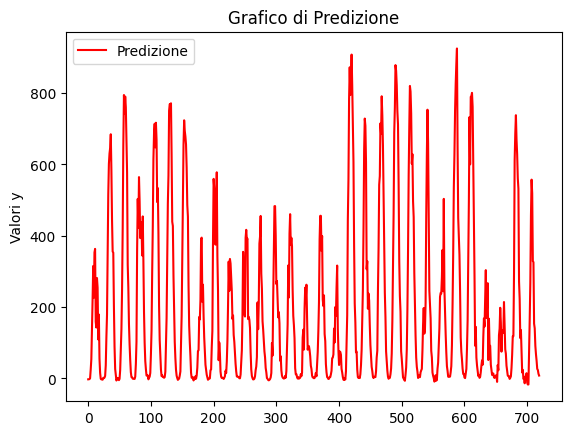

In [21]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [22]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [23]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [24]:
df.to_csv('C.csv')